In [18]:
from __future__ import print_function

import glob
import os

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import seaborn as sns
from ipywidgets import fixed, interact, interact_manual, interactive
from natsort import index_natsorted
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import binom



%load_ext line_profiler
%matplotlib inline
pyo.init_notebook_mode(connected=True)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Read in data

In [2]:
df = pd.read_csv("../../data/3_analysis-resistance/all_rgiout_2022-12-01", sep="\t")
df = df.sort_values(
    by=["Accession_Number"],
    ascending=True,
    key=lambda x: np.argsort(index_natsorted(df["Accession_Number"])),
    ignore_index=True,
)
df[["Species", "Subspecies"]] = df["Strain"].str.split("subsp.", 1, expand=True)
# df = df.replace(np.nan, "Null", regex=True)
df["Contig"] = df["Contig"].str.split("_", expand=True)[0]
df = df.dropna(subset=["Best_Hit_ARO"])
single_acc_df = df.drop_duplicates(subset=["Accession_Number"])
year_dict = (
    single_acc_df[["Accession_Number", "Year_Cultured"]]
    .set_index("Accession_Number")
    .to_dict()["Year_Cultured"]
)

In [3]:
full_nctcdf = pd.read_csv("../../data/0_databases/nctc_db.csv", sep="\t", index_col=0)
full_nctcdf = full_nctcdf.sort_values(
    by=["NCTC_Number"],
    ascending=True,
    key=lambda x: np.argsort(index_natsorted(full_nctcdf["NCTC_Number"])),
    ignore_index=True,
)
full_nctcdf[["Species", "Subspecies"]] = full_nctcdf["Current_Name"].str.split(
    "subsp.", 1, expand=True
)
full_nctcdf = full_nctcdf.replace(np.nan, "Null", regex=True)
genomeandyear_nctcdf = full_nctcdf.loc[
    (full_nctcdf["Year_Cultured"] != -1)
    & (full_nctcdf["Assembly_Accessions"] != "Null")
].copy()
family_name = genomeandyear_nctcdf["Species"].str.split(" ", expand=True)[0].str[0]
species_name = genomeandyear_nctcdf["Species"].str.split(" ", expand=True)[1]
genomeandyear_nctcdf["Specie_Name"] = family_name + ". " + species_name
specie_counts = genomeandyear_nctcdf["Specie_Name"].value_counts()
topx = specie_counts.head(5).index.tolist()
genomeandyear_nctcdf["TopSpecies"] = genomeandyear_nctcdf["Specie_Name"]
genomeandyear_nctcdf.loc[
    ~genomeandyear_nctcdf["TopSpecies"].isin(topx), ["TopSpecies"]
] = "Other"
genomeandyear_nctcdf["Accession_Number"] = genomeandyear_nctcdf[
    "NCTC_Number"
].str.replace(" ", "")
specie_dict = (
    genomeandyear_nctcdf[["Accession_Number", "Specie_Name"]]
    .set_index("Accession_Number")
    .to_dict()["Specie_Name"]
)

In [4]:
df["Species_Name"] = df["Accession_Number"].map(specie_dict)
df["Species_Name"].value_counts().head(5).index
failed_qc = pd.read_csv(
    "/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/6_checkm2/failed_filter.tsv",
    sep="\t",
)
df = df[~df["Accession_Number"].isin(failed_qc["NCTC_Isolate"])]
print(df.drop_duplicates("Accession_Number").shape)

(1671, 32)


In [5]:
# Get the list of all .tsv files
data_files = glob.glob(
    "/n/data1/hms/dbmi/baym/arya/projects/tools/callmemobile/output/nctc-mtrawler/*.tsv"
)

# Read only non-empty files
dfs = [pd.read_csv(f, sep="\t") for f in data_files if os.stat(f).st_size > 0]

# Concatenate the DataFrames
callmemobile_df = pd.concat(dfs, ignore_index=True)

callmemobile_df["Start"] = callmemobile_df["start"].astype("object")
callmemobile_df["Stop"] = callmemobile_df["end"].astype("object")
callmemobile_df["Contig"] = callmemobile_df["#chrom"].astype("object")
callmemobile_df = callmemobile_df.drop(columns=["start", "end", "#chrom"])
callmemobile_df = callmemobile_df.drop_duplicates()

In [6]:
df["Start"] = df["Start"].astype("int")
df["Stop"] = df["Stop"].astype("int")
df["Start_new"] = df[["Start", "Stop"]].min(axis=1)
df["Stop_new"] = df[["Start", "Stop"]].max(axis=1)
df = df.drop(["Start", "Stop"], axis=1).rename(
    columns={"Start_new": "Start", "Stop_new": "Stop"}
)

# df

In [7]:
merged_df = pd.merge(
    df,
    callmemobile_df.drop_duplicates(),
    on=["Contig", "Start", "Stop"],
    how="left",
    indicator=True,
)
merged_df

,Accession_Number,Strain,Assembly_No,Year_Cultured,ORF_ID,Contig,Orientation,Cut_Off,Pass_Bitscore,Best_Hit_Bitscore,...,Species_Name,Start,Stop,name,IntegronFinder,PlasmidFinder,mob_suite,phigaro,mobileelementfinder,_merge
0,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_231 # 254564 # 255658 ...,ENA|LM651928|LM651928.1,+,Strict,250.0,266.544,...,S. flexneri,254564,255658,vanG,no,no,no,vanG|near-prophage,vanG|overlaps-IS,both
1,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_406 # 416835 # 419984 ...,ENA|LM651928|LM651928.1,-,Strict,1900.0,2133.610,...,S. flexneri,416835,419984,acrB,no,no,no,no,no,both
2,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_407 # 420007 # 421200 ...,ENA|LM651928|LM651928.1,-,Strict,670.0,793.112,...,S. flexneri,420007,421200,Escherichia coli acrA,no,no,no,no,no,both
3,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_913 # 909925 # 911673 ...,ENA|LM651928|LM651928.1,+,Strict,1000.0,1190.250,...,S. flexneri,909925,911673,msbA,no,no,no,no,msbA|overlaps-IS,both
4,NCTC1,Shigella flexneri,1,1914,ENA|LM651928|LM651928.1_1084 # 1070322 # 10715...,ENA|LM651928|LM651928.1,-,Strict,750.0,799.275,...,S. flexneri,1070322,1071530,mdtH,no,no,no,no,no,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29657,NCTC14382,Yersinia canariae,1,2018,ENA|CP043727|CP043727.1_3533 # 3911579 # 39121...,ENA|CP043727|CP043727.1,+,Strict,390.0,392.504,...,Y. canariae,3911579,3912193,evgA,no,no,no,no,no,both
29658,NCTC14382,Yersinia canariae,1,2018,ENA|CP043727|CP043727.1_3965 # 4393476 # 43941...,ENA|CP043727|CP043727.1,+,Strict,400.0,430.254,...,Y. canariae,4393476,4394108,CRP,no,no,no,no,no,both
29659,NCTC14382,Yersinia canariae,1,2018,ENA|CP043727|CP043727.1_734 # 828203 # 829966 ...,ENA|CP043727|CP043727.1,+,Strict,500.0,585.104,...,Y. canariae,828203,829966,Haemophilus influenzae PBP3 conferring resista...,no,no,no,no,no,both
29660,NCTC14382,Yersinia canariae,1,2018,ENA|CP043727|CP043727.1_3889 # 4333449 # 43346...,ENA|CP043727|CP043727.1,-,Strict,700.0,733.791,...,Y. canariae,4333449,4334633,Escherichia coli EF-Tu mutants conferring resi...,no,no,no,no,no,both


In [8]:
mobility_df = merged_df[merged_df["_merge"] == "both"][
    [
        "Accession_Number",
        "Species_Name",
        "Best_Hit_ARO",
        "Resistance Mechanism",
        "AMR Gene Family",
        "Drug Class",
        "Year_Cultured",
        "IntegronFinder",
        "PlasmidFinder",
        "mob_suite",
        "phigaro",
        "mobileelementfinder",
        "Contig",
    ]
].copy()

# Create a new column 'Mobile' with default value 1
mobility_df["Mobile"] = 1

# Set 'Mobile' to 0 for rows where all four columns are equal to specific values
mobility_df.loc[
    (mobility_df["mobileelementfinder"] == "no")
    & (mobility_df["IntegronFinder"] == "no")
    & (mobility_df["PlasmidFinder"] == "no")
    & (mobility_df["mob_suite"] == "no")
    & (mobility_df["phigaro"] == "no"),
    "Mobile",
] = 0

mobility_df

,Accession_Number,Species_Name,Best_Hit_ARO,Resistance Mechanism,AMR Gene Family,Drug Class,Year_Cultured,IntegronFinder,PlasmidFinder,mob_suite,phigaro,mobileelementfinder,Contig,Mobile
0,NCTC1,S. flexneri,vanG,antibiotic target alteration,glycopeptide resistance gene cluster; Van ligase,glycopeptide antibiotic,1914,no,no,no,vanG|near-prophage,vanG|overlaps-IS,ENA|LM651928|LM651928.1,1
1,NCTC1,S. flexneri,acrB,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,fluoroquinolone antibiotic; cephalosporin; gly...,1914,no,no,no,no,no,ENA|LM651928|LM651928.1,0
2,NCTC1,S. flexneri,Escherichia coli acrA,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,fluoroquinolone antibiotic; cephalosporin; gly...,1914,no,no,no,no,no,ENA|LM651928|LM651928.1,0
3,NCTC1,S. flexneri,msbA,antibiotic efflux,ATP-binding cassette (ABC) antibiotic efflux pump,nitroimidazole antibiotic,1914,no,no,no,no,msbA|overlaps-IS,ENA|LM651928|LM651928.1,1
4,NCTC1,S. flexneri,mdtH,antibiotic efflux,major facilitator superfamily (MFS) antibiotic...,fluoroquinolone antibiotic,1914,no,no,no,no,no,ENA|LM651928|LM651928.1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29657,NCTC14382,Y. canariae,evgA,antibiotic efflux,major facilitator superfamily (MFS) antibiotic...,macrolide antibiotic; fluoroquinolone antibiot...,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,0
29658,NCTC14382,Y. canariae,CRP,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,macrolide antibiotic; fluoroquinolone antibiot...,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,0
29659,NCTC14382,Y. canariae,Haemophilus influenzae PBP3 conferring resista...,antibiotic target alteration,Penicillin-binding protein mutations conferrin...,cephalosporin; cephamycin; penam,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,0
29660,NCTC14382,Y. canariae,Escherichia coli EF-Tu mutants conferring resi...,antibiotic target alteration,elfamycin resistant EF-Tu,elfamycin antibiotic,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,0


In [9]:
mobility_df["me_simp"] = "no-me"
mobility_df.loc[mobility_df["mobileelementfinder"] != "no", "me_simp"] = "mobileelement"

mobility_df["integron_simp"] = "no-integron"
mobility_df.loc[
    (mobility_df["IntegronFinder"].str.contains("CALIN"))
    | (mobility_df["IntegronFinder"].str.contains("complete")),
    "integron_simp",
] = "Integron associated"

mobility_df["plasmid_simp"] = "no-plasmid"
mobility_df.loc[
    (mobility_df["mob_suite"] != "no"),
    "plasmid_simp",
] = "Plasmid associated"

mobility_df["plasmidtype_simp"] = "no-plasmid"
mobility_df.loc[
    mobility_df["mob_suite"].str.contains("conjugative"),
    "plasmidtype_simp",
] = "conjugative"
mobility_df.loc[
    mobility_df["mob_suite"].str.contains("mobilizable"),
    "plasmidtype_simp",
] = "mobilizable"
mobility_df.loc[
    mobility_df["mob_suite"].str.contains("non-mobilizable"),
    "plasmidtype_simp",
] = "non-mobilizable"

mobility_df["prophage_simp"] = "no-prophage"
mobility_df.loc[
    (mobility_df["phigaro"] != "no"),
    "prophage_simp",
] = "Prophage associated"

mobility_df["prophagetype_simp"] = "no-prophage"
mobility_df.loc[
    mobility_df["phigaro"].str.contains("near-prophage"),
    "prophagetype_simp",
] = "Near prophage"
mobility_df.loc[
    mobility_df["phigaro"].str.contains("inside-prophage"),
    "prophagetype_simp",
] = "Inside prophage"

mobility_df["Mobile"] = mobility_df.apply(
    lambda x: "{}|{}|{}|{}".format(
        x["me_simp"], x["integron_simp"], x["plasmid_simp"], x["prophage_simp"]
    ),
    axis=1,
)

mobility_df
# mobility_df.loc[mobility_df["plasmid_simp"] != "no-plasmid", "mobility_pred"] = "mobile"
# mobility_df.loc[
#     mobility_df["integron_simp"] != "no-plasmid", "mobility_pred"
# ] = "mobile"
# mobility_df.loc[mobility_df["plasmid_simp"] != "no-plasmid", "mobility_pred"] = "mobile"

,Accession_Number,Species_Name,Best_Hit_ARO,Resistance Mechanism,AMR Gene Family,Drug Class,Year_Cultured,IntegronFinder,PlasmidFinder,mob_suite,phigaro,mobileelementfinder,Contig,Mobile,me_simp,integron_simp,plasmid_simp,plasmidtype_simp,prophage_simp,prophagetype_simp
0,NCTC1,S. flexneri,vanG,antibiotic target alteration,glycopeptide resistance gene cluster; Van ligase,glycopeptide antibiotic,1914,no,no,no,vanG|near-prophage,vanG|overlaps-IS,ENA|LM651928|LM651928.1,mobileelement|no-integron|no-plasmid|Prophage ...,mobileelement,no-integron,no-plasmid,no-plasmid,Prophage associated,Near prophage
1,NCTC1,S. flexneri,acrB,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,fluoroquinolone antibiotic; cephalosporin; gly...,1914,no,no,no,no,no,ENA|LM651928|LM651928.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
2,NCTC1,S. flexneri,Escherichia coli acrA,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,fluoroquinolone antibiotic; cephalosporin; gly...,1914,no,no,no,no,no,ENA|LM651928|LM651928.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
3,NCTC1,S. flexneri,msbA,antibiotic efflux,ATP-binding cassette (ABC) antibiotic efflux pump,nitroimidazole antibiotic,1914,no,no,no,no,msbA|overlaps-IS,ENA|LM651928|LM651928.1,mobileelement|no-integron|no-plasmid|no-prophage,mobileelement,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
4,NCTC1,S. flexneri,mdtH,antibiotic efflux,major facilitator superfamily (MFS) antibiotic...,fluoroquinolone antibiotic,1914,no,no,no,no,no,ENA|LM651928|LM651928.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29657,NCTC14382,Y. canariae,evgA,antibiotic efflux,major facilitator superfamily (MFS) antibiotic...,macrolide antibiotic; fluoroquinolone antibiot...,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
29658,NCTC14382,Y. canariae,CRP,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,macrolide antibiotic; fluoroquinolone antibiot...,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
29659,NCTC14382,Y. canariae,Haemophilus influenzae PBP3 conferring resista...,antibiotic target alteration,Penicillin-binding protein mutations conferrin...,cephalosporin; cephamycin; penam,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
29660,NCTC14382,Y. canariae,Escherichia coli EF-Tu mutants conferring resi...,antibiotic target alteration,elfamycin resistant EF-Tu,elfamycin antibiotic,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage


## Panel A

In [172]:

def measure_obs_distance(
    dataframe, value, anthro_year, column, sums=False, verbose=False
):
    num_yearcultured_allstrains_dict = (
        dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    num_yearcultured_valposstrains_dict = (
        dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
        .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    fractional_dictionary = {}
    for years in num_yearcultured_allstrains_dict:
        if num_yearcultured_allstrains_dict[years] == 0:
            continue
        if years in num_yearcultured_valposstrains_dict:
            val = [
                num_yearcultured_valposstrains_dict[years],
                num_yearcultured_allstrains_dict[years],
            ]
        else:
            val = [0, num_yearcultured_allstrains_dict[years]]
        fractional_dictionary[years] = val

    yeardf = (
        pd.DataFrame.from_dict(
            fractional_dictionary, orient="index", columns=["num_pos", "all"]
        )
        .reset_index()
        .rename(columns={"index": "year"})
        .sort_values(by="year")
        .reset_index(drop=True)
    )
    yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
    if verbose:
        print(yeardf)
    anthro = {True: "Pre-Human", False: "Post-Human"}
    yeardf["Anthropogenicity"] = "Pre-Human"
    yeardf.loc[yeardf["year"] > anthro_year, "Anthropogenicity"] = "Post-Human"

    preanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Pre-Human"][
        "frac"
    ].mean()
    postanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Post-Human"][
        "frac"
    ].mean()
    metric = postanthro_mean - preanthro_mean
    return yeardf, preanthro_mean, postanthro_mean


def calculate_frequency_bounds(row, confidence=0.95):
    successes = row["num_pos"]
    attempts = row["all"]
    freq = row["num_pos"] / row["all"]
    alpha = successes + 1
    beta = attempts - successes + 1
    lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
    return (lower_b, upper_b)


def plot_abresist_frac_error_mobility(
    df1,
    ex1,
    ex2,
    ex3,
    ex4,
    year,
    verbose=True,
    sims=100,
    figname="doodoo",
    savefig=False,
    smooth=5,
    col1="me_simp",
    col2="integron_simp",
    col3="plasmid_simp",
    col4="prophage_simp",
    value="phenotype",
):

    sns.set_theme(font="Arial", style="white", font_scale=0.7)

    frac_df1, pre, post = measure_obs_distance(df1, ex1, 0, col1, verbose)
    frac_df2, pre, post = measure_obs_distance(df1, ex2, 0, col2, verbose)
    frac_df3, pre, post = measure_obs_distance(df1, ex3, 0, col3, verbose)
    frac_df4, pre, post = measure_obs_distance(df1, ex4, 0, col4, verbose)

    # print(frac_df)

    # histogram of fraction of strains w/ RGI hits for drug class
    plt.figure(figsize=(14, 8))
    chart = sns.barplot(
        data=frac_df1, x="year", y="frac", color="salmon", saturation=0.5
    )
    chart.bar_label(chart.containers[0])

    # plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
    plt.ylabel("Fraction of bugs with phenotype")
    plt.xlabel("Year")
    plt.xticks(rotation=45)

    plt.show()

    d = {"Year": [], "num_pos": [], "all": []}
    for years in range(frac_df1["year"].min(), frac_df1["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df1.loc[(frac_df1["year"] <= upb) & (downb <= frac_df1["year"])]
        if years not in frac_df1["year"].values:
            continue
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
        d["Year"].append(years)
    xdf1 = pd.DataFrame(data=d)
    # print(xdf)
    xdf1["frac"] = xdf1["num_pos"] / xdf1["all"]
    xdf1[["lower-error", "upper-error"]] = xdf1.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    d = {"Year": [], "num_pos": [], "all": []}
    for years in range(frac_df2["year"].min(), frac_df2["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df2.loc[(frac_df2["year"] <= upb) & (downb <= frac_df2["year"])]
        if years not in frac_df2["year"].values:
            continue
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
        d["Year"].append(years)
    xdf2 = pd.DataFrame(data=d)
    # print(xdf)
    xdf2["frac"] = xdf2["num_pos"] / xdf2["all"]
    xdf2[["lower-error", "upper-error"]] = xdf2.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    d = {"Year": [], "num_pos": [], "all": []}
    for years in range(frac_df3["year"].min(), frac_df3["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df3.loc[(frac_df3["year"] <= upb) & (downb <= frac_df3["year"])]
        if years not in frac_df3["year"].values:
            continue
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
        d["Year"].append(years)
    xdf3 = pd.DataFrame(data=d)
    # print(xdf)
    xdf3["frac"] = xdf3["num_pos"] / xdf3["all"]
    xdf3[["lower-error", "upper-error"]] = xdf3.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    d = {"Year": [], "num_pos": [], "all": []}
    for years in range(frac_df4["year"].min(), frac_df4["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df4.loc[(frac_df4["year"] <= upb) & (downb <= frac_df4["year"])]
        if years not in frac_df4["year"].values:
            continue
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
        d["Year"].append(years)
    xdf4 = pd.DataFrame(data=d)
    # print(xdf)
    xdf4["frac"] = xdf4["num_pos"] / xdf4["all"]
    xdf4[["lower-error", "upper-error"]] = xdf4.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    fig1, ax1 = plt.subplots(figsize=(14, 8))

    # make subplots for the figure
    ax1.set(xlabel="Year Cultured")
    lp = sns.lineplot(
        data=xdf1,
        x="Year",
        y="frac",
        markers=True,
        ax=ax1,
    )
    lp.set(ylim=(0, 1))
    dp = sns.scatterplot(
        data=xdf1,
        x="Year",
        y="frac",
        legend=False,
        ax=ax1,
        edgecolor="none",
    )
    plt.fill_between(
        xdf1["Year"],
        xdf1["lower-error"],
        xdf1["upper-error"],
        alpha=0.3,
        edgecolor=sns.color_palette("deep")[0],
        facecolor=sns.color_palette("deep")[0],
    )

    # make subplots for the figure
    ax1.set(xlabel="Year Cultured")
    lp = sns.lineplot(
        data=xdf2,
        x="Year",
        y="frac",
        markers=True,
        ax=ax1,
    )
    # lp.set(ylim=(0, 1))
    dp = sns.scatterplot(
        data=xdf2,
        x="Year",
        y="frac",
        legend=False,
        ax=ax1,
        edgecolor="none",
    )
    plt.fill_between(
        xdf2["Year"],
        xdf2["lower-error"],
        xdf2["upper-error"],
        alpha=0.3,
        edgecolor=sns.color_palette("deep")[1],
        facecolor=sns.color_palette("deep")[1],
    )

    # make subplots for the figure
    ax1.set(xlabel="Year Cultured")
    lp = sns.lineplot(
        data=xdf3,
        x="Year",
        y="frac",
        markers=True,
        ax=ax1,
    )
    # lp.set(ylim=(0, 1))
    dp = sns.scatterplot(
        data=xdf3,
        x="Year",
        y="frac",
        legend=False,
        ax=ax1,
        edgecolor="none",
    )
    plt.fill_between(
        xdf3["Year"],
        xdf3["lower-error"],
        xdf3["upper-error"],
        alpha=0.3,
        edgecolor=sns.color_palette("deep")[2],
        facecolor=sns.color_palette("deep")[2],
    )

    # make subplots for the figure
    lp = sns.lineplot(
        data=xdf4,
        x="Year",
        y="frac",
        markers=True,
        ax=ax1,
    )
    # lp.set(ylim=(0, 1))
    dp = sns.scatterplot(
        data=xdf4,
        x="Year",
        y="frac",
        legend=False,
        ax=ax1,
        edgecolor="none",
    )
    plt.fill_between(
        xdf4["Year"],
        xdf4["lower-error"],
        xdf4["upper-error"],
        alpha=0.3,
        edgecolor=sns.color_palette("deep")[3],
        facecolor=sns.color_palette("deep")[3],
    )
    ax1.set(ylim=(-0.05, 1.05))
    sns.despine()

    # Create a list of labels for the legend
    legend_labels = [
        "Tn/IS associated",
        "Plasmid associated",
        "Integron associated",
        "Prophage associated",
    ]

    # Create a list of the colors corresponding to each label
    legend_colors = [
        sns.color_palette("deep")[0],
        sns.color_palette("deep")[1],
        sns.color_palette("deep")[2],
        sns.color_palette("deep")[3],
    ]

    # Add a legend to the plot
    plt.legend(
        legend_labels,
        loc="upper right",
        title="Mobility classes",
        labels=legend_labels,
        handles=[
            plt.Line2D(
                [0], [0], marker="o", color=color, markerfacecolor=color, markersize=8
            )
            for color in legend_colors
            # markersize=10,
        ],
    )

    ax1.set_ylabel(f"Fraction of genomic resistance\nelements with mobility")
    # ax1.set(ylabel="Fraction of isolates with {}".format(value))

    if savefig:
        plt.gcf().set_size_inches(3.5, 2.2)
        plt.savefig(
            "{}-fractionofresist.svg".format(figname),
            bbox_inches="tight",
            dpi=300,
        )

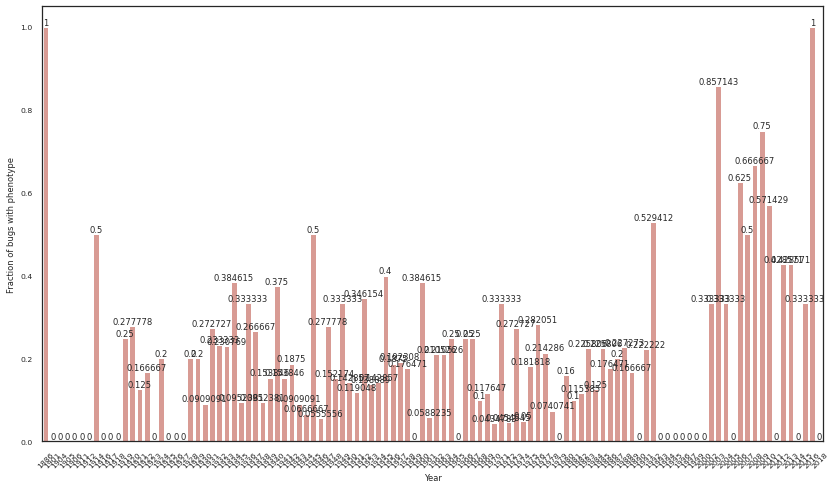

/tmp/ipykernel_26618/3865867158.py:306: UserWarning:

You have mixed positional and keyword arguments, some input may be discarded.



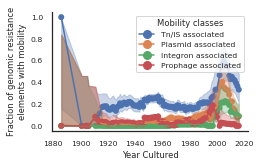

In [173]:
plot_abresist_frac_error_mobility(
    mobility_df,
    "mobileelement",
    "Plasmid associated",
    "Integron associated",
    "Prophage associated",
    0,
    verbose=True,
    sims=100,
    figname="./figs/fig5/resistance_fraction",
    savefig=True,
    smooth=5,
    col1="me_simp",
    col2="plasmid_simp",
    col3="integron_simp",
    col4="prophage_simp",
    value="phenotype",
)

## Panel B

In [174]:
# Get all contig reports
data_files = glob.glob(
    "/n/data1/hms/dbmi/baym/arya/projects/tools/callmemobile/intermediate/nctc-mtrawler/mob-suite/raw/*/*/contig_report.txt"
)

dfs = []
for f in data_files:
    if os.stat(f).st_size > 0:
        indiv_df = pd.read_csv(f, sep="\t")
        indiv_df["filename"] = f
        indiv_df["sequence_number"] = f.split("/")[-3]
        dfs.append(indiv_df)

# Concatenate the DataFrames
contig_report_df = pd.concat(dfs, ignore_index=True)

In [175]:
input_callmemobile = pd.read_csv(
    "/n/data1/hms/dbmi/baym/arya/projects/tools/callmemobile/input/nctc-mtrawler.txt",
    names=["path"],
)

input_callmemobile["number"] = input_callmemobile.index + 1
input_callmemobile["sequence_number"] = input_callmemobile["number"].apply(
    lambda x: f"sequence_{x}"
)
input_callmemobile["accession_number"] = input_callmemobile["path"].apply(
    lambda x: x.split("/")[-3]
)
seqnum_to_accession_dict = input_callmemobile.set_index("sequence_number")[
    "accession_number"
].to_dict()

In [176]:
contig_report_df["Accession_Number"] = contig_report_df["sequence_number"].map(
    seqnum_to_accession_dict
)
contig_report_df["Year_Cultured"] = contig_report_df["Accession_Number"].map(year_dict)
contig_report_df = contig_report_df.dropna(subset=["Year_Cultured"])
contig_report_df["Year_Cultured"] = contig_report_df["Year_Cultured"].astype(int)
print(contig_report_df.shape)
failed_qc = pd.read_csv(
    "/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/6_checkm2/failed_filter.tsv",
    sep="\t",
)
contig_report_df = contig_report_df[
    ~contig_report_df["Accession_Number"].isin(failed_qc["NCTC_Isolate"])
]
print(contig_report_df.shape)

(17087, 28)
(12734, 28)


In [177]:
contig_report_df["Year_Cultured"].isna().value_counts()

False    12734
Name: Year_Cultured, dtype: int64

In [178]:
contig_report_df["contig_id"]

0        ENA|LR134481|LR134481.1 Haemophilus parainflue...
1        UHDB01000001.1 Staphylococcus chromogenes stra...
2        UHDB01000002.1 Staphylococcus chromogenes stra...
3        ENA|CM003342|CM003342.1 Clostridium novyi B st...
4        UGQY01000001.1 Mycolicibacterium fortuitum str...
                               ...                        
18402    UAWT01000047.1 Listeria fleischmannii subsp. f...
18403    UAWT01000048.1 Listeria fleischmannii subsp. f...
18404    UAWT01000049.1 Listeria fleischmannii subsp. f...
18405    UAWT01000050.1 Listeria fleischmannii subsp. f...
18406    UAWT01000051.1 Listeria fleischmannii subsp. f...
Name: contig_id, Length: 12734, dtype: object

In [179]:
contig_report_df.columns

Index(['sample_id', 'molecule_type', 'primary_cluster_id',
       'secondary_cluster_id', 'contig_id', 'size', 'gc', 'md5',
       'circularity_status', 'rep_type(s)', 'rep_type_accession(s)',
       'relaxase_type(s)', 'relaxase_type_accession(s)', 'mpf_type',
       'mpf_type_accession(s)', 'orit_type(s)', 'orit_accession(s)',
       'predicted_mobility', 'mash_nearest_neighbor', 'mash_neighbor_distance',
       'mash_neighbor_identification', 'repetitive_dna_id',
       'repetitive_dna_type', 'filtering_reason', 'filename',
       'sequence_number', 'Accession_Number', 'Year_Cultured'],
      dtype='object')

In [180]:
contig_report_df["molecule_type"].value_counts()

chromosome    11516
plasmid        1218
Name: molecule_type, dtype: int64

In [181]:
contig_report_df["Contig"] = contig_report_df["contig_id"].str.split().str.get(0)
contig_report_df

,sample_id,molecule_type,primary_cluster_id,secondary_cluster_id,contig_id,size,gc,md5,circularity_status,rep_type(s),...,mash_neighbor_distance,mash_neighbor_identification,repetitive_dna_id,repetitive_dna_type,filtering_reason,filename,sequence_number,Accession_Number,Year_Cultured,Contig
0,assembly,chromosome,-,-,ENA|LR134481|LR134481.1 Haemophilus parainflue...,2062405,0.393715,376a1ed81526b3a004e5775370e7c659,not tested,-,...,-,-,-,-,-,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1,NCTC10665,1969,ENA|LR134481|LR134481.1
1,assembly,chromosome,-,-,UHDB01000001.1 Staphylococcus chromogenes stra...,2280656,0.368329,9adc6b4dc2d4615d9745b24ba41da293,not tested,-,...,-,-,-,-,-,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_10,NCTC10530,1967,UHDB01000001.1
2,assembly,chromosome,-,-,UHDB01000002.1 Staphylococcus chromogenes stra...,30120,0.291700,fa83ddef2de6f86f73b65e987e1a5f99,not tested,-,...,-,-,-,-,-,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_10,NCTC10530,1967,UHDB01000002.1
3,assembly_1,chromosome,-,-,ENA|CM003342|CM003342.1 Clostridium novyi B st...,50768,0.280551,fdcaf3c1db3b4bc5c838f0221de17561,not tested,-,...,-,-,-,-,-,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_100,NCTC9691,1955,ENA|CM003342|CM003342.1
4,assembly,chromosome,-,-,UGQY01000001.1 Mycolicibacterium fortuitum str...,2278824,0.661509,7fd15e9ab62c9822bef27733f668f228,not tested,-,...,-,-,-,-,-,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1000,NCTC1542,1923,UGQY01000001.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18402,assembly,chromosome,-,-,UAWT01000047.1 Listeria fleischmannii subsp. f...,4599,0.505545,a15c7966db62c005843bc253fd3c4807,not tested,-,...,-,-,-,-,-,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_999,NCTC13940,2006,UAWT01000047.1
18403,assembly,chromosome,-,-,UAWT01000048.1 Listeria fleischmannii subsp. f...,139068,0.380382,2dee474f1798e7ead9f93a7109d30b86,not tested,-,...,-,-,-,-,-,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_999,NCTC13940,2006,UAWT01000048.1
18404,assembly,chromosome,-,-,UAWT01000049.1 Listeria fleischmannii subsp. f...,130587,0.385260,aed3cf7491e64ae3d961128815309ffd,not tested,-,...,-,-,-,-,-,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_999,NCTC13940,2006,UAWT01000049.1
18405,assembly,chromosome,-,-,UAWT01000050.1 Listeria fleischmannii subsp. f...,91471,0.377387,e3ca283c99dc226fb7311139bb7dd3a8,not tested,-,...,-,-,-,-,-,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_999,NCTC13940,2006,UAWT01000050.1


In [182]:
resistanceplasmids = pd.merge(
    df,
    contig_report_df,
    on=["Contig", "Accession_Number", "Year_Cultured"],
    how="inner",
    indicator=True,
)
resistanceplasmids[["_merge"]].value_counts()

_merge    
both          29662
left_only         0
right_only        0
dtype: int64

In [183]:
resistanceplasmids.columns

Index(['Accession_Number', 'Strain', 'Assembly_No', 'Year_Cultured', 'ORF_ID',
       'Contig', 'Orientation', 'Cut_Off', 'Pass_Bitscore',
       'Best_Hit_Bitscore', 'Best_Hit_ARO', 'Best_Identities', 'ARO',
       'Model_type', 'SNPs_in_Best_Hit_ARO', 'Other_SNPs', 'Drug Class',
       'Resistance Mechanism', 'AMR Gene Family', 'Predicted_DNA',
       'Predicted_Protein', 'CARD_Protein_Sequence',
       'Percentage Length of Reference Sequence', 'ID', 'Model_ID', 'Nudged',
       'Note', 'Species', 'Subspecies', 'Species_Name', 'Start', 'Stop',
       'sample_id', 'molecule_type', 'primary_cluster_id',
       'secondary_cluster_id', 'contig_id', 'size', 'gc', 'md5',
       'circularity_status', 'rep_type(s)', 'rep_type_accession(s)',
       'relaxase_type(s)', 'relaxase_type_accession(s)', 'mpf_type',
       'mpf_type_accession(s)', 'orit_type(s)', 'orit_accession(s)',
       'predicted_mobility', 'mash_nearest_neighbor', 'mash_neighbor_distance',
       'mash_neighbor_identification

In [184]:
def measure_obs_distance(
    dataframe, value, anthro_year, column, sums=False, verbose=False
):
    num_yearcultured_allstrains_dict = (
        dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    num_yearcultured_valposstrains_dict = (
        dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
        .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    fractional_dictionary = {}
    for years in num_yearcultured_allstrains_dict:
        if num_yearcultured_allstrains_dict[years] == 0:
            continue
        if years in num_yearcultured_valposstrains_dict:
            val = [
                num_yearcultured_valposstrains_dict[years],
                num_yearcultured_allstrains_dict[years],
            ]
        else:
            val = [0, num_yearcultured_allstrains_dict[years]]
        fractional_dictionary[years] = val

    yeardf = (
        pd.DataFrame.from_dict(
            fractional_dictionary, orient="index", columns=["num_pos", "all"]
        )
        .reset_index()
        .rename(columns={"index": "year"})
        .sort_values(by="year")
        .reset_index(drop=True)
    )
    yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
    if verbose:
        print(yeardf)
    anthro = {True: "Pre-Human", False: "Post-Human"}
    yeardf["Anthropogenicity"] = "Pre-Human"
    yeardf.loc[yeardf["year"] > anthro_year, "Anthropogenicity"] = "Post-Human"

    preanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Pre-Human"][
        "frac"
    ].mean()
    postanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Post-Human"][
        "frac"
    ].mean()
    metric = postanthro_mean - preanthro_mean
    return yeardf, preanthro_mean, postanthro_mean


import scipy.stats as stats
from scipy.stats import binom


def calculate_frequency_bounds(row, confidence=0.95):
    successes = row["num_pos"]
    attempts = row["all"]
    freq = row["num_pos"] / row["all"]
    alpha = successes + 1
    beta = attempts - successes + 1
    lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
    return (lower_b, upper_b)


def plot_abresist_frac_error_plasmids(
    df1,
    df2,
    ex1,
    ex2,
    year,
    verbose=True,
    sims=100,
    figname="doodoo",
    savefig=False,
    smooth=5,
    col1="Drug Class",
    col2="Drug Class",
    value="phenotype",
):

    sns.set_theme(font="Arial", style="white", font_scale=0.7)

    frac_df1, pre, post = measure_obs_distance(df1, ex1, 0, col1, verbose)
    frac_df2, pre, post = measure_obs_distance(df2, ex2, 0, col2, verbose)

    # print(frac_df)

    # histogram of fraction of strains w/ RGI hits for drug class
    plt.figure(figsize=(14, 8))
    chart = sns.barplot(
        data=frac_df1, x="year", y="frac", color="salmon", saturation=0.5
    )
    chart.bar_label(chart.containers[0])

    # plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
    plt.ylabel("Fraction of bugs with phenotype")
    plt.xlabel("Year")
    plt.xticks(rotation=45)

    plt.show()

    d = {"Year": [], "num_pos": [], "all": []}
    for years in range(frac_df1["year"].min(), frac_df1["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df1.loc[(frac_df1["year"] <= upb) & (downb <= frac_df1["year"])]
        if years not in frac_df1["year"].values:
            continue
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
        d["Year"].append(years)
    xdf1 = pd.DataFrame(data=d)
    # print(xdf)
    xdf1["frac"] = xdf1["num_pos"] / xdf1["all"]
    xdf1[["lower-error", "upper-error"]] = xdf1.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    d = {"Year": [], "num_pos": [], "all": []}
    for years in range(frac_df2["year"].min(), frac_df2["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df2.loc[(frac_df2["year"] <= upb) & (downb <= frac_df2["year"])]
        if years not in frac_df2["year"].values:
            continue
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
        d["Year"].append(years)
    xdf2 = pd.DataFrame(data=d)
    # print(xdf)
    xdf2["frac"] = xdf2["num_pos"] / xdf2["all"]
    xdf2[["lower-error", "upper-error"]] = xdf2.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    fig1, ax1 = plt.subplots(figsize=(14, 8))
    # ax2 = ax1.twinx()  # Create a second y-axis

    # make subplots for the figure
    ax1.set(xlabel="Year Cultured", ylim=(-0.05, 1.05))
    lp = sns.lineplot(
        data=xdf1,
        x="Year",
        y="frac",
        markers=True,
        ax=ax1,
    )
    # lp.set(ylim=(0, 1))
    dp = sns.scatterplot(
        data=xdf1,
        x="Year",
        y="frac",
        legend=False,
        ax=ax1,
        edgecolor="none",
    )
    plt.fill_between(
        xdf1["Year"],
        xdf1["lower-error"],
        xdf1["upper-error"],
        alpha=0.3,
        edgecolor=sns.color_palette("deep")[0],
        facecolor=sns.color_palette("deep")[0],
    )

    # make subplots for the figure
    # ax1.set(xlabel="Year Cultured")
    lp = sns.lineplot(
        data=xdf2,
        x="Year",
        y="frac",
        markers=True,
        ax=ax1,
        color=sns.color_palette("deep")[1],
    )
    dp = sns.scatterplot(
        data=xdf2,
        x="Year",
        y="frac",
        legend=False,
        ax=ax1,
        edgecolor="none",
        facecolor=sns.color_palette("deep")[1],
    )
    plt.fill_between(
        xdf2["Year"],
        xdf2["lower-error"],
        xdf2["upper-error"],
        alpha=0.3,
        edgecolor=sns.color_palette("deep")[1],
        facecolor=sns.color_palette("deep")[1],
    )

    # Manually create legend
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color=sns.color_palette("deep")[0],
            label="≥ 1 plasmid",
            markerfacecolor=sns.color_palette("deep")[0],
            # markersize=10,
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color=sns.color_palette("deep")[1],
            label="≥ 1 plasmid with ≥ 1 resistance element",
            markerfacecolor=sns.color_palette("deep")[1],
            # markersize=10,
        ),
    ]

    plt.legend(handles=legend_elements)
    ax1.set(ylabel="Fraction of isolates")
    ax1.set_ylim((-0.05, 1.05))

    sns.despine()

    if savefig:
        plt.gcf().set_size_inches(3.5, 2.2)
        plt.savefig(
            "{}-fractionofresist.svg".format(figname),
            bbox_inches="tight",
            dpi=300,
        )

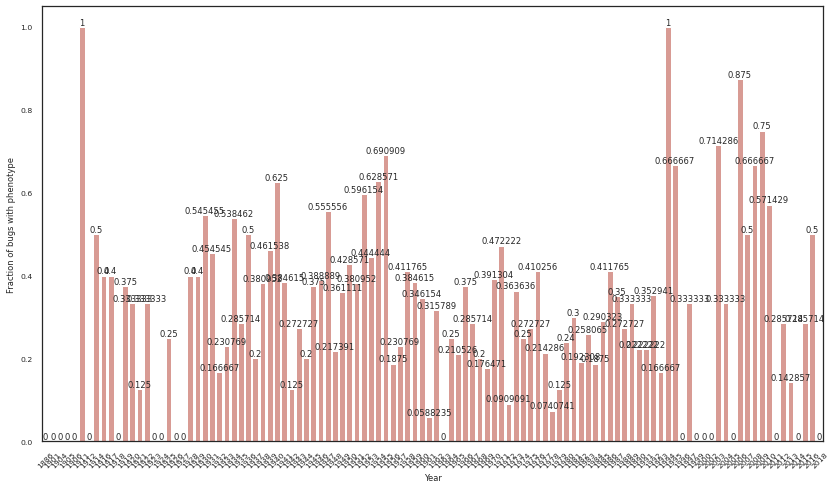

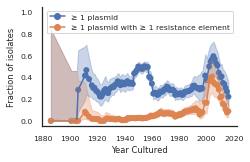

In [185]:
plot_abresist_frac_error_plasmids(
    df1=contig_report_df,
    df2=resistanceplasmids,  # Not used in this scenario
    ex1="plasmid",  # Filter for rows where `molecule_type` contains "plasmid"
    ex2="plasmid",  # Not used
    year=1923,  # First year in the dataset
    verbose=True,
    sims=100,
    figname="./figs/fig5/panelb_plasmidmobility",
    savefig=True,
    smooth=5,
    col1="molecule_type",
    col2="molecule_type",  # Not used
    value="phenotype",
)

## Panel C

In [132]:
# Get all contig reports
data_files = glob.glob(
    "/n/data1/hms/dbmi/baym/arya/projects/tools/callmemobile/intermediate/nctc-mtrawler/IntegronFinder/raw/*/*/*.summary"
)

dfs = []
for f in data_files:
    if os.stat(f).st_size > 0:
        indiv_df = pd.read_csv(f, sep="\t", comment="#")
        indiv_df["filename"] = f
        indiv_df["sequence_number"] = f.split("/")[-3]
        dfs.append(indiv_df)

# Concatenate the DataFrames
integronsummary_df = pd.concat(dfs, ignore_index=True)
integronsummary_df

,ID_replicon,CALIN,complete,In0,topology,size,filename,sequence_number
0,ENA|LR134481|LR134481.1,0,0,0,circ,2062405,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1
1,UHDB01000001.1,0,0,0,lin,2280656,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_10
2,UHDB01000002.1,0,0,0,lin,30120,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_10
3,ENA|CM003342|CM003342.1,0,0,0,circ,50768,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_100
4,UGQY01000001.1,0,0,0,lin,2278824,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1000
...,...,...,...,...,...,...,...,...
18198,UAWT01000047.1,0,0,0,lin,4599,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_999
18199,UAWT01000048.1,0,0,0,lin,139068,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_999
18200,UAWT01000049.1,0,0,0,lin,130587,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_999
18201,UAWT01000050.1,0,0,0,lin,91471,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_999


In [133]:
integronsummary_df[["CALIN", "complete"]].value_counts()

CALIN  complete
0      0           18090
       1              52
1      0              31
       1              13
0      2               4
4      1               4
2      1               3
       2               2
0      3               1
1      3               1
2      0               1
3      1               1
dtype: int64

In [134]:
input_callmemobile = pd.read_csv(
    "/n/data1/hms/dbmi/baym/arya/projects/tools/callmemobile/input/nctc-mtrawler.txt",
    names=["path"],
)

input_callmemobile["number"] = input_callmemobile.index + 1
input_callmemobile["sequence_number"] = input_callmemobile["number"].apply(
    lambda x: f"sequence_{x}"
)
input_callmemobile["accession_number"] = input_callmemobile["path"].apply(
    lambda x: x.split("/")[-3]
)
seqnum_to_accession_dict = input_callmemobile.set_index("sequence_number")[
    "accession_number"
].to_dict()

In [135]:
integronsummary_df["Accession_Number"] = integronsummary_df["sequence_number"].map(
    seqnum_to_accession_dict
)
integronsummary_df["Year_Cultured"] = integronsummary_df["Accession_Number"].map(
    year_dict
)
integronsummary_df = integronsummary_df.dropna(subset=["Year_Cultured"])
integronsummary_df["Year_Cultured"] = integronsummary_df["Year_Cultured"].astype(int)
print(integronsummary_df.shape)
failed_qc = pd.read_csv(
    "/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/6_checkm2/failed_filter.tsv",
    sep="\t",
)
integronsummary_df = integronsummary_df[
    ~integronsummary_df["Accession_Number"].isin(failed_qc["NCTC_Isolate"])
]
print(integronsummary_df.shape)

(16928, 10)
(12578, 10)


/tmp/ipykernel_26618/969017833.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [136]:
integronsummary_df["integron_simp"] = np.where(
    (integronsummary_df["complete"] != 0), "YES", "NO"
)
integronsummary_df["Contig"] = integronsummary_df["ID_replicon"]
integronsummary_df

,ID_replicon,CALIN,complete,In0,topology,size,filename,sequence_number,Accession_Number,Year_Cultured,integron_simp,Contig
0,ENA|LR134481|LR134481.1,0,0,0,circ,2062405,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1,NCTC10665,1969,NO,ENA|LR134481|LR134481.1
1,UHDB01000001.1,0,0,0,lin,2280656,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_10,NCTC10530,1967,NO,UHDB01000001.1
2,UHDB01000002.1,0,0,0,lin,30120,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_10,NCTC10530,1967,NO,UHDB01000002.1
3,ENA|CM003342|CM003342.1,0,0,0,circ,50768,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_100,NCTC9691,1955,NO,ENA|CM003342|CM003342.1
4,UGQY01000001.1,0,0,0,lin,2278824,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1000,NCTC1542,1923,NO,UGQY01000001.1
...,...,...,...,...,...,...,...,...,...,...,...,...
18198,UAWT01000047.1,0,0,0,lin,4599,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_999,NCTC13940,2006,NO,UAWT01000047.1
18199,UAWT01000048.1,0,0,0,lin,139068,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_999,NCTC13940,2006,NO,UAWT01000048.1
18200,UAWT01000049.1,0,0,0,lin,130587,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_999,NCTC13940,2006,NO,UAWT01000049.1
18201,UAWT01000050.1,0,0,0,lin,91471,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_999,NCTC13940,2006,NO,UAWT01000050.1


In [137]:
mobility_df

,Accession_Number,Species_Name,Best_Hit_ARO,Resistance Mechanism,AMR Gene Family,Drug Class,Year_Cultured,IntegronFinder,PlasmidFinder,mob_suite,phigaro,mobileelementfinder,Contig,Mobile,me_simp,integron_simp,plasmid_simp,plasmidtype_simp,prophage_simp,prophagetype_simp
0,NCTC1,S. flexneri,vanG,antibiotic target alteration,glycopeptide resistance gene cluster; Van ligase,glycopeptide antibiotic,1914,no,no,no,vanG|near-prophage,vanG|overlaps-IS,ENA|LM651928|LM651928.1,mobileelement|no-integron|no-plasmid|Prophage-...,mobileelement,no-integron,no-plasmid,no-plasmid,Prophage-associated,Near prophage
1,NCTC1,S. flexneri,acrB,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,fluoroquinolone antibiotic; cephalosporin; gly...,1914,no,no,no,no,no,ENA|LM651928|LM651928.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
2,NCTC1,S. flexneri,Escherichia coli acrA,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,fluoroquinolone antibiotic; cephalosporin; gly...,1914,no,no,no,no,no,ENA|LM651928|LM651928.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
3,NCTC1,S. flexneri,msbA,antibiotic efflux,ATP-binding cassette (ABC) antibiotic efflux pump,nitroimidazole antibiotic,1914,no,no,no,no,msbA|overlaps-IS,ENA|LM651928|LM651928.1,mobileelement|no-integron|no-plasmid|no-prophage,mobileelement,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
4,NCTC1,S. flexneri,mdtH,antibiotic efflux,major facilitator superfamily (MFS) antibiotic...,fluoroquinolone antibiotic,1914,no,no,no,no,no,ENA|LM651928|LM651928.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29657,NCTC14382,Y. canariae,evgA,antibiotic efflux,major facilitator superfamily (MFS) antibiotic...,macrolide antibiotic; fluoroquinolone antibiot...,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
29658,NCTC14382,Y. canariae,CRP,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,macrolide antibiotic; fluoroquinolone antibiot...,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
29659,NCTC14382,Y. canariae,Haemophilus influenzae PBP3 conferring resista...,antibiotic target alteration,Penicillin-binding protein mutations conferrin...,cephalosporin; cephamycin; penam,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
29660,NCTC14382,Y. canariae,Escherichia coli EF-Tu mutants conferring resi...,antibiotic target alteration,elfamycin resistant EF-Tu,elfamycin antibiotic,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage


In [138]:
resistanceintegrons = pd.merge(
    mobility_df,
    integronsummary_df,
    on=["Contig", "Accession_Number", "Year_Cultured"],
    how="inner",
    indicator=True,
)
resistanceintegrons[["_merge"]].value_counts()

_merge    
both          29662
left_only         0
right_only        0
dtype: int64

In [139]:
resistanceintegrons["integron_simp"] = np.where(
    (resistanceintegrons["IntegronFinder"] != "no"), "YES", "NO"
)

In [140]:
import scipy.stats as stats
from scipy.stats import binom


def measure_obs_distance(
    dataframe, value, anthro_year, column, sums=False, verbose=False
):
    num_yearcultured_allstrains_dict = (
        dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    num_yearcultured_valposstrains_dict = (
        dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
        .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    fractional_dictionary = {}
    for years in num_yearcultured_allstrains_dict:
        if num_yearcultured_allstrains_dict[years] == 0:
            continue
        if years in num_yearcultured_valposstrains_dict:
            val = [
                num_yearcultured_valposstrains_dict[years],
                num_yearcultured_allstrains_dict[years],
            ]
        else:
            val = [0, num_yearcultured_allstrains_dict[years]]
        fractional_dictionary[years] = val

    yeardf = (
        pd.DataFrame.from_dict(
            fractional_dictionary, orient="index", columns=["num_pos", "all"]
        )
        .reset_index()
        .rename(columns={"index": "year"})
        .sort_values(by="year")
        .reset_index(drop=True)
    )
    yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
    if verbose:
        print(yeardf)
    anthro = {True: "Pre-Human", False: "Post-Human"}
    yeardf["Anthropogenicity"] = "Pre-Human"
    yeardf.loc[yeardf["year"] > anthro_year, "Anthropogenicity"] = "Post-Human"

    preanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Pre-Human"][
        "frac"
    ].mean()
    postanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Post-Human"][
        "frac"
    ].mean()
    metric = postanthro_mean - preanthro_mean
    return yeardf, preanthro_mean, postanthro_mean


def calculate_frequency_bounds(row, confidence=0.95):
    successes = row["num_pos"]
    attempts = row["all"]
    freq = row["num_pos"] / row["all"]
    alpha = successes + 1
    beta = attempts - successes + 1
    lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
    return (lower_b, upper_b)


def plot_abresist_frac_error_integrons(
    df1,
    df2,
    ex1,
    ex2,
    year,
    verbose=True,
    sims=100,
    figname="doodoo",
    savefig=False,
    smooth=5,
    col1="Drug Class",
    col2="Drug Class",
    value="phenotype",
):

    sns.set_theme(font="Arial", style="white", font_scale=0.7)

    frac_df1, pre, post = measure_obs_distance(df1, ex1, 0, col1, verbose)
    frac_df2, pre, post = measure_obs_distance(df2, ex2, 0, col2, verbose)

    # print(frac_df)

    # histogram of fraction of strains w/ RGI hits for drug class
    plt.figure(figsize=(14, 8))
    chart = sns.barplot(
        data=frac_df1, x="year", y="frac", color="salmon", saturation=0.5
    )
    chart.bar_label(chart.containers[0])

    # plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
    plt.ylabel("Fraction of bugs with phenotype")
    plt.xlabel("Year")
    plt.xticks(rotation=45)

    plt.show()
    # histogram of fraction of strains w/ RGI hits for drug class
    plt.figure(figsize=(14, 8))
    chart = sns.barplot(
        data=frac_df2, x="year", y="frac", color="salmon", saturation=0.5
    )
    chart.bar_label(chart.containers[0])

    # plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
    plt.ylabel("Fraction of bugs with phenotype")
    plt.xlabel("Year")
    plt.xticks(rotation=45)

    plt.show()

    d = {"Year": [], "num_pos": [], "all": []}
    for years in range(frac_df1["year"].min(), frac_df1["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df1.loc[(frac_df1["year"] <= upb) & (downb <= frac_df1["year"])]
        if years not in frac_df1["year"].values:
            continue
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
        d["Year"].append(years)
    xdf1 = pd.DataFrame(data=d)
    # print(xdf)
    xdf1["frac"] = xdf1["num_pos"] / xdf1["all"]
    xdf1[["lower-error", "upper-error"]] = xdf1.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    d = {"Year": [], "num_pos": [], "all": []}
    for years in range(frac_df2["year"].min(), frac_df2["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df2.loc[(frac_df2["year"] <= upb) & (downb <= frac_df2["year"])]
        if years not in frac_df2["year"].values:
            continue
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
        d["Year"].append(years)
    xdf2 = pd.DataFrame(data=d)
    # print(xdf)
    xdf2["frac"] = xdf2["num_pos"] / xdf2["all"]
    xdf2[["lower-error", "upper-error"]] = xdf2.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    fig1, ax1 = plt.subplots(figsize=(14, 8))
    # ax2 = ax1.twinx()  # Create a second y-axis

    # make subplots for the figure
    ax1.set(xlabel="Year Cultured")
    lp = sns.lineplot(
        data=xdf1,
        x="Year",
        y="frac",
        markers=True,
        ax=ax1,
    )
    # lp.set(ylim=(0, 1))
    dp = sns.scatterplot(
        data=xdf1,
        x="Year",
        y="frac",
        legend=False,
        ax=ax1,
        edgecolor="none",
    )
    plt.fill_between(
        xdf1["Year"],
        xdf1["lower-error"],
        xdf1["upper-error"],
        alpha=0.3,
        edgecolor=sns.color_palette("deep")[0],
        facecolor=sns.color_palette("deep")[0],
    )

    # make subplots for the figure
    # ax2.set(xlabel="Year Cultured")
    lp = sns.lineplot(
        data=xdf2,
        x="Year",
        y="frac",
        markers=True,
        ax=ax1,
        color=sns.color_palette("deep")[1],
    )
    # lp.set(ylim=(0, 1))
    dp = sns.scatterplot(
        data=xdf2,
        x="Year",
        y="frac",
        legend=False,
        ax=ax1,
        edgecolor="none",
        facecolor=sns.color_palette("deep")[1],
    )
    plt.fill_between(
        xdf2["Year"],
        xdf2["lower-error"],
        xdf2["upper-error"],
        alpha=0.3,
        edgecolor=sns.color_palette("deep")[1],
        facecolor=sns.color_palette("deep")[1],
    )

    ax1.set_ylabel("Fraction of isolates")
    # ax2.set_ylabel(
    #     "Fraction of integrons with\n≥ 1 resistance allele",
    #     color=sns.color_palette("deep")[1],
    # )
    ax1.set(ylim=(-0.05, 1.05))
    sns.despine()
    # ax1.set(ylabel="Fraction of isolates with {}".format(value))
    # Manually create legend
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color=sns.color_palette("deep")[0],
            label="≥ 1 integron",
            markerfacecolor=sns.color_palette("deep")[0],
            # markersize=10,
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color=sns.color_palette("deep")[1],
            label="≥ 1 integron with ≥ 1 resistance element",
            markerfacecolor=sns.color_palette("deep")[1],
            # markersize=10,
        ),
    ]

    plt.legend(handles=legend_elements)
    if savefig:
        plt.gcf().set_size_inches(3.5, 2.2)
        plt.savefig(
            "{}-fractionofresist.svg".format(figname),
            bbox_inches="tight",
            dpi=300,
        )

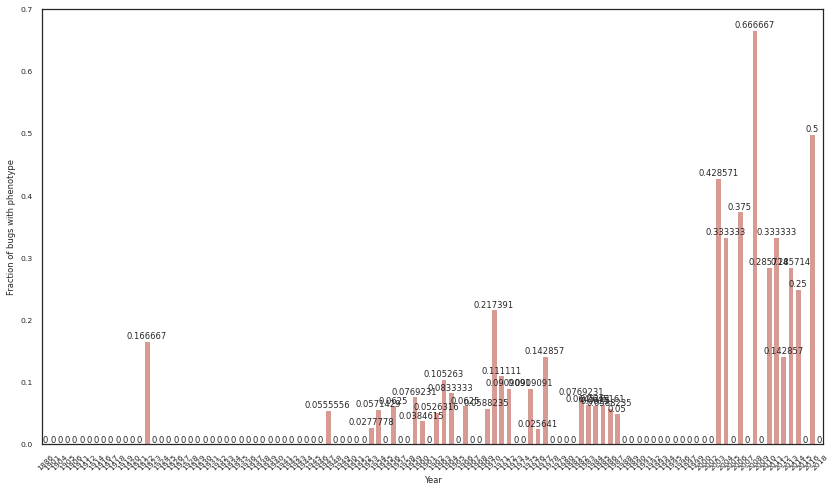

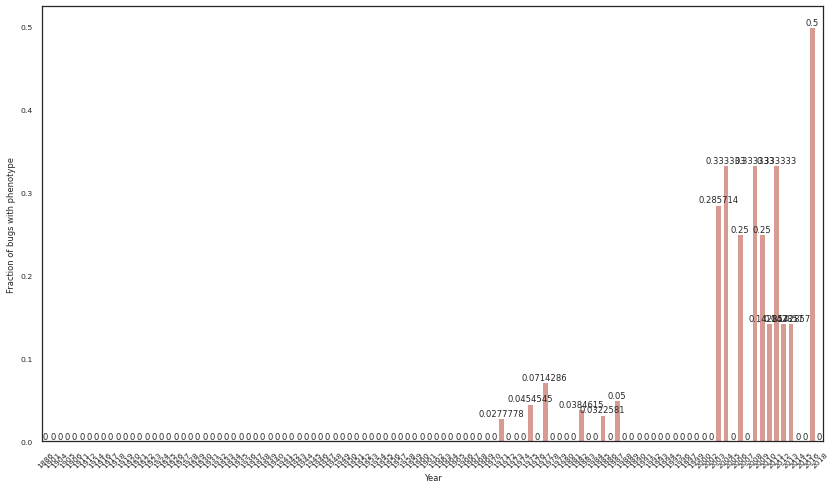

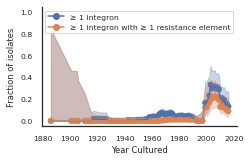

In [141]:
plot_abresist_frac_error_integrons(
    df1=integronsummary_df,
    df2=resistanceintegrons,  # Not used in this scenario
    ex1="YES",  # Filter for rows where `molecule_type` contains "plasmid"
    ex2="YES",  # Not used
    year=1923,  # First year in the dataset
    verbose=True,
    sims=100,
    figname="./figs/fig5/panelc_integronmobility",
    savefig=True,
    smooth=5,
    col1="integron_simp",
    col2="integron_simp",  # Not used
    value="phenotype",
)

## Panel D

In [142]:
# Get all contig reports
data_files = glob.glob(
    "/n/data1/hms/dbmi/baym/arya/projects/tools/callmemobile/intermediate/nctc-mtrawler/phigaro/raw/*/*.tsv"
)
# print(data_files)

dfs = []
for f in data_files:
    if os.stat(f).st_size > 0:
        indiv_df = pd.read_csv(f, sep="\t")
        indiv_df["filename"] = f
        indiv_df["sequence_number"] = f.split("/")[-2]
        dfs.append(indiv_df)

# Concatenate the DataFrames
phigaroout_df = pd.concat(dfs, ignore_index=True)
phigaroout_df

,scaffold,id,begin,end,transposable,taxonomy,filename,sequence_number
0,ENA|LR134481|LR134481.1,ENA|LR134481|LR134481.1_prophage1,852808,880152,False,Myoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1
1,ENA|LR134481|LR134481.1,ENA|LR134481|LR134481.1_prophage2,1591877,1632866,False,Siphoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1
2,ENA|LR134481|LR134481.1,ENA|LR134481|LR134481.1_prophage3,2006078,2012547,False,Unknown,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1
3,UHDB01000001.1,UHDB01000001.1_prophage1,1383564,1420756,False,Siphoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_10
4,ENA|CM003342|CM003342.1,ENA|CM003342|CM003342.1_prophage1,29634,48130,False,Siphoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_100
...,...,...,...,...,...,...,...,...
6457,UYIX01000011.1,UYIX01000011.1_prophage1,526101,538062,False,Siphoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_996
6458,UYIX01000011.1,UYIX01000011.1_prophage2,556785,578605,False,Siphoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_996
6459,UYIX01000011.1,UYIX01000011.1_prophage3,1429680,1464338,False,Siphoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_996
6460,UAWT01000007.1,UAWT01000007.1_prophage1,6943,11188,False,Unknown,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_999


In [143]:
input_callmemobile = pd.read_csv(
    "/n/data1/hms/dbmi/baym/arya/projects/tools/callmemobile/input/nctc-mtrawler.txt",
    names=["path"],
)

input_callmemobile["number"] = input_callmemobile.index + 1
input_callmemobile["sequence_number"] = input_callmemobile["number"].apply(
    lambda x: f"sequence_{x}"
)
input_callmemobile["accession_number"] = input_callmemobile["path"].apply(
    lambda x: x.split("/")[-3]
)
seqnum_to_accession_dict = input_callmemobile.set_index("sequence_number")[
    "accession_number"
].to_dict()

In [144]:
phigaroout_df["Accession_Number"] = phigaroout_df["sequence_number"].map(
    seqnum_to_accession_dict
)
phigaroout_df["prophage"] = "yes"

accession_numbers = single_acc_df[
    ~single_acc_df["Accession_Number"].isin(phigaroout_df["Accession_Number"])
]["Accession_Number"].values
# print(accession_numbers)
new_rows = pd.DataFrame({"Accession_Number": accession_numbers})
# new_rows[phigaroout_df.columns[1:]] = np.nan

phigaroout_df = pd.concat([phigaroout_df, new_rows], ignore_index=True)
phigaroout_df["Year_Cultured"] = phigaroout_df["Accession_Number"].map(year_dict)
phigaroout_df = phigaroout_df.dropna(subset=["Year_Cultured"])
phigaroout_df["Year_Cultured"] = phigaroout_df["Year_Cultured"].astype(int)
print(phigaroout_df.shape)
failed_qc = pd.read_csv(
    "/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/6_checkm2/failed_filter.tsv",
    sep="\t",
)
phigaroout_df = phigaroout_df[
    ~phigaroout_df["Accession_Number"].isin(failed_qc["NCTC_Isolate"])
]
print(phigaroout_df.shape)
phigaroout_df["Contig"] = phigaroout_df["scaffold"]
phigaroout_df["prophage"] = phigaroout_df["prophage"].fillna(value="no")
phigaroout_df

(6457, 11)
(6037, 11)


,scaffold,id,begin,end,transposable,taxonomy,filename,sequence_number,Accession_Number,prophage,Year_Cultured,Contig
0,ENA|LR134481|LR134481.1,ENA|LR134481|LR134481.1_prophage1,852808,880152,False,Myoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1,NCTC10665,yes,1969,ENA|LR134481|LR134481.1
1,ENA|LR134481|LR134481.1,ENA|LR134481|LR134481.1_prophage2,1591877,1632866,False,Siphoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1,NCTC10665,yes,1969,ENA|LR134481|LR134481.1
2,ENA|LR134481|LR134481.1,ENA|LR134481|LR134481.1_prophage3,2006078,2012547,False,Unknown,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1,NCTC10665,yes,1969,ENA|LR134481|LR134481.1
3,UHDB01000001.1,UHDB01000001.1_prophage1,1383564,1420756,False,Siphoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_10,NCTC10530,yes,1967,UHDB01000001.1
4,ENA|CM003342|CM003342.1,ENA|CM003342|CM003342.1_prophage1,29634,48130,False,Siphoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_100,NCTC9691,yes,1955,ENA|CM003342|CM003342.1
...,...,...,...,...,...,...,...,...,...,...,...,...
6735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NCTC13786,no,1997,NaN
6736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NCTC13807,no,2002,NaN
6737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NCTC13829,no,1995,NaN
6738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NCTC13836,no,1992,NaN


In [145]:
phigaroout_df[["begin", "end"]] = phigaroout_df[["begin", "end"]].apply(
    pd.to_numeric, errors="coerce"
)
df[["Start", "Stop"]] = df[["Start", "Stop"]].apply(pd.to_numeric, errors="coerce")

# Define a function to check proximity or containment with matching criteria
def identify_prophages_optimized(phigaroout_df, df, proximity=1000):
    results = []
    # Filter the dataframes for non-NaN `Accession_Number` and `scaffold/Contig`
    phigaroout_filtered = phigaroout_df.dropna(
        subset=["Accession_Number", "scaffold", "begin", "end"]
    )
    df_filtered = df.dropna(subset=["Accession_Number", "Contig", "Start", "Stop"])

    # Group by `Accession_Number` to optimize matching
    for acc_number, prophage_group in phigaroout_filtered.groupby("Accession_Number"):
        if acc_number not in df_filtered["Accession_Number"].values:
            continue

        resistance_group = df_filtered[df_filtered["Accession_Number"] == acc_number]

        # Further group by `scaffold`/`Contig`
        for scaffold, prophages in prophage_group.groupby("scaffold"):
            if scaffold not in resistance_group["Contig"].values:
                continue

            resistances = resistance_group[resistance_group["Contig"] == scaffold]

            # Check each prophage against resistance elements on the same contig
            for _, prophage in prophages.iterrows():
                prophage_begin = prophage["begin"]
                prophage_end = prophage["end"]

                for _, resistance in resistances.iterrows():
                    resistance_start = resistance["Start"]
                    resistance_stop = resistance["Stop"]

                    # Check proximity (within 1 kb)
                    if (abs(prophage_begin - resistance_stop) <= proximity) or (
                        abs(prophage_end - resistance_start) <= proximity
                    ):
                        results.append(prophage["id"])
                        break  # No need to check further for this prophage

                    # Check containment (prophage contains resistance element)
                    if (prophage_begin <= resistance_start <= prophage_end) and (
                        prophage_begin <= resistance_stop <= prophage_end
                    ):
                        results.append(prophage["id"])
                        break

    return list(set(results))


# Apply the function to identify relevant prophages
relevant_prophages = identify_prophages_optimized(phigaroout_df, df)
relevant_prophages_df = phigaroout_df[phigaroout_df["id"].isin(relevant_prophages)]

# relevant_prophages_df

phigaroout_df["resistance"] = "NO"
phigaroout_df.loc[phigaroout_df["id"].isin(relevant_prophages), "resistance"] = "YES"
phigaroout_df

,scaffold,id,begin,end,transposable,taxonomy,filename,sequence_number,Accession_Number,prophage,Year_Cultured,Contig,resistance
0,ENA|LR134481|LR134481.1,ENA|LR134481|LR134481.1_prophage1,852808.0,880152.0,False,Myoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1,NCTC10665,yes,1969,ENA|LR134481|LR134481.1,NO
1,ENA|LR134481|LR134481.1,ENA|LR134481|LR134481.1_prophage2,1591877.0,1632866.0,False,Siphoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1,NCTC10665,yes,1969,ENA|LR134481|LR134481.1,NO
2,ENA|LR134481|LR134481.1,ENA|LR134481|LR134481.1_prophage3,2006078.0,2012547.0,False,Unknown,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_1,NCTC10665,yes,1969,ENA|LR134481|LR134481.1,NO
3,UHDB01000001.1,UHDB01000001.1_prophage1,1383564.0,1420756.0,False,Siphoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_10,NCTC10530,yes,1967,UHDB01000001.1,NO
4,ENA|CM003342|CM003342.1,ENA|CM003342|CM003342.1_prophage1,29634.0,48130.0,False,Siphoviridae,/n/data1/hms/dbmi/baym/arya/projects/tools/cal...,sequence_100,NCTC9691,yes,1955,ENA|CM003342|CM003342.1,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NCTC13786,no,1997,NaN,NO
6736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NCTC13807,no,2002,NaN,NO
6737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NCTC13829,no,1995,NaN,NO
6738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NCTC13836,no,1992,NaN,NO


In [146]:
resistanceprophages = pd.merge(
    mobility_df,
    phigaroout_df,
    on=["Contig", "Accession_Number", "Year_Cultured"],
    how="inner",
    indicator=True,
)
resistanceprophages[["_merge"]].value_counts()

_merge    
both          126305
left_only          0
right_only         0
dtype: int64

In [147]:
phigaroout_df["prophage"].value_counts()

yes    5770
no      267
Name: prophage, dtype: int64

In [148]:
resistance_prophages = pd.merge(
    df,
    phigaroout_df,
    on=["Contig", "Accession_Number", "Year_Cultured"],
    how="outer",
    indicator=True,
)
resistance_prophages["_merge"].value_counts()

both          126305
left_only       3666
right_only       932
Name: _merge, dtype: int64

In [149]:
import scipy.stats as stats
from scipy.stats import binom


def measure_obs_distance(
    dataframe, value, anthro_year, column, sums=False, verbose=False
):
    num_yearcultured_allstrains_dict = (
        dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    num_yearcultured_valposstrains_dict = (
        dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
        .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
        .value_counts()
        .to_dict()
    )
    fractional_dictionary = {}
    for years in num_yearcultured_allstrains_dict:
        if num_yearcultured_allstrains_dict[years] == 0:
            continue
        if years in num_yearcultured_valposstrains_dict:
            val = [
                num_yearcultured_valposstrains_dict[years],
                num_yearcultured_allstrains_dict[years],
            ]
        else:
            val = [0, num_yearcultured_allstrains_dict[years]]
        fractional_dictionary[years] = val

    yeardf = (
        pd.DataFrame.from_dict(
            fractional_dictionary, orient="index", columns=["num_pos", "all"]
        )
        .reset_index()
        .rename(columns={"index": "year"})
        .sort_values(by="year")
        .reset_index(drop=True)
    )
    yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
    if verbose:
        print(yeardf)
    anthro = {True: "Pre-Human", False: "Post-Human"}
    yeardf["Anthropogenicity"] = "Pre-Human"
    yeardf.loc[yeardf["year"] > anthro_year, "Anthropogenicity"] = "Post-Human"

    preanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Pre-Human"][
        "frac"
    ].mean()
    postanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Post-Human"][
        "frac"
    ].mean()
    metric = postanthro_mean - preanthro_mean
    return yeardf, preanthro_mean, postanthro_mean


def calculate_frequency_bounds(row, confidence=0.95):
    successes = row["num_pos"]
    attempts = row["all"]
    freq = row["num_pos"] / row["all"]
    alpha = successes + 1
    beta = attempts - successes + 1
    lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
    return (lower_b, upper_b)


def plot_abresist_frac_error_prophages(
    df1,
    df2,
    ex1,
    ex2,
    year,
    verbose=True,
    sims=100,
    figname="doodoo",
    savefig=False,
    smooth=5,
    col1="Drug Class",
    col2="Drug Class",
    value="phenotype",
):

    sns.set_theme(font="Arial", style="white", font_scale=0.7)

    frac_df1, pre, post = measure_obs_distance(df1, ex1, 0, col1, verbose)
    frac_df2, pre, post = measure_obs_distance(df2, ex2, 0, col2, verbose)

    # print(frac_df)

    # histogram of fraction of strains w/ RGI hits for drug class
    plt.figure(figsize=(14, 8))
    chart = sns.barplot(
        data=frac_df1, x="year", y="frac", color="salmon", saturation=0.5
    )
    chart.bar_label(chart.containers[0])

    # plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
    plt.ylabel("Fraction of bugs with phenotype")
    plt.xlabel("Year")
    plt.xticks(rotation=45)

    plt.show()
    # histogram of fraction of strains w/ RGI hits for drug class
    plt.figure(figsize=(14, 8))
    chart = sns.barplot(
        data=frac_df2, x="year", y="frac", color="salmon", saturation=0.5
    )
    chart.bar_label(chart.containers[0])

    # plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
    plt.ylabel("Fraction of bugs with phenotype")
    plt.xlabel("Year")
    plt.xticks(rotation=45)

    plt.show()

    d = {"Year": [], "num_pos": [], "all": []}
    for years in range(frac_df1["year"].min(), frac_df1["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df1.loc[(frac_df1["year"] <= upb) & (downb <= frac_df1["year"])]
        if years not in frac_df1["year"].values:
            continue
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
        d["Year"].append(years)
    xdf1 = pd.DataFrame(data=d)
    # print(xdf)
    xdf1["frac"] = xdf1["num_pos"] / xdf1["all"]
    xdf1[["lower-error", "upper-error"]] = xdf1.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    d = {"Year": [], "num_pos": [], "all": []}
    for years in range(frac_df2["year"].min(), frac_df2["year"].max()):
        upb = smooth + years
        downb = years - smooth
        g = frac_df2.loc[(frac_df2["year"] <= upb) & (downb <= frac_df2["year"])]
        if years not in frac_df2["year"].values:
            continue
        d["num_pos"].append(g["num_pos"].sum())
        d["all"].append(g["all"].sum())
        d["Year"].append(years)
    xdf2 = pd.DataFrame(data=d)
    # print(xdf)
    xdf2["frac"] = xdf2["num_pos"] / xdf2["all"]
    xdf2[["lower-error", "upper-error"]] = xdf2.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    fig1, ax1 = plt.subplots(figsize=(14, 8))
    # ax2 = ax1.twinx()  # Create a second y-axis

    # make subplots for the figure
    ax1.set(xlabel="Year Cultured")
    lp = sns.lineplot(
        data=xdf1,
        x="Year",
        y="frac",
        markers=True,
        ax=ax1,
    )
    # lp.set(ylim=(0, 1))
    dp = sns.scatterplot(
        data=xdf1,
        x="Year",
        y="frac",
        legend=False,
        ax=ax1,
        edgecolor="none",
    )
    plt.fill_between(
        xdf1["Year"],
        xdf1["lower-error"],
        xdf1["upper-error"],
        alpha=0.3,
        edgecolor=sns.color_palette("deep")[0],
        facecolor=sns.color_palette("deep")[0],
    )

    # make subplots for the figure
    # ax2.set(xlabel="Year Cultured")
    lp = sns.lineplot(
        data=xdf2,
        x="Year",
        y="frac",
        markers=True,
        ax=ax1,
        color=sns.color_palette("deep")[1],
    )
    # lp.set(ylim=(0, 1))
    dp = sns.scatterplot(
        data=xdf2,
        x="Year",
        y="frac",
        legend=False,
        ax=ax1,
        edgecolor="none",
        facecolor=sns.color_palette("deep")[1],
    )
    plt.fill_between(
        xdf2["Year"],
        xdf2["lower-error"],
        xdf2["upper-error"],
        alpha=0.3,
        edgecolor=sns.color_palette("deep")[1],
        facecolor=sns.color_palette("deep")[1],
    )

    ax1.set_ylabel("Fraction of isolates")
    # ax2.set_ylabel(
    #     "Fraction of integrons with\n≥ 1 resistance allele",
    #     color=sns.color_palette("deep")[1],
    # )
    ax1.set(ylim=(-0.05, 1.05))
    sns.despine()
    # ax1.set(ylabel="Fraction of isolates with {}".format(value))
    # Manually create legend
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color=sns.color_palette("deep")[0],
            label="≥ 1 prophage",
            markerfacecolor=sns.color_palette("deep")[0],
            # markersize=10,
        ),
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color=sns.color_palette("deep")[1],
            label="≥ 1 prophage with ≥ 1 resistance element",
            markerfacecolor=sns.color_palette("deep")[1],
            # markersize=10,
        ),
    ]

    plt.legend(handles=legend_elements)
    if savefig:
        plt.gcf().set_size_inches(3.5, 2.2)
        plt.savefig(
            "{}-fractionofresist.svg".format(figname),
            bbox_inches="tight",
            dpi=300,
        )

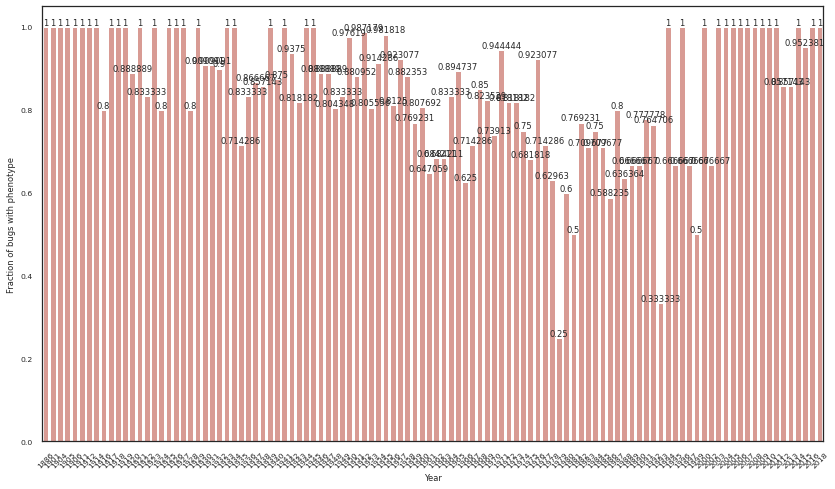

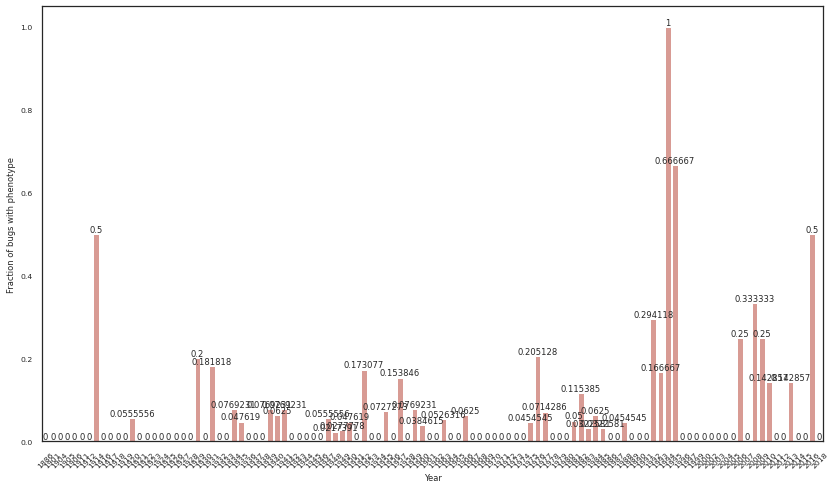

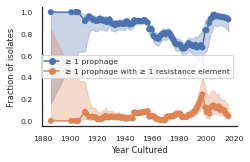

In [150]:
plot_abresist_frac_error_prophages(
    df1=phigaroout_df,
    df2=phigaroout_df,  # Not used in this scenario
    ex1="yes",  # Filter for rows where `molecule_type` contains "plasmid"
    ex2="YES",  # Not used
    year=1923,  # First year in the dataset
    verbose=True,
    sims=100,
    figname="./figs/fig5/paneld_prophagemobility",
    savefig=True,
    smooth=5,
    col1="prophage",
    col2="resistance",  # Not used
    value="phenotype",
)

## Panel E

In [186]:
mobility_df

,Accession_Number,Species_Name,Best_Hit_ARO,Resistance Mechanism,AMR Gene Family,Drug Class,Year_Cultured,IntegronFinder,PlasmidFinder,mob_suite,phigaro,mobileelementfinder,Contig,Mobile,me_simp,integron_simp,plasmid_simp,plasmidtype_simp,prophage_simp,prophagetype_simp
0,NCTC1,S. flexneri,vanG,antibiotic target alteration,glycopeptide resistance gene cluster; Van ligase,glycopeptide antibiotic,1914,no,no,no,vanG|near-prophage,vanG|overlaps-IS,ENA|LM651928|LM651928.1,mobileelement|no-integron|no-plasmid|Prophage ...,mobileelement,no-integron,no-plasmid,no-plasmid,Prophage associated,Near prophage
1,NCTC1,S. flexneri,acrB,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,fluoroquinolone antibiotic; cephalosporin; gly...,1914,no,no,no,no,no,ENA|LM651928|LM651928.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
2,NCTC1,S. flexneri,Escherichia coli acrA,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,fluoroquinolone antibiotic; cephalosporin; gly...,1914,no,no,no,no,no,ENA|LM651928|LM651928.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
3,NCTC1,S. flexneri,msbA,antibiotic efflux,ATP-binding cassette (ABC) antibiotic efflux pump,nitroimidazole antibiotic,1914,no,no,no,no,msbA|overlaps-IS,ENA|LM651928|LM651928.1,mobileelement|no-integron|no-plasmid|no-prophage,mobileelement,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
4,NCTC1,S. flexneri,mdtH,antibiotic efflux,major facilitator superfamily (MFS) antibiotic...,fluoroquinolone antibiotic,1914,no,no,no,no,no,ENA|LM651928|LM651928.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29657,NCTC14382,Y. canariae,evgA,antibiotic efflux,major facilitator superfamily (MFS) antibiotic...,macrolide antibiotic; fluoroquinolone antibiot...,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
29658,NCTC14382,Y. canariae,CRP,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,macrolide antibiotic; fluoroquinolone antibiot...,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
29659,NCTC14382,Y. canariae,Haemophilus influenzae PBP3 conferring resista...,antibiotic target alteration,Penicillin-binding protein mutations conferrin...,cephalosporin; cephamycin; penam,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage
29660,NCTC14382,Y. canariae,Escherichia coli EF-Tu mutants conferring resi...,antibiotic target alteration,elfamycin resistant EF-Tu,elfamycin antibiotic,2018,no,no,no,no,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage


In [12]:
# Define a function to count mobility elements
def count_mobility_elements(row):
    count = 0
    if row["me_simp"] == "mobileelement":
        count += 1
    if row["integron_simp"] == "Integron associated":
        count += 1
    if row["plasmid_simp"] == "Plasmid associated":
        count += 1
    if row["prophage_simp"] == "Prophage associated":
        count += 1
    return count


# Apply the function row-wise to create the new column
mobility_df["nested_mobility"] = mobility_df.apply(count_mobility_elements, axis=1)

In [13]:
mobility_df["nested_mobility"].value_counts()

0    27938
1     1487
2      197
3       39
4        1
Name: nested_mobility, dtype: int64

In [14]:
mobility_df[["Accession_Number", "Year_Cultured", "nested_mobility"]]

,Accession_Number,Year_Cultured,nested_mobility
0,NCTC1,1914,2
1,NCTC1,1914,0
2,NCTC1,1914,0
3,NCTC1,1914,1
4,NCTC1,1914,0
...,...,...,...
29657,NCTC14382,2018,0
29658,NCTC14382,2018,0
29659,NCTC14382,2018,0
29660,NCTC14382,2018,0


In [15]:
mobility_df.loc[mobility_df["nested_mobility"] == 4]

,Accession_Number,Species_Name,Best_Hit_ARO,Resistance Mechanism,AMR Gene Family,Drug Class,Year_Cultured,IntegronFinder,PlasmidFinder,mob_suite,...,mobileelementfinder,Contig,Mobile,me_simp,integron_simp,plasmid_simp,plasmidtype_simp,prophage_simp,prophagetype_simp,nested_mobility
27383,NCTC13440,K. pneumoniae,dfrA14,antibiotic target replacement,trimethoprim resistant dihydrofolate reductase...,diaminopyrimidine antibiotic,2008,dfrA14|complete,no,dfrA14|plasmid-contig:AA552|conjugative,...,dfrA14|overlaps-IS,UGKX01000002.1,mobileelement|Integron associated|Plasmid asso...,mobileelement,Integron associated,Plasmid associated,conjugative,Prophage associated,Near prophage,4


In [198]:
import matplotlib.lines as mlines


def calculate_frequency_bounds(row, confidence=0.95):
    successes = row["num_pos"]
    attempts = row["all"]
    freq = successes / attempts
    alpha = successes + 1
    beta = attempts - successes + 1
    lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
    return (lower_b, upper_b)


def plot_resistance_elements_fraction_with_smoothing(
    dataframe,
    year_column="Year_Cultured",
    mobility_column="nested_mobility",
    confidence=0.95,
    smooth=5,
    figname="nested_mobility",
    savefig=False,
):
    sns.set_theme(style="white", font_scale=0.7)

    # Calculate 'num_pos' and 'all' without dropping duplicates
    dataframe["count"] = 1
    aggregated_data = (
        dataframe.groupby([year_column, mobility_column])
        .agg(num_pos=("count", "sum"))
        .reset_index()
    )
    year_totals = dataframe.groupby(year_column)["count"].sum().reset_index(name="all")
    aggregated_data = pd.merge(aggregated_data, year_totals, on=year_column)
    aggregated_data["frac"] = aggregated_data["num_pos"] / aggregated_data["all"]
    aggregated_data[["lower_error", "upper_error"]] = aggregated_data.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    aggregated_data = aggregated_data[aggregated_data[mobility_column].isin([1, 2, 3, 4])]

    # Smooth fractions and errors
    for mobility in aggregated_data[mobility_column].unique():
        mobility_mask = aggregated_data[mobility_column] == mobility
        for col in ["frac", "lower_error", "upper_error"]:
            aggregated_data.loc[mobility_mask, col] = (
                aggregated_data.loc[mobility_mask]
                .rolling(window=smooth, on=year_column, min_periods=1, center=True)[col]
                .mean()
            )

    # Plot
    plt.figure(figsize=(14, 8))
    mobility_categories = aggregated_data[mobility_column].unique()
    palette = sns.color_palette("deep", n_colors=len(mobility_categories))
    mobility_color_map = dict(zip(mobility_categories, palette))

    for mobility in mobility_categories:
        subset = aggregated_data[aggregated_data[mobility_column] == mobility]
        plt.plot(
            subset[year_column],
            subset["frac"],
            label=f"{mobility}",
            color=mobility_color_map[mobility],
        )
        plt.fill_between(
            subset[year_column],
            subset["lower_error"],
            subset["upper_error"],
            color=mobility_color_map[mobility],
            alpha=0.3,
        )
        plt.scatter(
            subset[year_column],
            subset["frac"],
            color=mobility_color_map[mobility],
            edgecolor="none",
        )  # Add points

    plt.xlabel("Year Cultured")
    plt.ylabel("Fraction of genomic resistance elements")
    plt.title("")
    legend_handles = [
        plt.Line2D(
            [0],
            [0],
            color=mobility_color_map[mobility],
            marker="o",
            markerfacecolor=mobility_color_map[mobility],
            # linestyle="None",
            label=f"{mobility}",
        )
        for mobility in mobility_categories
    ]
    
    # Add the custom legend to the plot
    plt.legend(
        handles=legend_handles,
        title="Count of mobility types\n  associated with",
        loc="upper left",
    )
    # plt.legend(title='Number of mobile element\ntypes associated with')
    sns.despine()

    if savefig:
        plt.gcf().set_size_inches(5.0, 3)
        plt.savefig(f"./figs/fig5/{figname}.svg", dpi=300, bbox_inches="tight")
    plt.show()

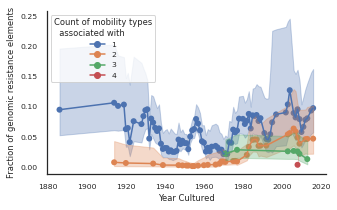

In [199]:
plot_resistance_elements_fraction_with_smoothing(mobility_df, savefig=True)

# Supp Fig 4 - Mobility Combinations

In [31]:
mobility_df

,Accession_Number,Species_Name,Best_Hit_ARO,Resistance Mechanism,AMR Gene Family,Drug Class,Year_Cultured,IntegronFinder,PlasmidFinder,mob_suite,...,mobileelementfinder,Contig,Mobile,me_simp,integron_simp,plasmid_simp,plasmidtype_simp,prophage_simp,prophagetype_simp,nested_mobility
0,NCTC1,S. flexneri,vanG,antibiotic target alteration,glycopeptide resistance gene cluster; Van ligase,glycopeptide antibiotic,1914,no,no,no,...,vanG|overlaps-IS,ENA|LM651928|LM651928.1,mobileelement|no-integron|no-plasmid|Prophage ...,mobileelement,no-integron,no-plasmid,no-plasmid,Prophage associated,Near prophage,2
1,NCTC1,S. flexneri,acrB,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,fluoroquinolone antibiotic; cephalosporin; gly...,1914,no,no,no,...,no,ENA|LM651928|LM651928.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,0
2,NCTC1,S. flexneri,Escherichia coli acrA,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,fluoroquinolone antibiotic; cephalosporin; gly...,1914,no,no,no,...,no,ENA|LM651928|LM651928.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,0
3,NCTC1,S. flexneri,msbA,antibiotic efflux,ATP-binding cassette (ABC) antibiotic efflux pump,nitroimidazole antibiotic,1914,no,no,no,...,msbA|overlaps-IS,ENA|LM651928|LM651928.1,mobileelement|no-integron|no-plasmid|no-prophage,mobileelement,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,1
4,NCTC1,S. flexneri,mdtH,antibiotic efflux,major facilitator superfamily (MFS) antibiotic...,fluoroquinolone antibiotic,1914,no,no,no,...,no,ENA|LM651928|LM651928.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29657,NCTC14382,Y. canariae,evgA,antibiotic efflux,major facilitator superfamily (MFS) antibiotic...,macrolide antibiotic; fluoroquinolone antibiot...,2018,no,no,no,...,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,0
29658,NCTC14382,Y. canariae,CRP,antibiotic efflux,resistance-nodulation-cell division (RND) anti...,macrolide antibiotic; fluoroquinolone antibiot...,2018,no,no,no,...,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,0
29659,NCTC14382,Y. canariae,Haemophilus influenzae PBP3 conferring resista...,antibiotic target alteration,Penicillin-binding protein mutations conferrin...,cephalosporin; cephamycin; penam,2018,no,no,no,...,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,0
29660,NCTC14382,Y. canariae,Escherichia coli EF-Tu mutants conferring resi...,antibiotic target alteration,elfamycin resistant EF-Tu,elfamycin antibiotic,2018,no,no,no,...,no,ENA|CP043727|CP043727.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,0


In [32]:
mobility_df["Mobility_Combination"] = (
    mobility_df["Mobile"]
    .replace({"no-me": "", "no-integron": "", "no-plasmid": "", "no-prophage": ""}, regex=True)
    .replace("\|+", "|", regex=True)
    .str.strip("|")
    .replace(
        {
            "mobileelement": "TN/IS associated",
        },
        regex=True,
    )
    .str.replace("|", " & ")
)
mobility_df['Mobility_Combination'].value_counts()
# Apply the function row-wise to create the new column
# mobility_df["nested_mobility"] = mobility_df.apply(count_mobility_elements, axis=1)

/tmp/ipykernel_5534/1334273083.py:2: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



                                                                                     27938
TN/IS associated                                                                      1247
Plasmid associated                                                                     146
TN/IS associated & Plasmid associated                                                  140
Prophage associated                                                                     85
TN/IS associated & Integron associated & Plasmid associated                             39
Integron associated & Plasmid associated                                                26
TN/IS associated & Prophage associated                                                  18
TN/IS associated & Integron associated                                                  13
Integron associated                                                                      9
TN/IS associated & Integron associated & Plasmid associated & Prophage associated        1

/tmp/ipykernel_5534/2682876931.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



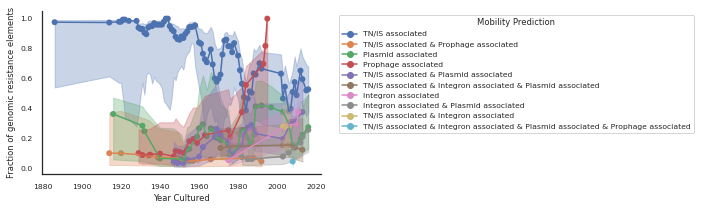

In [33]:
def plot_mobility_combinations(
    df,
    year_column="Year_Cultured",
    combination_column="plasmid_simp",
    confidence=0.95,
    smooth=5,
    figname="nested_mobility_supp",
    savefig=False,
):
    sns.set_theme(style="white", font_scale=0.7)

    # Aggregate data
    df["count"] = 1
    aggregated_data = (
        df.groupby([year_column, combination_column])
        .agg(num_pos=("count", "sum"))
        .reset_index()
    )
    year_totals = df.groupby(year_column)["count"].sum().reset_index(name="all")
    aggregated_data = pd.merge(aggregated_data, year_totals, on=year_column)
    aggregated_data["frac"] = aggregated_data["num_pos"] / aggregated_data["all"]
    aggregated_data[["lower_error", "upper_error"]] = aggregated_data.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    # Apply smoothing
    combinations = aggregated_data[combination_column].unique()
    for combination in combinations:
        mask = aggregated_data[combination_column] == combination
        for col in ["frac", "lower_error", "upper_error"]:
            aggregated_data.loc[mask, col] = (
                aggregated_data.loc[mask]
                .rolling(window=smooth, on=year_column, min_periods=1, center=True)[col]
                .mean()
            )

    # Plot
    plt.figure(figsize=(14, 8))
    palette = sns.color_palette("deep", n_colors=len(combinations))
    combination_color_map = dict(zip(combinations, palette))

    for combination in combinations:
        subset = aggregated_data[aggregated_data[combination_column] == combination]
        plt.plot(
            subset[year_column],
            subset["frac"],
            label=f"{combination}",
            color=combination_color_map[combination],
        )
        plt.scatter(
            subset[year_column],
            subset["frac"],
            color=combination_color_map[combination],
            edgecolor="none",
        )
        plt.fill_between(
            subset[year_column],
            subset["lower_error"],
            subset["upper_error"],
            color=combination_color_map[combination],
            alpha=0.3,
        )

    
    legend_elements = [
        plt.Line2D(
            [0], [0],
            color=combination_color_map[comb],
            marker="o",
            markersize=6,
            label=comb,
            linestyle="-",
        )
        for comb in combinations
    ]
    plt.xlabel("Year Cultured")
    plt.ylabel("Fraction of genomic resistance elements")
    plt.legend(
        handles=legend_elements,
        title="Mobility Prediction",
        loc="upper left",
        bbox_to_anchor=(1.05, 1),
    )
    sns.despine()
    plt.xlabel("Year Cultured")
    plt.ylabel("Fraction of genomic resistance elements")
    plt.title("")
    # legend_handles, _= plt.get_legend_handles_labels()
    
    # plt.legend(title="Mobility Prediction", loc="upper left", bbox_to_anchor=(1.05, 1))
    sns.despine()

    if savefig:
        plt.gcf().set_size_inches(5.0, 3)
        plt.savefig(
            f"./figs/fig5/{figname}.svg", dpi=300, bbox_inches="tight", transparent=True
        )
    plt.show()


plot_mobility_combinations(
    mobility_df.loc[mobility_df['Mobility_Combination'] != ""],
    combination_column="Mobility_Combination",
    savefig=True,
    figname="suppfig_mobilitycombo",
)

# Supp Fig 5 - beta lactamases

In [34]:
betalactamase_mobility_df = mobility_df[
    mobility_df["AMR Gene Family"].str.contains("beta-lactamase")
].copy()
betalactamase_mobility_df

,Accession_Number,Species_Name,Best_Hit_ARO,Resistance Mechanism,AMR Gene Family,Drug Class,Year_Cultured,IntegronFinder,PlasmidFinder,mob_suite,...,Contig,Mobile,me_simp,integron_simp,plasmid_simp,plasmidtype_simp,prophage_simp,prophagetype_simp,nested_mobility,Mobility_Combination
33,NCTC1,S. flexneri,Escherichia coli ampC beta-lactamase,antibiotic inactivation,ampC-type beta-lactamase,cephalosporin; penam,1914,no,no,no,...,ENA|LM651928|LM651928.1,mobileelement|no-integron|no-plasmid|no-prophage,mobileelement,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,1,TN/IS associated
47,NCTC2,S. flexneri,Escherichia coli ampC beta-lactamase,antibiotic inactivation,ampC-type beta-lactamase,cephalosporin; penam,1920,no,no,no,...,UGYS01000001.1,mobileelement|no-integron|no-plasmid|no-prophage,mobileelement,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,1,TN/IS associated
115,NCTC5,S. flexneri,Escherichia coli ampC beta-lactamase,antibiotic inactivation,ampC-type beta-lactamase,cephalosporin; penam,1919,no,no,no,...,UGYU01000001.1,mobileelement|no-integron|no-plasmid|no-prophage,mobileelement,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,1,TN/IS associated
218,NCTC86,E. coli,Escherichia coli ampC beta-lactamase,antibiotic inactivation,ampC-type beta-lactamase,cephalosporin; penam,1886,no,no,no,...,ENA|LR217818|LR217818.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,0,
315,NCTC122,E. coli,EC-14,antibiotic inactivation,EC beta-lactamase,cephalosporin,1920,no,no,no,...,ENA|LT906474|LT906474.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29523,NCTC13919,E. coli,EC-8,antibiotic inactivation,EC beta-lactamase,cephalosporin,2016,no,no,no,...,UARQ01000007.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,0,
29572,NCTC13921,P. aeruginosa,OXA-56,antibiotic inactivation,OXA beta-lactamase,carbapenem; cephalosporin; penam,2013,no,no,no,...,UAUD01000015.1,mobileelement|no-integron|no-plasmid|no-prophage,mobileelement,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,1,TN/IS associated
29582,NCTC13921,P. aeruginosa,OXA-494,antibiotic inactivation,OXA beta-lactamase,carbapenem; cephalosporin; penam,2013,no,no,no,...,UAUD01000005.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,0,
29602,NCTC13921,P. aeruginosa,PDC-5,antibiotic inactivation,PDC beta-lactamase,monobactam; carbapenem; cephalosporin; cephamy...,2013,no,no,no,...,UAUD01000007.1,no-me|no-integron|no-plasmid|no-prophage,no-me,no-integron,no-plasmid,no-plasmid,no-prophage,no-prophage,0,


In [35]:
betalactamase_mobility_df['nested_mobility'].value_counts()

0    622
1    103
2     48
3      2
Name: nested_mobility, dtype: int64

## Panel A

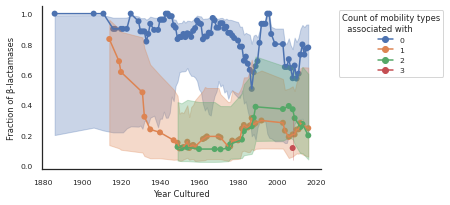

In [36]:
import matplotlib.lines as mlines


def calculate_frequency_bounds(row, confidence=0.95):
    successes = row["num_pos"]
    attempts = row["all"]
    freq = successes / attempts
    alpha = successes + 1
    beta = attempts - successes + 1
    lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
    return (lower_b, upper_b)


def plot_resistance_elements_fraction_with_smoothing(
    dataframe,
    year_column="Year_Cultured",
    mobility_column="nested_mobility",
    confidence=0.95,
    smooth=5,
    figname="nested_mobility",
    savefig=False,
):
    sns.set_theme(style="white", font_scale=0.7)

    # Calculate 'num_pos' and 'all' without dropping duplicates
    dataframe["count"] = 1
    aggregated_data = (
        dataframe.groupby([year_column, mobility_column])
        .agg(num_pos=("count", "sum"))
        .reset_index()
    )
    year_totals = dataframe.groupby(year_column)["count"].sum().reset_index(name="all")
    aggregated_data = pd.merge(aggregated_data, year_totals, on=year_column)
    aggregated_data["frac"] = aggregated_data["num_pos"] / aggregated_data["all"]
    aggregated_data[["lower_error", "upper_error"]] = aggregated_data.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    aggregated_data = aggregated_data[
        aggregated_data[mobility_column].isin([0, 1, 2, 3])
    ]

    # Smooth fractions and errors
    for mobility in aggregated_data[mobility_column].unique():
        mobility_mask = aggregated_data[mobility_column] == mobility
        for col in ["frac", "lower_error", "upper_error"]:
            aggregated_data.loc[mobility_mask, col] = (
                aggregated_data.loc[mobility_mask]
                .rolling(window=smooth, on=year_column, min_periods=1, center=True)[col]
                .mean()
            )

    # Plot
    plt.figure(figsize=(14, 8))
    mobility_categories = aggregated_data[mobility_column].unique()
    palette = sns.color_palette("deep", n_colors=len(mobility_categories))
    mobility_color_map = dict(zip(mobility_categories, palette))

    for mobility in mobility_categories:
        subset = aggregated_data[aggregated_data[mobility_column] == mobility]
        plt.plot(
            subset[year_column],
            subset["frac"],
            label=f"{mobility}",
            color=mobility_color_map[mobility],
        )
        plt.fill_between(
            subset[year_column],
            subset["lower_error"],
            subset["upper_error"],
            color=mobility_color_map[mobility],
            alpha=0.3,
        )
        plt.scatter(
            subset[year_column],
            subset["frac"],
            color=mobility_color_map[mobility],
            edgecolor="none",
        )  # Add points

    plt.xlabel("Year Cultured")
    plt.ylabel("Fraction of β-lactamases")
    plt.title("")
    legend_handles = [
        plt.Line2D(
            [0],
            [0],
            color=mobility_color_map[mobility],
            marker="o",
            # linestyle="None",
            label=f"{mobility}",
        )
        for mobility in mobility_categories
    ]

    # Add the custom legend to the plot
    plt.legend(
        handles=legend_handles,
        title="Count of mobility types\n  associated with",
        loc="upper left",
        bbox_to_anchor=(1.05, 1),
    )
    # plt.legend(title='Number of mobile element\ntypes associated with')
    sns.despine()

    if savefig:
        plt.gcf().set_size_inches(5.0, 3)
        plt.savefig(f"./figs/fig5/{figname}.svg", dpi=300, bbox_inches="tight")
    plt.show()


plot_resistance_elements_fraction_with_smoothing(
    betalactamase_mobility_df, figname="blactamase_suppfig_mobilitycount", savefig=True
)

## Panel B

In [37]:
betalactamase_mobility_df["Mobility_Combination"] = betalactamase_mobility_df["Mobility_Combination"].replace("", "Immobile")
betalactamase_mobility_df['Mobility_Combination'].value_counts()

Immobile                                                       622
Plasmid associated                                              53
TN/IS associated                                                46
TN/IS associated & Plasmid associated                           45
Integron associated                                              4
Integron associated & Plasmid associated                         3
TN/IS associated & Integron associated & Plasmid associated      2
Name: Mobility_Combination, dtype: int64

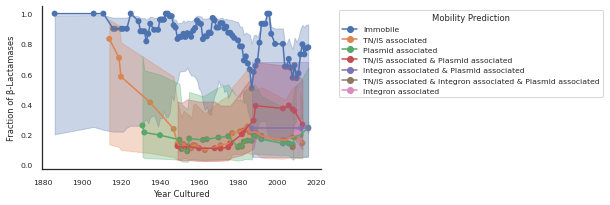

In [38]:
def plot_mobility_combinations(
    df,
    year_column="Year_Cultured",
    combination_column="plasmid_simp",
    confidence=0.95,
    smooth=5,
    figname="nested_mobility_supp",
    savefig=False,
):
    sns.set_theme(style="white", font_scale=0.7)

    # Aggregate data
    df["count"] = 1
    aggregated_data = (
        df.groupby([year_column, combination_column])
        .agg(num_pos=("count", "sum"))
        .reset_index()
    )
    year_totals = df.groupby(year_column)["count"].sum().reset_index(name="all")
    aggregated_data = pd.merge(aggregated_data, year_totals, on=year_column)
    aggregated_data["frac"] = aggregated_data["num_pos"] / aggregated_data["all"]
    aggregated_data[["lower_error", "upper_error"]] = aggregated_data.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    # Apply smoothing
    combinations = aggregated_data[combination_column].unique()
    for combination in combinations:
        mask = aggregated_data[combination_column] == combination
        for col in ["frac", "lower_error", "upper_error"]:
            aggregated_data.loc[mask, col] = (
                aggregated_data.loc[mask]
                .rolling(window=smooth, on=year_column, min_periods=1, center=True)[col]
                .mean()
            )

    # Plot
    plt.figure(figsize=(14, 8))
    palette = sns.color_palette("deep", n_colors=len(combinations))
    combination_color_map = dict(zip(combinations, palette))

    for combination in combinations:
        subset = aggregated_data[aggregated_data[combination_column] == combination]
        plt.plot(
            subset[year_column],
            subset["frac"],
            label=f"{combination}",
            color=combination_color_map[combination],
        )
        plt.scatter(
            subset[year_column],
            subset["frac"],
            color=combination_color_map[combination],
            edgecolor="none",
        )
        plt.fill_between(
            subset[year_column],
            subset["lower_error"],
            subset["upper_error"],
            color=combination_color_map[combination],
            alpha=0.3,
        )

    
    legend_elements = [
        plt.Line2D(
            [0], [0],
            color=combination_color_map[comb],
            marker="o",
            markersize=6,
            label=comb,
            linestyle="-",
        )
        for comb in combinations
    ]
    plt.xlabel("Year Cultured")
    plt.ylabel("Fraction of β-Lactamases")
    plt.legend(
        handles=legend_elements,
        title="Mobility Prediction",
        loc="upper left",
        bbox_to_anchor=(1.05, 1),
    )
    sns.despine()
    plt.xlabel("Year Cultured")
    plt.ylabel("Fraction of β-Lactamases")
    plt.title("")
    # legend_handles, _= plt.get_legend_handles_labels()
    
    # plt.legend(title="Mobility Prediction", loc="upper left", bbox_to_anchor=(1.05, 1))
    sns.despine()

    if savefig:
        plt.gcf().set_size_inches(5.0, 3)
        plt.savefig(
            f"./figs/fig5/{figname}.svg", dpi=300, bbox_inches="tight", transparent=True
        )
    plt.show()


plot_mobility_combinations(
    betalactamase_mobility_df,
    combination_column="Mobility_Combination",
    savefig=True,
    figname="blactamase_suppfig_mobilitycombo",
)

## Panel C

In [39]:
betalactamase_mobility_df['Mobility_Combination'].value_counts()

Immobile                                                       622
Plasmid associated                                              53
TN/IS associated                                                46
TN/IS associated & Plasmid associated                           45
Integron associated                                              4
Integron associated & Plasmid associated                         3
TN/IS associated & Integron associated & Plasmid associated      2
Name: Mobility_Combination, dtype: int64

In [40]:
betalactamase_mobility_df['Plasmid-Assoc'] = "Not plasmid associated"
betalactamase_mobility_df.loc[
    betalactamase_mobility_df["Mobile"].str.contains("Plasmid"), "Plasmid-Assoc"
] = "Plasmid associated"
betalactamase_mobility_df['Plasmid-Assoc'].value_counts()

Not plasmid associated    672
Plasmid associated        103
Name: Plasmid-Assoc, dtype: int64

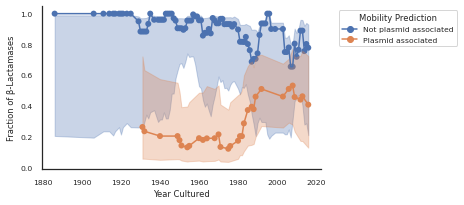

In [41]:
def plot_mobility_combinations_plasmid(
    df,
    year_column="Year_Cultured",
    combination_column="plasmid_simp",
    confidence=0.95,
    smooth=5,
    figname="nested_mobility_supp",
    savefig=False,
):
    sns.set_theme(style="white", font_scale=0.7)

    # Aggregate data
    df["count"] = 1
    aggregated_data = (
        df.groupby([year_column, combination_column])
        .agg(num_pos=("count", "sum"))
        .reset_index()
    )
    year_totals = df.groupby(year_column)["count"].sum().reset_index(name="all")
    aggregated_data = pd.merge(aggregated_data, year_totals, on=year_column)
    aggregated_data["frac"] = aggregated_data["num_pos"] / aggregated_data["all"]
    aggregated_data[["lower_error", "upper_error"]] = aggregated_data.apply(
        calculate_frequency_bounds, axis=1, result_type="expand"
    )

    # Apply smoothing
    combinations = aggregated_data[combination_column].unique()
    for combination in combinations:
        mask = aggregated_data[combination_column] == combination
        for col in ["frac", "lower_error", "upper_error"]:
            aggregated_data.loc[mask, col] = (
                aggregated_data.loc[mask]
                .rolling(window=smooth, on=year_column, min_periods=1, center=True)[col]
                .mean()
            )

    # Plot
    plt.figure(figsize=(14, 8))
    palette = sns.color_palette("deep", n_colors=len(combinations))
    combination_color_map = dict(zip(combinations, palette))

    for combination in combinations:
        subset = aggregated_data[aggregated_data[combination_column] == combination]
        plt.plot(
            subset[year_column],
            subset["frac"],
            label=f"{combination}",
            color=combination_color_map[combination],
        )
        plt.scatter(
            subset[year_column],
            subset["frac"],
            color=combination_color_map[combination],
            edgecolor="none",
        )
        plt.fill_between(
            subset[year_column],
            subset["lower_error"],
            subset["upper_error"],
            color=combination_color_map[combination],
            alpha=0.3,
        )

    
    legend_elements = [
        plt.Line2D(
            [0], [0],
            color=combination_color_map[comb],
            marker="o",
            markersize=6,
            label=comb,
            linestyle="-",
        )
        for comb in combinations
    ]
    plt.xlabel("Year Cultured")
    plt.ylabel("Fraction of β-Lactamases")
    plt.legend(
        handles=legend_elements,
        title="Plasmid association",
        loc="upper left",
        bbox_to_anchor=(1.05, 1),
    )
    sns.despine()
    plt.xlabel("Year Cultured")
    plt.ylabel("Fraction of β-Lactamases")
    plt.title("")
    # legend_handles, _= plt.get_legend_handles_labels()
    
    # plt.legend(title="Mobility Prediction", loc="upper left", bbox_to_anchor=(1.05, 1))
    sns.despine()

    if savefig:
        plt.gcf().set_size_inches(5.0, 3)
        plt.savefig(
            f"./figs/fig5/{figname}.svg", dpi=300, bbox_inches="tight", transparent=True
        )
    plt.show()


plot_mobility_combinations(
    betalactamase_mobility_df,
    combination_column="Plasmid-Assoc",
    savefig=True,
    figname="blactamase_suppfig_plasmids",
)

In [44]:
betalactamase_mobility_df['Mobile'].value_counts()

no-me|no-integron|no-plasmid|no-prophage                            622
no-me|no-integron|Plasmid associated|no-prophage                     53
mobileelement|no-integron|no-plasmid|no-prophage                     46
mobileelement|no-integron|Plasmid associated|no-prophage             45
no-me|Integron associated|no-plasmid|no-prophage                      4
no-me|Integron associated|Plasmid associated|no-prophage              3
mobileelement|Integron associated|Plasmid associated|no-prophage      2
Name: Mobile, dtype: int64

In [48]:
mobility_df['Kepler-Assoc'] = "Not plasmid or TN associated"
mobility_df.loc[
    mobility_df["Mobile"] == "mobileelement|no-integron|no-plasmid|no-prophage", "Kepler-Assoc"
] = "TN associated"
mobility_df.loc[
    mobility_df["Mobile"] == "mobileelement|no-integron|Plasmid associated|no-prophage", "Kepler-Assoc"
] = "Plasmid and TN associated"
mobility_df.loc[
    mobility_df["Mobile"] == "no-me|Integron associated|Plasmid associated|no-prophage", "Kepler-Assoc"
] = "Plasmid associated"
mobility_df.loc[
    mobility_df["Mobile"] == "mobileelement|Integron associated|Plasmid associated|no-prophage", "Kepler-Assoc"
] = "Plasmid and TN associated"
mobility_df.loc[
    mobility_df["Mobile"] == "no-me|no-integron|Plasmid associated|no-prophage", "Kepler-Assoc"
] = "Plasmid associated"
mobility_df['Kepler-Assoc'].value_counts()

Not plasmid or TN associated    28064
TN associated                    1247
Plasmid and TN associated         179
Plasmid associated                172
Name: Kepler-Assoc, dtype: int64

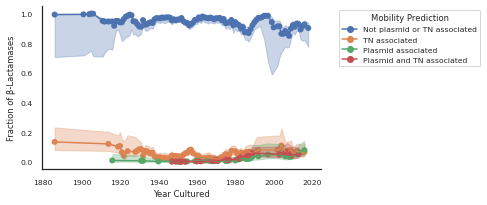

In [49]:

plot_mobility_combinations(
    mobility_df,
    combination_column="Kepler-Assoc",
    savefig=True,
    figname="suppfig_kdog",
)

/tmp/ipykernel_5534/26065708.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



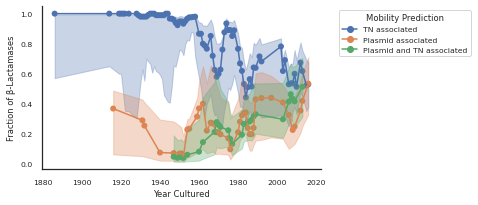

In [50]:
plot_mobility_combinations(
    mobility_df.loc[mobility_df['Kepler-Assoc'] != 'Not plasmid or TN associated'],
    combination_column="Kepler-Assoc",
    savefig=True,
    figname="suppfig_kdog2",
)

In [ ]:


# mamodf_resistance = pd.read_csv(
#     "../../data/3_analysis-mamo/mergedmamooutput",
#     sep="\t",
#     names=[
#         "Accession_Number",
#         "Contig",
#         "Start",
#         "Stop",
#         "AbG",
#         "mobileelementfinder",
#         "IntegronFinder",
#         "PlasmidFinder",
#         "mob_recon",
#     ],
# )
# mamodf_resistance["Start"] = mamodf_resistance["Start"].astype("int")
# mamodf_resistance["Stop"] = mamodf_resistance["Stop"].astype("int")

# merged_rgi_mamo = df.merge(
#     mamodf_resistance,
#     on=["Accession_Number", "Contig", "Start", "Stop"],
#     how="outer",
#     indicator=True,
# )
# merged_rgi_mamo["_merge"].value_counts()

# merged_rgi_mamo.loc[merged_rgi_mamo["_merge"] == "left_only"]

# import seaborn as sns

# # Create a new dataframe with only the columns of interest
# mobility_df = merged_rgi_mamo[merged_rgi_mamo["_merge"] == "both"][
#     [
#         "Accession_Number",
#         "Species_Name",
#         "Best_Hit_ARO",
#         "Resistance Mechanism",
#         "AMR Gene Family",
#         "Drug Class",
#         "Year_Cultured",
#         "mobileelementfinder",
#         "IntegronFinder",
#         "PlasmidFinder",
#         "mob_recon",
#     ]
# ].copy()

# # Create a new column 'Mobile' with default value 1
# mobility_df["Mobile"] = 1

# # Set 'Mobile' to 0 for rows where all four columns are equal to specific values
# mobility_df.loc[
#     (mobility_df["mobileelementfinder"] == "no-me")
#     & (mobility_df["IntegronFinder"] == "no-integron")
#     & (mobility_df["PlasmidFinder"] == "no-plasmid")
#     & (mobility_df["mob_recon"] == "no-plasmid"),
#     "Mobile",
# ] = 0

# mobility_df["me_simp"] = "no-me"
# mobility_df.loc[
#     mobility_df["mobileelementfinder"] != "no-me", "me_simp"
# ] = "mobileelement"

# # mobility_df
# # mobility_df[mobility_df["Mobile"] == 1][['Best_Hit_ARO','Mobile']].value_counts()

# mobility_df["integron_simp"] = "no-integron"
# mobility_df.loc[
#     (mobility_df["IntegronFinder"] == "CALIN")
#     | (mobility_df["IntegronFinder"] == "complete"),
#     "integron_simp",
# ] = "Integron-associated"

# mobility_df["plasmid_simp"] = "no-plasmid"
# mobility_df.loc[
#     (mobility_df["mob_recon"] != "no-plasmid"),
#     "plasmid_simp",
# ] = "Plasmid-associated"

# mobility_df["plasmidtype_simp"] = "no-plasmid"
# mobility_df.loc[
#     mobility_df["mob_recon"].str.contains("conjugative"),
#     "plasmidtype_simp",
# ] = "conjugative"
# mobility_df.loc[
#     mobility_df["mob_recon"].str.contains("mobilizable"),
#     "plasmidtype_simp",
# ] = "mobilizable"
# mobility_df.loc[
#     mobility_df["mob_recon"].str.contains("non-mobilizable"),
#     "plasmidtype_simp",
# ] = "non-mobilizable"

# mobility_df["Mobile"] = mobility_df.apply(
#     lambda x: "{}|{}|{}".format(x["me_simp"], x["integron_simp"], x["plasmid_simp"]),
#     axis=1,
# )

# mobility_df.loc[mobility_df["plasmid_simp"] != "no-plasmid", "mobility_pred"] = "mobile"
# mobility_df.loc[
#     mobility_df["integron_simp"] != "no-plasmid", "mobility_pred"
# ] = "mobile"
# mobility_df.loc[mobility_df["plasmid_simp"] != "no-plasmid", "mobility_pred"] = "mobile"
# # mobility_df

# mobility_df

# import scipy.stats as stats
# from scipy.stats import binom


# def measure_obs_distance(
#     dataframe, value, anthro_year, column, sums=False, verbose=False
# ):
#     num_yearcultured_allstrains_dict = (
#         dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
#         .value_counts()
#         .to_dict()
#     )
#     num_yearcultured_valposstrains_dict = (
#         dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
#         .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
#         .value_counts()
#         .to_dict()
#     )
#     fractional_dictionary = {}
#     for years in num_yearcultured_allstrains_dict:
#         if num_yearcultured_allstrains_dict[years] == 0:
#             continue
#         if years in num_yearcultured_valposstrains_dict:
#             val = [
#                 num_yearcultured_valposstrains_dict[years],
#                 num_yearcultured_allstrains_dict[years],
#             ]
#             # fraction = (
#             #     num_yearcultured_valposstrains_dict[years]
#             #     / num_yearcultured_allstrains_dict[years]
#             # )
#         else:
#             val = [0, num_yearcultured_allstrains_dict[years]]
#         fractional_dictionary[years] = val

#     yeardf = (
#         pd.DataFrame.from_dict(
#             fractional_dictionary, orient="index", columns=["num_pos", "all"]
#         )
#         .reset_index()
#         .rename(columns={"index": "year"})
#         .sort_values(by="year")
#         .reset_index(drop=True)
#     )
#     yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
#     if verbose:
#         print(yeardf)
#     anthro = {True: "Pre-Human", False: "Post-Human"}
#     # line = pd.Index(yeardf["year"]).get_loc(anthro_year)
#     # yeardf["row"] = np.arange(yeardf.shape[0])
#     # yeardf["Anthropogenicity"] = "Pre-Human"
#     # yeardf.loc[yeardf["row"] > line, "Anthropogenicity"] = "Post-Human"
#     yeardf["Anthropogenicity"] = "Pre-Human"
#     yeardf.loc[yeardf["year"] > anthro_year, "Anthropogenicity"] = "Post-Human"

#     preanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Pre-Human"][
#         "frac"
#     ].mean()
#     postanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Post-Human"][
#         "frac"
#     ].mean()
#     metric = postanthro_mean - preanthro_mean
#     # print("Pre-Human mean fraction = %s" % (preanthro_mean))
#     # print("Post-Human mean fraction = %s" % (postanthro_mean))
#     # print("metric = %s" % (metric))
#     return yeardf, preanthro_mean, postanthro_mean


# import scipy.stats as stats
# from scipy.stats import binom


# def calculate_frequency_bounds(row, confidence=0.95):
#     successes = row["num_pos"]
#     attempts = row["all"]
#     freq = row["num_pos"] / row["all"]
#     alpha = successes + 1
#     beta = attempts - successes + 1
#     lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
#     return (lower_b, upper_b)


# def plot_abresist_frac_error_mobility(
#     df1,
#     ex1,
#     ex2,
#     ex3,
#     year,
#     verbose=True,
#     sims=100,
#     figname="doodoo",
#     savefig=False,
#     smooth=5,
#     col1="me_simp",
#     col2="integron_simp",
#     col3="plasmid_simp",
#     value="phenotype",
# ):

#     sns.set_theme(font="Arial", style="white", font_scale=0.7)

#     frac_df1, pre, post = measure_obs_distance(df1, ex1, 0, col1, verbose)
#     frac_df2, pre, post = measure_obs_distance(df1, ex2, 0, col2, verbose)
#     frac_df3, pre, post = measure_obs_distance(df1, ex3, 0, col3, verbose)

#     # print(frac_df)

#     # histogram of fraction of strains w/ RGI hits for drug class
#     plt.figure(figsize=(14, 8))
#     chart = sns.barplot(
#         data=frac_df1, x="year", y="frac", color="salmon", saturation=0.5
#     )
#     chart.bar_label(chart.containers[0])

#     # plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
#     plt.ylabel("Fraction of bugs with phenotype")
#     plt.xlabel("Year")
#     plt.xticks(rotation=45)

#     plt.show()

#     d = {"Year": [], "num_pos": [], "all": []}
#     for years in range(frac_df1["year"].min(), frac_df1["year"].max()):
#         upb = smooth + years
#         downb = years - smooth
#         g = frac_df1.loc[(frac_df1["year"] <= upb) & (downb <= frac_df1["year"])]
#         if years not in frac_df1["year"].values:
#             continue
#         d["num_pos"].append(g["num_pos"].sum())
#         d["all"].append(g["all"].sum())
#         d["Year"].append(years)
#     xdf1 = pd.DataFrame(data=d)
#     # print(xdf)
#     xdf1["frac"] = xdf1["num_pos"] / xdf1["all"]
#     xdf1[["lower-error", "upper-error"]] = xdf1.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     d = {"Year": [], "num_pos": [], "all": []}
#     for years in range(frac_df2["year"].min(), frac_df2["year"].max()):
#         upb = smooth + years
#         downb = years - smooth
#         g = frac_df2.loc[(frac_df2["year"] <= upb) & (downb <= frac_df2["year"])]
#         if years not in frac_df2["year"].values:
#             continue
#         d["num_pos"].append(g["num_pos"].sum())
#         d["all"].append(g["all"].sum())
#         d["Year"].append(years)
#     xdf2 = pd.DataFrame(data=d)
#     # print(xdf)
#     xdf2["frac"] = xdf2["num_pos"] / xdf2["all"]
#     xdf2[["lower-error", "upper-error"]] = xdf2.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     d = {"Year": [], "num_pos": [], "all": []}
#     for years in range(frac_df3["year"].min(), frac_df3["year"].max()):
#         upb = smooth + years
#         downb = years - smooth
#         g = frac_df3.loc[(frac_df3["year"] <= upb) & (downb <= frac_df3["year"])]
#         if years not in frac_df3["year"].values:
#             continue
#         d["num_pos"].append(g["num_pos"].sum())
#         d["all"].append(g["all"].sum())
#         d["Year"].append(years)
#     xdf3 = pd.DataFrame(data=d)
#     # print(xdf)
#     xdf3["frac"] = xdf3["num_pos"] / xdf3["all"]
#     xdf3[["lower-error", "upper-error"]] = xdf3.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     fig1, ax1 = plt.subplots(figsize=(14, 8))

#     # make subplots for the figure
#     ax1.set(xlabel="Year Cultured")
#     lp = sns.lineplot(
#         data=xdf1,
#         x="Year",
#         y="frac",
#         markers=True,
#         ax=ax1,
#     )
#     lp.set(ylim=(0, 1))
#     dp = sns.scatterplot(
#         data=xdf1,
#         x="Year",
#         y="frac",
#         legend=False,
#         ax=ax1,
#         edgecolor="none",
#     )
#     plt.fill_between(
#         xdf1["Year"],
#         xdf1["lower-error"],
#         xdf1["upper-error"],
#         alpha=0.3,
#         edgecolor=sns.color_palette("deep")[0],
#         facecolor=sns.color_palette("deep")[0],
#     )

#     # make subplots for the figure
#     ax1.set(xlabel="Year Cultured")
#     lp = sns.lineplot(
#         data=xdf2,
#         x="Year",
#         y="frac",
#         markers=True,
#         ax=ax1,
#     )
#     lp.set(ylim=(0, 1))
#     dp = sns.scatterplot(
#         data=xdf2,
#         x="Year",
#         y="frac",
#         legend=False,
#         ax=ax1,
#         edgecolor="none",
#     )
#     plt.fill_between(
#         xdf2["Year"],
#         xdf2["lower-error"],
#         xdf2["upper-error"],
#         alpha=0.3,
#         edgecolor=sns.color_palette("deep")[1],
#         facecolor=sns.color_palette("deep")[1],
#     )

#     # make subplots for the figure
#     ax1.set(xlabel="Year Cultured")
#     lp = sns.lineplot(
#         data=xdf3,
#         x="Year",
#         y="frac",
#         markers=True,
#         ax=ax1,
#     )
#     lp.set(ylim=(0, 1))
#     dp = sns.scatterplot(
#         data=xdf3,
#         x="Year",
#         y="frac",
#         legend=False,
#         ax=ax1,
#         edgecolor="none",
#     )
#     plt.fill_between(
#         xdf3["Year"],
#         xdf3["lower-error"],
#         xdf3["upper-error"],
#         alpha=0.3,
#         edgecolor=sns.color_palette("deep")[2],
#         facecolor=sns.color_palette("deep")[2],
#     )
#     sns.despine()

#     # Create a list of labels for the legend
#     legend_labels = ["Tn/IS-associated", "Plasmid-associated", "Integron-associated"]

#     # Create a list of the colors corresponding to each label
#     legend_colors = [
#         sns.color_palette("deep")[0],
#         sns.color_palette("deep")[1],
#         sns.color_palette("deep")[2],
#     ]

#     # Add a legend to the plot
#     plt.legend(
#         legend_labels,
#         loc="upper right",
#         title="Mobility classes",
#         labels=legend_labels,
#         handles=[
#             plt.Line2D(
#                 [0], [0], marker="o", color="w", markerfacecolor=color, markersize=8
#             )
#             for color in legend_colors
#         ],
#     )

#     ax1.set_ylabel("Fraction of resistance alleles with mobility")
#     # ax1.set(ylabel="Fraction of isolates with {}".format(value))

#     if savefig:
#         plt.gcf().set_size_inches(5.0, 3)
#         plt.savefig(
#             "{}-fractionofresist.svg".format(figname),
#             bbox_inches="tight",
#             dpi=300,
#         )

# # Panel A: Resistance becomes more mobile

# plot_abresist_frac_error_mobility(
#     mobility_df,
#     "mobileelement",
#     "Plasmid-associated",
#     "Integron-associated",
#     0,
#     verbose=True,
#     sims=100,
#     figname="./figs/fig5/resistance_fraction",
#     savefig=True,
#     smooth=5,
#     col1="me_simp",
#     col3="integron_simp",
#     col2="plasmid_simp",
#     value="phenotype",
# )

# # Plasmids

# mob_df = pd.read_csv("../../data/3_analysis-plasmid/merged-mobtyper", sep="\t")
# accession_numbers = single_acc_df[
#     ~single_acc_df["Accession_Number"].isin(mob_df["AccNum"])
# ]["Accession_Number"].values

# new_rows = pd.DataFrame({"AccNum": accession_numbers})
# new_rows[mob_df.columns[1:]] = np.nan

# mob_df = pd.concat([mob_df, new_rows], ignore_index=True)
# mob_df["Year_Cultured"] = mob_df["AccNum"].map(year_dict)
# mob_df["Species"] = mob_df["AccNum"].map(specie_dict)
# mob_df["Accession_Number"] = mob_df["AccNum"]
# mob_df

# contig_mobtyper_df = pd.read_csv(
#     "../../data/3_analysis-plasmid/merged-contigreport", sep="\t"
# )
# contig_mobtyper_df["Contig"] = contig_mobtyper_df["contig_id"].str.split(
#     " ", expand=True
# )[0]
# contig_mobtyper_df["Year_Cultured"] = contig_mobtyper_df["AccNum"].map(year_dict)

# contig_mobtyper_df = contig_mobtyper_df.merge(
#     df,
#     on=["Contig", "Year_Cultured"],
#     how="outer",
#     indicator=True,
# )
# contig_mobtyper_df["_merge"].value_counts()
# plasmidscontigs_withandwithoutresistance = contig_mobtyper_df.loc[
#     contig_mobtyper_df["_merge"].str.contains("left_only|both")
# ].copy()
# plasmidscontigs_withandwithoutresistance["Accession_Number"] = (
#     plasmidscontigs_withandwithoutresistance["AccNum"]
#     + plasmidscontigs_withandwithoutresistance["primary_cluster_id"]
# )
# plasmidscontigs_withandwithoutresistance



# plasmidscontigs_withandwithoutresistance

# mob_df

# plasmidscontigs_withandwithoutresistance["sample_id2"] = (
#     plasmidscontigs_withandwithoutresistance["sample_id"]
#     + ":"
#     + plasmidscontigs_withandwithoutresistance["primary_cluster_id"]
# )
# plasmidscontigs_withandwithoutresistance = (
#     plasmidscontigs_withandwithoutresistance.rename(columns={"_merge": "Merge_Status1"})
# )
# plasmidscontigs_withandwithoutresistance

# mob_df["sample_id2"] = mob_df["sample_id"]
# merge_test = pd.merge(
#     plasmidscontigs_withandwithoutresistance[
#         plasmidscontigs_withandwithoutresistance["molecule_type"] == "plasmid"
#     ],
#     mob_df,
#     on=["sample_id2"],
#     how="outer",
#     indicator=True,
# )
# merge_test["_merge"].value_counts()

# merge_test[
#     (merge_test["_merge"] == "both") & (merge_test["Merge_Status1"] == "both")
# ].dropna(axis=1, how="all")["Best_Hit_ARO"].value_counts()

# merge_test["Accession_Number"] = merge_test["Accession_Number_y"]
# merge_test["Year_Cultured"] = merge_test["Year_Cultured_y"]
# merge_test["Accession_Number"].unique().shape

# mob_df["Accession_Number"].unique().shape

# import scipy.stats as stats
# from scipy.stats import binom


# def measure_obs_distance(
#     dataframe, value, anthro_year, column, sums=False, verbose=False
# ):
#     num_yearcultured_allstrains_dict = (
#         dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
#         .value_counts()
#         .to_dict()
#     )
#     num_yearcultured_valposstrains_dict = (
#         dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
#         .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
#         .value_counts()
#         .to_dict()
#     )
#     fractional_dictionary = {}
#     for years in num_yearcultured_allstrains_dict:
#         if num_yearcultured_allstrains_dict[years] == 0:
#             continue
#         if years in num_yearcultured_valposstrains_dict:
#             val = [
#                 num_yearcultured_valposstrains_dict[years],
#                 num_yearcultured_allstrains_dict[years],
#             ]
#             # fraction = (
#             #     num_yearcultured_valposstrains_dict[years]
#             #     / num_yearcultured_allstrains_dict[years]
#             # )
#         else:
#             val = [0, num_yearcultured_allstrains_dict[years]]
#         fractional_dictionary[years] = val

#     yeardf = (
#         pd.DataFrame.from_dict(
#             fractional_dictionary, orient="index", columns=["num_pos", "all"]
#         )
#         .reset_index()
#         .rename(columns={"index": "year"})
#         .sort_values(by="year")
#         .reset_index(drop=True)
#     )
#     yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
#     if verbose:
#         print(yeardf)
#     anthro = {True: "Pre-Human", False: "Post-Human"}
#     # line = pd.Index(yeardf["year"]).get_loc(anthro_year)
#     # yeardf["row"] = np.arange(yeardf.shape[0])
#     # yeardf["Anthropogenicity"] = "Pre-Human"
#     # yeardf.loc[yeardf["row"] > line, "Anthropogenicity"] = "Post-Human"
#     yeardf["Anthropogenicity"] = "Pre-Human"
#     yeardf.loc[yeardf["year"] > anthro_year, "Anthropogenicity"] = "Post-Human"

#     preanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Pre-Human"][
#         "frac"
#     ].mean()
#     postanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Post-Human"][
#         "frac"
#     ].mean()
#     metric = postanthro_mean - preanthro_mean
#     # print("Pre-Human mean fraction = %s" % (preanthro_mean))
#     # print("Post-Human mean fraction = %s" % (postanthro_mean))
#     # print("metric = %s" % (metric))
#     return yeardf, preanthro_mean, postanthro_mean


# import scipy.stats as stats
# from scipy.stats import binom


# def calculate_frequency_bounds(row, confidence=0.95):
#     successes = row["num_pos"]
#     attempts = row["all"]
#     freq = row["num_pos"] / row["all"]
#     alpha = successes + 1
#     beta = attempts - successes + 1
#     lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
#     return (lower_b, upper_b)


# def plot_abresist_frac_error_plasmids(
#     df1,
#     df2,
#     ex1,
#     ex2,
#     year,
#     verbose=True,
#     sims=100,
#     figname="doodoo",
#     savefig=False,
#     smooth=5,
#     col1="Drug Class",
#     col2="Drug Class",
#     value="phenotype",
# ):

#     sns.set_theme(font="Arial", style="white", font_scale=0.7)

#     frac_df1, pre, post = measure_obs_distance(df1, ex1, 0, col1, verbose)
#     frac_df2, pre, post = measure_obs_distance(df2, ex2, 0, col2, verbose)

#     # print(frac_df)

#     # histogram of fraction of strains w/ RGI hits for drug class
#     plt.figure(figsize=(14, 8))
#     chart = sns.barplot(
#         data=frac_df1, x="year", y="frac", color="salmon", saturation=0.5
#     )
#     chart.bar_label(chart.containers[0])

#     # plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
#     plt.ylabel("Fraction of bugs with phenotype")
#     plt.xlabel("Year")
#     plt.xticks(rotation=45)

#     plt.show()

#     d = {"Year": [], "num_pos": [], "all": []}
#     for years in range(frac_df1["year"].min(), frac_df1["year"].max()):
#         upb = smooth + years
#         downb = years - smooth
#         g = frac_df1.loc[(frac_df1["year"] <= upb) & (downb <= frac_df1["year"])]
#         if years not in frac_df1["year"].values:
#             continue
#         d["num_pos"].append(g["num_pos"].sum())
#         d["all"].append(g["all"].sum())
#         d["Year"].append(years)
#     xdf1 = pd.DataFrame(data=d)
#     # print(xdf)
#     xdf1["frac"] = xdf1["num_pos"] / xdf1["all"]
#     xdf1[["lower-error", "upper-error"]] = xdf1.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     d = {"Year": [], "num_pos": [], "all": []}
#     for years in range(frac_df2["year"].min(), frac_df2["year"].max()):
#         upb = smooth + years
#         downb = years - smooth
#         g = frac_df2.loc[(frac_df2["year"] <= upb) & (downb <= frac_df2["year"])]
#         if years not in frac_df2["year"].values:
#             continue
#         d["num_pos"].append(g["num_pos"].sum())
#         d["all"].append(g["all"].sum())
#         d["Year"].append(years)
#     xdf2 = pd.DataFrame(data=d)
#     print(xdf)
#     xdf2["frac"] = xdf2["num_pos"] / xdf2["all"]
#     xdf2[["lower-error", "upper-error"]] = xdf2.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     fig1, ax1 = plt.subplots(figsize=(14, 8))
#     # ax2 = ax1.twinx()  # Create a second y-axis

#     # make subplots for the figure
#     ax1.set(xlabel="Year Cultured")
#     lp = sns.lineplot(
#         data=xdf1,
#         x="Year",
#         y="frac",
#         markers=True,
#         ax=ax1,
#     )
#     # lp.set(ylim=(0, 1))
#     dp = sns.scatterplot(
#         data=xdf1,
#         x="Year",
#         y="frac",
#         legend=False,
#         ax=ax1,
#         edgecolor="none",
#     )
#     plt.fill_between(
#         xdf1["Year"],
#         xdf1["lower-error"],
#         xdf1["upper-error"],
#         alpha=0.3,
#         edgecolor=sns.color_palette("deep")[0],
#         facecolor=sns.color_palette("deep")[0],
#     )

#     # make subplots for the figure
#     # ax1.set(xlabel="Year Cultured")
#     lp = sns.lineplot(
#         data=xdf2,
#         x="Year",
#         y="frac",
#         markers=True,
#         ax=ax1,
#         color=sns.color_palette("deep")[1],
#     )
#     lp.set(ylim=(0, 1))
#     dp = sns.scatterplot(
#         data=xdf2,
#         x="Year",
#         y="frac",
#         legend=False,
#         ax=ax1,
#         edgecolor="none",
#         facecolor=sns.color_palette("deep")[1],
#     )
#     plt.fill_between(
#         xdf2["Year"],
#         xdf2["lower-error"],
#         xdf2["upper-error"],
#         alpha=0.3,
#         edgecolor=sns.color_palette("deep")[1],
#         facecolor=sns.color_palette("deep")[1],
#     )

#     # Manually create legend
#     legend_elements = [
#         plt.Line2D(
#             [0],
#             [0],
#             marker="o",
#             color=sns.color_palette("deep")[0],
#             label="≥ 1 plasmid",
#             markerfacecolor=sns.color_palette("deep")[0],
#             # markersize=10,
#         ),
#         plt.Line2D(
#             [0],
#             [0],
#             marker="o",
#             color=sns.color_palette("deep")[1],
#             label="≥ 1 plasmid with ≥ 1 resistance element",
#             markerfacecolor=sns.color_palette("deep")[1],
#             # markersize=10,
#         ),
#     ]

#     plt.legend(handles=legend_elements)
#     ax1.set(ylabel="Fraction of isolates")
#     # ax1.set_ylabel(
#     #     "Fraction of isolates with ≥ 1 plasmid", color=sns.color_palette("deep")[0]
#     # )
#     # ax2.set_ylabel(
#     #     "Fraction of isolates with\n≥ 1 plasmid containing≥ 1 resistance element",
#     #     color=sns.color_palette("deep")[1],
#     # )
#     sns.despine()
#     # ax1.set(ylabel="Fraction of isolates with {}".format(value))

#     if savefig:
#         plt.gcf().set_size_inches(5.0, 3)
#         plt.savefig(
#             "{}-fractionofresist.svg".format(figname),
#             bbox_inches="tight",
#             dpi=300,
#         )

# plot_abresist_frac_error_plasmids(
#     merge_test,
#     merge_test,
#     "both",
#     "both",
#     0,
#     verbose=True,
#     sims=0,
#     figname="./figs/fig5/plasmid-occurrence-opt2",
#     savefig=True,
#     smooth=3,
#     col1="_merge",
#     col2="Merge_Status1",
#     value="≥ 1 plasmid",
# )

# ### Dual Y-axes

# import scipy.stats as stats
# from scipy.stats import binom


# def measure_obs_distance(
#     dataframe, value, anthro_year, column, sums=False, verbose=False
# ):
#     num_yearcultured_allstrains_dict = (
#         dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
#         .value_counts()
#         .to_dict()
#     )
#     num_yearcultured_valposstrains_dict = (
#         dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
#         .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
#         .value_counts()
#         .to_dict()
#     )
#     fractional_dictionary = {}
#     for years in num_yearcultured_allstrains_dict:
#         if num_yearcultured_allstrains_dict[years] == 0:
#             continue
#         if years in num_yearcultured_valposstrains_dict:
#             val = [
#                 num_yearcultured_valposstrains_dict[years],
#                 num_yearcultured_allstrains_dict[years],
#             ]
#             # fraction = (
#             #     num_yearcultured_valposstrains_dict[years]
#             #     / num_yearcultured_allstrains_dict[years]
#             # )
#         else:
#             val = [0, num_yearcultured_allstrains_dict[years]]
#         fractional_dictionary[years] = val

#     yeardf = (
#         pd.DataFrame.from_dict(
#             fractional_dictionary, orient="index", columns=["num_pos", "all"]
#         )
#         .reset_index()
#         .rename(columns={"index": "year"})
#         .sort_values(by="year")
#         .reset_index(drop=True)
#     )
#     yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
#     if verbose:
#         print(yeardf)
#     anthro = {True: "Pre-Human", False: "Post-Human"}
#     # line = pd.Index(yeardf["year"]).get_loc(anthro_year)
#     # yeardf["row"] = np.arange(yeardf.shape[0])
#     # yeardf["Anthropogenicity"] = "Pre-Human"
#     # yeardf.loc[yeardf["row"] > line, "Anthropogenicity"] = "Post-Human"
#     yeardf["Anthropogenicity"] = "Pre-Human"
#     yeardf.loc[yeardf["year"] > anthro_year, "Anthropogenicity"] = "Post-Human"

#     preanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Pre-Human"][
#         "frac"
#     ].mean()
#     postanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Post-Human"][
#         "frac"
#     ].mean()
#     metric = postanthro_mean - preanthro_mean
#     # print("Pre-Human mean fraction = %s" % (preanthro_mean))
#     # print("Post-Human mean fraction = %s" % (postanthro_mean))
#     # print("metric = %s" % (metric))
#     return yeardf, preanthro_mean, postanthro_mean


# import scipy.stats as stats
# from scipy.stats import binom


# def calculate_frequency_bounds(row, confidence=0.95):
#     successes = row["num_pos"]
#     attempts = row["all"]
#     freq = row["num_pos"] / row["all"]
#     alpha = successes + 1
#     beta = attempts - successes + 1
#     lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
#     return (lower_b, upper_b)


# def plot_abresist_frac_error_plasmids(
#     df1,
#     df2,
#     ex1,
#     ex2,
#     year,
#     verbose=True,
#     sims=100,
#     figname="doodoo",
#     savefig=False,
#     smooth=5,
#     col1="Drug Class",
#     col2="Drug Class",
#     value="phenotype",
# ):

#     sns.set_theme(font="Arial", style="white", font_scale=0.7)

#     frac_df1, pre, post = measure_obs_distance(df1, ex1, 0, col1, verbose)
#     frac_df2, pre, post = measure_obs_distance(df2, ex2, 0, col2, verbose)

#     # print(frac_df)

#     # histogram of fraction of strains w/ RGI hits for drug class
#     plt.figure(figsize=(14, 8))
#     chart = sns.barplot(
#         data=frac_df1, x="year", y="frac", color="salmon", saturation=0.5
#     )
#     chart.bar_label(chart.containers[0])

#     # plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
#     plt.ylabel("Fraction of bugs with phenotype")
#     plt.xlabel("Year")
#     plt.xticks(rotation=45)

#     plt.show()

#     d = {"Year": [], "num_pos": [], "all": []}
#     for years in range(frac_df1["year"].min(), frac_df1["year"].max()):
#         upb = smooth + years
#         downb = years - smooth
#         g = frac_df1.loc[(frac_df1["year"] <= upb) & (downb <= frac_df1["year"])]
#         if years not in frac_df1["year"].values:
#             continue
#         d["num_pos"].append(g["num_pos"].sum())
#         d["all"].append(g["all"].sum())
#         d["Year"].append(years)
#     xdf1 = pd.DataFrame(data=d)
#     # print(xdf)
#     xdf1["frac"] = xdf1["num_pos"] / xdf1["all"]
#     xdf1[["lower-error", "upper-error"]] = xdf1.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     d = {"Year": [], "num_pos": [], "all": []}
#     for years in range(frac_df2["year"].min(), frac_df2["year"].max()):
#         upb = smooth + years
#         downb = years - smooth
#         g = frac_df2.loc[(frac_df2["year"] <= upb) & (downb <= frac_df2["year"])]
#         if years not in frac_df2["year"].values:
#             continue
#         d["num_pos"].append(g["num_pos"].sum())
#         d["all"].append(g["all"].sum())
#         d["Year"].append(years)
#     xdf2 = pd.DataFrame(data=d)
#     print(xdf2)
#     xdf2["frac"] = xdf2["num_pos"] / xdf2["all"]
#     xdf2[["lower-error", "upper-error"]] = xdf2.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     fig1, ax1 = plt.subplots(figsize=(14, 8))
#     ax2 = ax1.twinx()  # Create a second y-axis

#     # make subplots for the figure
#     ax1.set(xlabel="Year Cultured")
#     lp = sns.lineplot(
#         data=xdf1,
#         x="Year",
#         y="frac",
#         markers=True,
#         ax=ax1,
#     )
#     lp.set(ylim=(0, 1))
#     dp = sns.scatterplot(
#         data=xdf1,
#         x="Year",
#         y="frac",
#         legend=False,
#         ax=ax1,
#         edgecolor="none",
#     )
#     plt.fill_between(
#         xdf1["Year"],
#         xdf1["lower-error"],
#         xdf1["upper-error"],
#         alpha=0.3,
#         edgecolor=sns.color_palette("deep")[0],
#         facecolor=sns.color_palette("deep")[0],
#     )

#     # make subplots for the figure
#     ax2.set(xlabel="Year Cultured")
#     lp = sns.lineplot(
#         data=xdf2,
#         x="Year",
#         y="frac",
#         markers=True,
#         ax=ax2,
#         color=sns.color_palette("deep")[1],
#     )
#     lp.set(ylim=(0, 1))
#     dp = sns.scatterplot(
#         data=xdf2,
#         x="Year",
#         y="frac",
#         legend=False,
#         ax=ax2,
#         edgecolor="none",
#         facecolor=sns.color_palette("deep")[1],
#     )
#     plt.fill_between(
#         xdf2["Year"],
#         xdf2["lower-error"],
#         xdf2["upper-error"],
#         alpha=0.3,
#         edgecolor=sns.color_palette("deep")[1],
#         facecolor=sns.color_palette("deep")[1],
#     )

#     ax1.set_ylabel(
#         "Fraction of isolates with ≥ 1 plasmid", color=sns.color_palette("deep")[0]
#     )
#     ax2.set_ylabel(
#         "Fraction of plasmids with\n≥ 1 resistance allele",
#         color=sns.color_palette("deep")[1],
#     )
#     sns.despine(right=False)
#     # ax1.set(ylabel="Fraction of isolates with {}".format(value))

#     if savefig:
#         plt.gcf().set_size_inches(5.0, 3)
#         plt.savefig(
#             "{}-fractionofresist.svg".format(figname),
#             bbox_inches="tight",
#             dpi=300,
#         )

# plasmidscontigs_withandwithoutresistance

# plot_abresist_frac_error_plasmids(
#     mob_df,
#     plasmidscontigs_withandwithoutresistance[
#         plasmidscontigs_withandwithoutresistance["molecule_type"] == "plasmid"
#     ],
#     "assembly",
#     "both",
#     0,
#     verbose=True,
#     sims=0,
#     figname="./figs/fig5/plasmid-occurrence",
#     savefig=True,
#     smooth=3,
#     col1="sample_id",
#     col2="Merge_Status1",
#     value="≥ 1 plasmid",
# )

# # Integrons

# integron_df = pd.read_csv("../../data/3_analysis-integron/merged-integrons", sep="\t")
# integron_df["Integron_name"] = integron_df["Acc_Num"] + integron_df["ID_integron"]
# accession_numbers = single_acc_df[
#     ~single_acc_df["Accession_Number"].isin(integron_df["Acc_Num"])
# ]["Accession_Number"].values

# new_rows = pd.DataFrame({"Acc_Num": accession_numbers})
# new_rows[integron_df.columns[1:]] = np.nan

# integron_df = pd.concat([integron_df, new_rows], ignore_index=True)
# integron_df["Year_Cultured"] = integron_df["Acc_Num"].map(year_dict)
# integron_df["Species"] = integron_df["Acc_Num"].map(specie_dict)
# integron_df["Accession_Number"] = integron_df["Acc_Num"]
# integron_df["Start"] = integron_df["st"]
# integron_df["Stop"] = integron_df["en"]
# integron_df

# integron_rgidf = pd.read_csv(
#     "../../data/3_analysis-integron/rgi_overlapsintegrons.bed",
#     sep="\t",
#     names=["Contig", "Start", "Stop", "Orientation"],
# )
# integron_rgidf["Start"] = integron_rgidf["Start"].apply(lambda x: str(x) + ".0")
# integron_rgidf["Stop"] = integron_rgidf["Stop"].apply(lambda x: str(x) + ".0")
# integron_rgidf = integron_rgidf.merge(
#     # this is for 2 y-axes
#     # integron_df.astype({"Start": str, "Stop": str}).dropna(subset=["Assembly_Num"]),
#     integron_df.astype({"Start": str, "Stop": str}),
#     on=["Contig", "Stop"],
#     how="outer",
#     indicator=True,
# )
# # integron_rgidf
# # integron_rgidf['_merge']

# # integron_rgidf.loc[integron_rgidf["_merge"] == "both", "Accession_Number"] = (
# #     integron_rgidf["Integron_name"]
# # )
# integron_rgidf = integron_rgidf[
#     ["Acc_Num", "Integron_name", "Contig", "Start_x", "Stop"]
# ]
# integron_rgidf["Year_Cultured"] = integron_rgidf["Acc_Num"].map(year_dict)

# # x
# # integron_rgidf.dropna(subset=["Start_x"], inplace=True)
# integron_rgidf.rename(
#     columns={"Start_x": "Start", "Acc_Num": "Accession_Number"}, inplace=True
# )
# integron_rgidf["Resistance"] = "Yes"
# integron_rgidf.loc[integron_rgidf["Start"].isna(), "Resistance"] = "No"
# integron_rgidf

# import scipy.stats as stats
# from scipy.stats import binom


# def measure_obs_distance(
#     dataframe, value, anthro_year, column, sums=False, verbose=False
# ):
#     num_yearcultured_allstrains_dict = (
#         dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
#         .value_counts()
#         .to_dict()
#     )
#     num_yearcultured_valposstrains_dict = (
#         dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
#         .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
#         .value_counts()
#         .to_dict()
#     )
#     fractional_dictionary = {}
#     for years in num_yearcultured_allstrains_dict:
#         if num_yearcultured_allstrains_dict[years] == 0:
#             continue
#         if years in num_yearcultured_valposstrains_dict:
#             val = [
#                 num_yearcultured_valposstrains_dict[years],
#                 num_yearcultured_allstrains_dict[years],
#             ]
#             # fraction = (
#             #     num_yearcultured_valposstrains_dict[years]
#             #     / num_yearcultured_allstrains_dict[years]
#             # )
#         else:
#             val = [0, num_yearcultured_allstrains_dict[years]]
#         fractional_dictionary[years] = val

#     yeardf = (
#         pd.DataFrame.from_dict(
#             fractional_dictionary, orient="index", columns=["num_pos", "all"]
#         )
#         .reset_index()
#         .rename(columns={"index": "year"})
#         .sort_values(by="year")
#         .reset_index(drop=True)
#     )
#     yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
#     if verbose:
#         print(yeardf)
#     anthro = {True: "Pre-Human", False: "Post-Human"}
#     # line = pd.Index(yeardf["year"]).get_loc(anthro_year)
#     # yeardf["row"] = np.arange(yeardf.shape[0])
#     # yeardf["Anthropogenicity"] = "Pre-Human"
#     # yeardf.loc[yeardf["row"] > line, "Anthropogenicity"] = "Post-Human"
#     yeardf["Anthropogenicity"] = "Pre-Human"
#     yeardf.loc[yeardf["year"] > anthro_year, "Anthropogenicity"] = "Post-Human"

#     preanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Pre-Human"][
#         "frac"
#     ].mean()
#     postanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Post-Human"][
#         "frac"
#     ].mean()
#     metric = postanthro_mean - preanthro_mean
#     # print("Pre-Human mean fraction = %s" % (preanthro_mean))
#     # print("Post-Human mean fraction = %s" % (postanthro_mean))
#     # print("metric = %s" % (metric))
#     return yeardf, preanthro_mean, postanthro_mean


# import scipy.stats as stats
# from scipy.stats import binom


# def calculate_frequency_bounds(row, confidence=0.95):
#     successes = row["num_pos"]
#     attempts = row["all"]
#     freq = row["num_pos"] / row["all"]
#     alpha = successes + 1
#     beta = attempts - successes + 1
#     lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
#     return (lower_b, upper_b)


# def plot_abresist_frac_error_integrons(
#     df1,
#     df2,
#     ex1,
#     ex2,
#     year,
#     verbose=True,
#     sims=100,
#     figname="doodoo",
#     savefig=False,
#     smooth=5,
#     col1="Drug Class",
#     col2="Drug Class",
#     value="phenotype",
# ):

#     sns.set_theme(font="Arial", style="white", font_scale=0.7)

#     frac_df1, pre, post = measure_obs_distance(df1, ex1, 0, col1, verbose)
#     frac_df2, pre, post = measure_obs_distance(df2, ex2, 0, col2, verbose)

#     # print(frac_df)

#     # histogram of fraction of strains w/ RGI hits for drug class
#     plt.figure(figsize=(14, 8))
#     chart = sns.barplot(
#         data=frac_df1, x="year", y="frac", color="salmon", saturation=0.5
#     )
#     chart.bar_label(chart.containers[0])

#     # plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
#     plt.ylabel("Fraction of bugs with phenotype")
#     plt.xlabel("Year")
#     plt.xticks(rotation=45)

#     plt.show()
#     # histogram of fraction of strains w/ RGI hits for drug class
#     plt.figure(figsize=(14, 8))
#     chart = sns.barplot(
#         data=frac_df2, x="year", y="frac", color="salmon", saturation=0.5
#     )
#     chart.bar_label(chart.containers[0])

#     # plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
#     plt.ylabel("Fraction of bugs with phenotype")
#     plt.xlabel("Year")
#     plt.xticks(rotation=45)

#     plt.show()

#     d = {"Year": [], "num_pos": [], "all": []}
#     for years in range(frac_df1["year"].min(), frac_df1["year"].max()):
#         upb = smooth + years
#         downb = years - smooth
#         g = frac_df1.loc[(frac_df1["year"] <= upb) & (downb <= frac_df1["year"])]
#         if years not in frac_df1["year"].values:
#             continue
#         d["num_pos"].append(g["num_pos"].sum())
#         d["all"].append(g["all"].sum())
#         d["Year"].append(years)
#     xdf1 = pd.DataFrame(data=d)
#     # print(xdf)
#     xdf1["frac"] = xdf1["num_pos"] / xdf1["all"]
#     xdf1[["lower-error", "upper-error"]] = xdf1.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     d = {"Year": [], "num_pos": [], "all": []}
#     for years in range(frac_df2["year"].min(), frac_df2["year"].max()):
#         upb = smooth + years
#         downb = years - smooth
#         g = frac_df2.loc[(frac_df2["year"] <= upb) & (downb <= frac_df2["year"])]
#         if years not in frac_df2["year"].values:
#             continue
#         d["num_pos"].append(g["num_pos"].sum())
#         d["all"].append(g["all"].sum())
#         d["Year"].append(years)
#     xdf2 = pd.DataFrame(data=d)
#     # print(xdf)
#     xdf2["frac"] = xdf2["num_pos"] / xdf2["all"]
#     xdf2[["lower-error", "upper-error"]] = xdf2.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     fig1, ax1 = plt.subplots(figsize=(14, 8))
#     # ax2 = ax1.twinx()  # Create a second y-axis

#     # make subplots for the figure
#     ax1.set(xlabel="Year Cultured")
#     lp = sns.lineplot(
#         data=xdf1,
#         x="Year",
#         y="frac",
#         markers=True,
#         ax=ax1,
#     )
#     # lp.set(ylim=(0, 1))
#     dp = sns.scatterplot(
#         data=xdf1,
#         x="Year",
#         y="frac",
#         legend=False,
#         ax=ax1,
#         edgecolor="none",
#     )
#     plt.fill_between(
#         xdf1["Year"],
#         xdf1["lower-error"],
#         xdf1["upper-error"],
#         alpha=0.3,
#         edgecolor=sns.color_palette("deep")[0],
#         facecolor=sns.color_palette("deep")[0],
#     )

#     # make subplots for the figure
#     # ax2.set(xlabel="Year Cultured")
#     lp = sns.lineplot(
#         data=xdf2,
#         x="Year",
#         y="frac",
#         markers=True,
#         ax=ax1,
#         color=sns.color_palette("deep")[1],
#     )
#     # lp.set(ylim=(0, 1))
#     dp = sns.scatterplot(
#         data=xdf2,
#         x="Year",
#         y="frac",
#         legend=False,
#         ax=ax1,
#         edgecolor="none",
#         facecolor=sns.color_palette("deep")[1],
#     )
#     plt.fill_between(
#         xdf2["Year"],
#         xdf2["lower-error"],
#         xdf2["upper-error"],
#         alpha=0.3,
#         edgecolor=sns.color_palette("deep")[1],
#         facecolor=sns.color_palette("deep")[1],
#     )

#     ax1.set_ylabel("Fraction of isolates")
#     # ax2.set_ylabel(
#     #     "Fraction of integrons with\n≥ 1 resistance allele",
#     #     color=sns.color_palette("deep")[1],
#     # )
#     sns.despine()
#     # ax1.set(ylabel="Fraction of isolates with {}".format(value))
#     # Manually create legend
#     legend_elements = [
#         plt.Line2D(
#             [0],
#             [0],
#             marker="o",
#             color=sns.color_palette("deep")[0],
#             label="≥ 1 integron",
#             markerfacecolor=sns.color_palette("deep")[0],
#             # markersize=10,
#         ),
#         plt.Line2D(
#             [0],
#             [0],
#             marker="o",
#             color=sns.color_palette("deep")[1],
#             label="≥ 1 integron with ≥ 1 resistance element",
#             markerfacecolor=sns.color_palette("deep")[1],
#             # markersize=10,
#         ),
#     ]

#     plt.legend(handles=legend_elements)
#     if savefig:
#         plt.gcf().set_size_inches(5.0, 3)
#         plt.savefig(
#             "{}-fractionofresist.svg".format(figname),
#             bbox_inches="tight",
#             dpi=300,
#         )

# plot_abresist_frac_error_integrons(
#     integron_rgidf,
#     integron_rgidf,
#     "integron",
#     "Yes",
#     0,
#     verbose=True,
#     sims=0,
#     figname="./figs/fig5/integron-occurrence",
#     savefig=True,
#     smooth=3,
#     col1="Integron_name",
#     col2="Resistance",
#     value="≥ 1 integron",
# )

# # merged_integronrgidf = pd.merge(
# #     integron_rgidf.astype({"Start": str, "Stop": str}),
# #     df.astype({"Start": str, "Stop": str}),
# #     on=["Contig", "Start", "Stop"],
# #     how="outer",
# #     indicator=True,
# # )

# # merged_integronrgidf.rename(
# #     columns={"Accession_Number_x": "Accession_Number"}, inplace=True
# # )
# # merged_integronrgidf

# # merged_integronrgidf.dropna(subset=["Accession_Number"]).sort_values("Year_Cultured")[
# #     ["Accession_Number", "Best_Hit_ARO", "Year_Cultured"]
# # ]

# # merged_integronrgidf["Accession_Number"].value_counts()

# ## Dual Y-axes

# import scipy.stats as stats
# from scipy.stats import binom


# def measure_obs_distance(
#     dataframe, value, anthro_year, column, sums=False, verbose=False
# ):
#     num_yearcultured_allstrains_dict = (
#         dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
#         .value_counts()
#         .to_dict()
#     )
#     num_yearcultured_valposstrains_dict = (
#         dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
#         .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
#         .value_counts()
#         .to_dict()
#     )
#     fractional_dictionary = {}
#     for years in num_yearcultured_allstrains_dict:
#         if num_yearcultured_allstrains_dict[years] == 0:
#             continue
#         if years in num_yearcultured_valposstrains_dict:
#             val = [
#                 num_yearcultured_valposstrains_dict[years],
#                 num_yearcultured_allstrains_dict[years],
#             ]
#             # fraction = (
#             #     num_yearcultured_valposstrains_dict[years]
#             #     / num_yearcultured_allstrains_dict[years]
#             # )
#         else:
#             val = [0, num_yearcultured_allstrains_dict[years]]
#         fractional_dictionary[years] = val

#     yeardf = (
#         pd.DataFrame.from_dict(
#             fractional_dictionary, orient="index", columns=["num_pos", "all"]
#         )
#         .reset_index()
#         .rename(columns={"index": "year"})
#         .sort_values(by="year")
#         .reset_index(drop=True)
#     )
#     yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
#     if verbose:
#         print(yeardf)
#     anthro = {True: "Pre-Human", False: "Post-Human"}
#     # line = pd.Index(yeardf["year"]).get_loc(anthro_year)
#     # yeardf["row"] = np.arange(yeardf.shape[0])
#     # yeardf["Anthropogenicity"] = "Pre-Human"
#     # yeardf.loc[yeardf["row"] > line, "Anthropogenicity"] = "Post-Human"
#     yeardf["Anthropogenicity"] = "Pre-Human"
#     yeardf.loc[yeardf["year"] > anthro_year, "Anthropogenicity"] = "Post-Human"

#     preanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Pre-Human"][
#         "frac"
#     ].mean()
#     postanthro_mean = yeardf.loc[yeardf["Anthropogenicity"] == "Post-Human"][
#         "frac"
#     ].mean()
#     metric = postanthro_mean - preanthro_mean
#     # print("Pre-Human mean fraction = %s" % (preanthro_mean))
#     # print("Post-Human mean fraction = %s" % (postanthro_mean))
#     # print("metric = %s" % (metric))
#     return yeardf, preanthro_mean, postanthro_mean


# import scipy.stats as stats
# from scipy.stats import binom


# def calculate_frequency_bounds(row, confidence=0.95):
#     successes = row["num_pos"]
#     attempts = row["all"]
#     freq = row["num_pos"] / row["all"]
#     alpha = successes + 1
#     beta = attempts - successes + 1
#     lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
#     return (lower_b, upper_b)


# def plot_abresist_frac_error_integrons(
#     df1,
#     df2,
#     ex1,
#     ex2,
#     year,
#     verbose=True,
#     sims=100,
#     figname="doodoo",
#     savefig=False,
#     smooth=5,
#     col1="Drug Class",
#     col2="Drug Class",
#     value="phenotype",
# ):

#     sns.set_theme(font="Arial", style="white", font_scale=0.7)

#     frac_df1, pre, post = measure_obs_distance(df1, ex1, 0, col1, verbose)
#     frac_df2, pre, post = measure_obs_distance(df2, ex2, 0, col2, verbose)
#     print(frac_df2)

#     # print(frac_df)

#     # histogram of fraction of strains w/ RGI hits for drug class
#     plt.figure(figsize=(14, 8))
#     chart = sns.barplot(
#         data=frac_df1, x="year", y="frac", color="salmon", saturation=0.5
#     )
#     chart.bar_label(chart.containers[0])

#     # plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
#     plt.ylabel("Fraction of bugs with phenotype")
#     plt.xlabel("Year")
#     plt.xticks(rotation=45)

#     plt.show()
#     # histogram of fraction of strains w/ RGI hits for drug class
#     plt.figure(figsize=(14, 8))
#     chart = sns.barplot(
#         data=frac_df2, x="year", y="frac", color="salmon", saturation=0.5
#     )
#     chart.bar_label(chart.containers[0])

#     # plt.axvline(pd.Index(frac_df["year"]).get_loc(year, method="nearest"))
#     plt.ylabel("Fraction of bugs with phenotype")
#     plt.xlabel("Year")
#     plt.xticks(rotation=45)

#     plt.show()

#     d = {"Year": [], "num_pos": [], "all": []}
#     for years in range(frac_df1["year"].min(), frac_df1["year"].max()):
#         upb = smooth + years
#         downb = years - smooth
#         g = frac_df1.loc[(frac_df1["year"] <= upb) & (downb <= frac_df1["year"])]
#         if years not in frac_df1["year"].values:
#             continue
#         d["num_pos"].append(g["num_pos"].sum())
#         d["all"].append(g["all"].sum())
#         d["Year"].append(years)
#     xdf1 = pd.DataFrame(data=d)
#     # print(xdf)
#     xdf1["frac"] = xdf1["num_pos"] / xdf1["all"]
#     xdf1[["lower-error", "upper-error"]] = xdf1.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     d = {"Year": [], "num_pos": [], "all": []}
#     for years in range(frac_df2["year"].min(), frac_df2["year"].max()):
#         upb = smooth + years
#         downb = years - smooth
#         g = frac_df2.loc[(frac_df2["year"] <= upb) & (downb <= frac_df2["year"])]
#         if years not in frac_df2["year"].values:
#             continue
#         d["num_pos"].append(g["num_pos"].sum())
#         d["all"].append(g["all"].sum())
#         d["Year"].append(years)
#     print(d)
#     xdf2 = pd.DataFrame(data=d)
#     # print(xdf)
#     xdf2["frac"] = xdf2["num_pos"] / xdf2["all"]
#     xdf2[["lower-error", "upper-error"]] = xdf2.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )
#     print(xdf2)

#     fig1, ax1 = plt.subplots(figsize=(14, 8))
#     ax2 = ax1.twinx()  # Create a second y-axis

#     # make subplots for the figure
#     ax1.set(xlabel="Year Cultured")
#     lp = sns.lineplot(
#         data=xdf1,
#         x="Year",
#         y="frac",
#         markers=True,
#         ax=ax1,
#     )
#     lp.set(ylim=(0, 1))
#     dp = sns.scatterplot(
#         data=xdf1,
#         x="Year",
#         y="frac",
#         legend=False,
#         ax=ax1,
#         edgecolor="none",
#     )
#     plt.fill_between(
#         xdf1["Year"],
#         xdf1["lower-error"],
#         xdf1["upper-error"],
#         alpha=0.3,
#         edgecolor=sns.color_palette("deep")[0],
#         facecolor=sns.color_palette("deep")[0],
#     )

#     # make subplots for the figure
#     ax2.set(xlabel="Year Cultured")
#     lp = sns.lineplot(
#         data=xdf2,
#         x="Year",
#         y="frac",
#         markers=True,
#         ax=ax2,
#         color=sns.color_palette("deep")[1],
#     )
#     lp.set(ylim=(0, 1))
#     dp = sns.scatterplot(
#         data=xdf2,
#         x="Year",
#         y="frac",
#         legend=False,
#         ax=ax2,
#         edgecolor="none",
#         facecolor=sns.color_palette("deep")[1],
#     )
#     plt.fill_between(
#         xdf2["Year"],
#         xdf2["lower-error"],
#         xdf2["upper-error"],
#         alpha=0.3,
#         edgecolor=sns.color_palette("deep")[1],
#         facecolor=sns.color_palette("deep")[1],
#     )

#     ax1.set_ylabel(
#         "Fraction of isolates with ≥ 1 integron", color=sns.color_palette("deep")[0]
#     )
#     ax2.set_ylabel(
#         "Fraction of integrons with\n≥ 1 resistance allele",
#         color=sns.color_palette("deep")[1],
#     )
#     sns.despine(right=False)
#     # ax1.set(ylabel="Fraction of isolates with {}".format(value))

#     if savefig:
#         plt.gcf().set_size_inches(5.0, 3)
#         plt.savefig(
#             "{}-fractionofresist.svg".format(figname),
#             bbox_inches="tight",
#             dpi=300,
#         )

# # integron_df

# # integron_rgidf

# plot_abresist_frac_error_integrons(
#     integron_df,
#     integron_rgidf,
#     # integron_rgidf.dropna(),
#     "assembly",
#     "Yes",
#     0,
#     verbose=True,
#     sims=0,
#     figname="./figs/fig5/integron-occurrence",
#     savefig=True,
#     smooth=3,
#     col1="Assembly_Num",
#     col2="Resistance",
#     value="≥ 1 integron",
# )

# import scipy.stats as stats
# from scipy.stats import binom


# def calculate_frequency_bounds(row, confidence=0.95):
#     successes = row["num_pos"]
#     attempts = row["all"]
#     freq = row["num_pos"] / row["all"]
#     alpha = successes + 1
#     beta = attempts - successes + 1
#     lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
#     # return (freq - lower_b, upper_b - freq)
#     return (lower_b, upper_b)



# # Beta Lactamases

# import scipy.stats as stats

# # Define a function to count mobility elements
# def count_mobility_elements(row):
#     count = 0
#     if row["me_simp"] == "mobileelement":
#         count += 1
#     if row["integron_simp"] == "Integron-associated":
#         count += 1
#     if row["plasmid_simp"] == "Plasmid-associated":
#         count += 1
#     return count


# mobility_df["Mobility_Combination"] = (
#     mobility_df["Mobile"]
#     .replace({"no-me": "", "no-integron": "", "no-plasmid": ""}, regex=True)
#     .replace("\|+", "|", regex=True)
#     .str.strip("|")
#     .replace(
#         {
#             "mobileelement": "TN/IS-associated",
#             "integron": "Integron-associated",
#             "plasmid": "Plasmid-associated",
#         },
#         regex=True,
#     )
#     .str.replace("|", " & ")
# )

# # Apply the function row-wise to create the new column
# mobility_df["nested_mobility"] = mobility_df.apply(count_mobility_elements, axis=1)

# mobility_df.loc[mobility_df["Mobility_Combination"].str.contains("Plasmid")]

# betalactamase_mobility_df = mobility_df[
#     mobility_df["AMR Gene Family"].str.contains("beta-lactamase")
# ].copy()
# betalactamase_mobility_df

# import matplotlib.lines as mlines


# def calculate_frequency_bounds(row, confidence=0.95):
#     successes = row["num_pos"]
#     attempts = row["all"]
#     freq = successes / attempts
#     alpha = successes + 1
#     beta = attempts - successes + 1
#     lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
#     return (lower_b, upper_b)


# def plot_resistance_elements_fraction_with_smoothing(
#     dataframe,
#     year_column="Year_Cultured",
#     mobility_column="nested_mobility",
#     confidence=0.95,
#     smooth=5,
#     figname="nested_mobility",
#     savefig=False,
# ):
#     sns.set_theme(style="white", font_scale=0.7)

#     # Calculate 'num_pos' and 'all' without dropping duplicates
#     dataframe["count"] = 1
#     aggregated_data = (
#         dataframe.groupby([year_column, mobility_column])
#         .agg(num_pos=("count", "sum"))
#         .reset_index()
#     )
#     year_totals = dataframe.groupby(year_column)["count"].sum().reset_index(name="all")
#     aggregated_data = pd.merge(aggregated_data, year_totals, on=year_column)
#     aggregated_data["frac"] = aggregated_data["num_pos"] / aggregated_data["all"]
#     aggregated_data[["lower_error", "upper_error"]] = aggregated_data.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     aggregated_data = aggregated_data[
#         aggregated_data[mobility_column].isin([0, 1, 2, 3])
#     ]

#     # Smooth fractions and errors
#     for mobility in aggregated_data[mobility_column].unique():
#         mobility_mask = aggregated_data[mobility_column] == mobility
#         for col in ["frac", "lower_error", "upper_error"]:
#             aggregated_data.loc[mobility_mask, col] = (
#                 aggregated_data.loc[mobility_mask]
#                 .rolling(window=smooth, on=year_column, min_periods=1, center=True)[col]
#                 .mean()
#             )

#     # Plot
#     plt.figure(figsize=(14, 8))
#     mobility_categories = aggregated_data[mobility_column].unique()
#     palette = sns.color_palette("deep", n_colors=len(mobility_categories))
#     mobility_color_map = dict(zip(mobility_categories, palette))

#     for mobility in mobility_categories:
#         subset = aggregated_data[aggregated_data[mobility_column] == mobility]
#         plt.plot(
#             subset[year_column],
#             subset["frac"],
#             label=f"{mobility}",
#             color=mobility_color_map[mobility],
#         )
#         plt.fill_between(
#             subset[year_column],
#             subset["lower_error"],
#             subset["upper_error"],
#             color=mobility_color_map[mobility],
#             alpha=0.3,
#         )
#         plt.scatter(
#             subset[year_column],
#             subset["frac"],
#             color=mobility_color_map[mobility],
#             edgecolor="none",
#         )  # Add points

#     plt.xlabel("Year Cultured")
#     plt.ylabel("Fraction of β-lactamases")
#     plt.title("")
#     legend_handles = [
#         mlines.Line2D(
#             [],
#             [],
#             color=mobility_color_map[mobility],
#             marker="o",
#             linestyle="None",
#             label=f"{mobility}",
#         )
#         for mobility in mobility_categories
#     ]

#     # Add the custom legend to the plot
#     plt.legend(
#         handles=legend_handles,
#         title="Count of mobility types\n  associated with",
#         loc="upper left",
#         bbox_to_anchor=(1.05, 1),
#     )
#     # plt.legend(title='Number of mobile element\ntypes associated with')
#     sns.despine()

#     if savefig:
#         plt.gcf().set_size_inches(5.0, 3)
#         plt.savefig(f"./figs/fig5/{figname}.svg", dpi=300, bbox_inches="tight")
#     plt.show()


# plot_resistance_elements_fraction_with_smoothing(
#     betalactamase_mobility_df, figname="blactamase_suppfig_mobilitycount", savefig=True
# )

# def plot_mobility_combinations(
#     df,
#     year_column="Year_Cultured",
#     combination_column="plasmid_simp",
#     confidence=0.95,
#     smooth=5,
#     figname="nested_mobility_supp",
#     savefig=False,
# ):
#     sns.set_theme(style="white", font_scale=0.7)

#     # Aggregate data
#     df["count"] = 1
#     aggregated_data = (
#         df.groupby([year_column, combination_column])
#         .agg(num_pos=("count", "sum"))
#         .reset_index()
#     )
#     year_totals = df.groupby(year_column)["count"].sum().reset_index(name="all")
#     aggregated_data = pd.merge(aggregated_data, year_totals, on=year_column)
#     aggregated_data["frac"] = aggregated_data["num_pos"] / aggregated_data["all"]
#     aggregated_data[["lower_error", "upper_error"]] = aggregated_data.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     # Apply smoothing
#     combinations = aggregated_data[combination_column].unique()
#     for combination in combinations:
#         mask = aggregated_data[combination_column] == combination
#         for col in ["frac", "lower_error", "upper_error"]:
#             aggregated_data.loc[mask, col] = (
#                 aggregated_data.loc[mask]
#                 .rolling(window=smooth, on=year_column, min_periods=1, center=True)[col]
#                 .mean()
#             )

#     # Plot
#     plt.figure(figsize=(14, 8))
#     palette = sns.color_palette("deep", n_colors=len(combinations))
#     combination_color_map = dict(zip(combinations, palette))

#     for combination in combinations:
#         subset = aggregated_data[aggregated_data[combination_column] == combination]
#         plt.plot(
#             subset[year_column],
#             subset["frac"],
#             label=f"{combination}",
#             color=combination_color_map[combination],
#         )
#         plt.scatter(
#             subset[year_column],
#             subset["frac"],
#             color=combination_color_map[combination],
#             edgecolor="none",
#         )
#         plt.fill_between(
#             subset[year_column],
#             subset["lower_error"],
#             subset["upper_error"],
#             color=combination_color_map[combination],
#             alpha=0.3,
#         )

#     plt.xlabel("Year Cultured")
#     plt.ylabel("Fraction of β-Lactamases")
#     plt.title("")
#     # legend_handles, _= plt.get_legend_handles_labels()
#     plt.legend(title="Mobility Prediction", loc="upper left", bbox_to_anchor=(1.05, 1))
#     sns.despine()

#     if savefig:
#         plt.gcf().set_size_inches(5.0, 3)
#         plt.savefig(
#             f"./figs/fig5/{figname}.svg", dpi=300, bbox_inches="tight", transparent=True
#         )
#     plt.show()


# plot_mobility_combinations(
#     betalactamase_mobility_df,
#     combination_column="Mobility_Combination",
#     savefig=True,
#     figname="blactamase_suppfig_mobilitycombo",
# )

# def plot_mobility_combinations(
#     df,
#     year_column="Year_Cultured",
#     combination_column="plasmid_simp",
#     confidence=0.95,
#     smooth=5,
#     figname="nested_mobility_supp",
#     savefig=False,
# ):
#     sns.set_theme(style="white", font_scale=0.7)

#     # Aggregate data
#     df["count"] = 1
#     aggregated_data = (
#         df.groupby([year_column, combination_column])
#         .agg(num_pos=("count", "sum"))
#         .reset_index()
#     )
#     year_totals = df.groupby(year_column)["count"].sum().reset_index(name="all")
#     aggregated_data = pd.merge(aggregated_data, year_totals, on=year_column)
#     aggregated_data["frac"] = aggregated_data["num_pos"] / aggregated_data["all"]
#     aggregated_data[["lower_error", "upper_error"]] = aggregated_data.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     # Apply smoothing
#     combinations = aggregated_data[combination_column].unique()
#     for combination in combinations:
#         mask = aggregated_data[combination_column] == combination
#         for col in ["frac", "lower_error", "upper_error"]:
#             aggregated_data.loc[mask, col] = (
#                 aggregated_data.loc[mask]
#                 .rolling(window=smooth, on=year_column, min_periods=1, center=True)[col]
#                 .mean()
#             )

#     # Plot
#     plt.figure(figsize=(14, 8))
#     palette = sns.color_palette("deep", n_colors=len(combinations))
#     combination_color_map = dict(zip(combinations, palette))

#     for combination in combinations:
#         subset = aggregated_data[aggregated_data[combination_column] == combination]
#         plt.plot(
#             subset[year_column],
#             subset["frac"],
#             label=f"{combination}",
#             color=combination_color_map[combination],
#         )
#         plt.scatter(
#             subset[year_column],
#             subset["frac"],
#             color=combination_color_map[combination],
#             edgecolor="none",
#         )
#         plt.fill_between(
#             subset[year_column],
#             subset["lower_error"],
#             subset["upper_error"],
#             color=combination_color_map[combination],
#             alpha=0.3,
#         )

#     plt.xlabel("Year Cultured")
#     plt.ylabel("Fraction of β-Lactamases")
#     plt.title("")
#     # legend_handles, _= plt.get_legend_handles_labels()
#     plt.legend(title="Mobility Prediction", loc="upper left", bbox_to_anchor=(1.05, 1))
#     sns.despine()

#     if savefig:
#         plt.gcf().set_size_inches(5.0, 3)
#         plt.savefig(
#             f"./figs/fig5/{figname}.svg", dpi=300, bbox_inches="tight", transparent=True
#         )
#     plt.show()


# betalactamase_mobility_df.loc[
#     betalactamase_mobility_df["plasmid_simp"] == "no-plasmid", ["plasmid_simp"]
# ] = "Not plasmid associated"
# betalactamase_mobility_df.loc[
#     betalactamase_mobility_df["plasmid_simp"] == "Plasmid-associated", ["plasmid_simp"]
# ] = "Plasmid associated"

# plot_mobility_combinations(
#     betalactamase_mobility_df,
#     savefig=True,
#     figname="blactamase_suppfig_plasmidmobility",
# )

# plot_mobility_combinations(
#     betalactamase_mobility_df.loc[betalactamase_mobility_df["nested_mobility"] != 0],
#     savefig=True,
#     figname="mobileblactamase_suppfig_plasmidmobility",
# )

# plot_mobility_combinations(
#     betalactamase_mobility_df,
#     savefig=True,
#     combination_column="integron_simp",
#     figname="blactamase_suppfig_mobilitycombo",
# )



# # Nested Mobile elements

# mobility_df

# # Define a function to count mobility elements
# def count_mobility_elements(row):
#     count = 0
#     if row["me_simp"] == "mobileelement":
#         count += 1
#     if row["integron_simp"] == "Integron-associated":
#         count += 1
#     if row["plasmid_simp"] == "Plasmid-associated":
#         count += 1
#     return count


# # Apply the function row-wise to create the new column
# mobility_df["nested_mobility"] = mobility_df.apply(count_mobility_elements, axis=1)

# mobility_df["nested_mobility"].value_counts()

# mobility_df[["Accession_Number", "Year_Cultured", "nested_mobility"]]

# import matplotlib.lines as mlines


# def calculate_frequency_bounds(row, confidence=0.95):
#     successes = row["num_pos"]
#     attempts = row["all"]
#     freq = successes / attempts
#     alpha = successes + 1
#     beta = attempts - successes + 1
#     lower_b, upper_b = stats.beta.interval(confidence, alpha, beta)
#     return (lower_b, upper_b)


# def plot_resistance_elements_fraction_with_smoothing(
#     dataframe,
#     year_column="Year_Cultured",
#     mobility_column="nested_mobility",
#     confidence=0.95,
#     smooth=5,
#     figname="nested_mobility",
#     savefig=False,
# ):
#     sns.set_theme(style="white", font_scale=0.7)

#     # Calculate 'num_pos' and 'all' without dropping duplicates
#     dataframe["count"] = 1
#     aggregated_data = (
#         dataframe.groupby([year_column, mobility_column])
#         .agg(num_pos=("count", "sum"))
#         .reset_index()
#     )
#     year_totals = dataframe.groupby(year_column)["count"].sum().reset_index(name="all")
#     aggregated_data = pd.merge(aggregated_data, year_totals, on=year_column)
#     aggregated_data["frac"] = aggregated_data["num_pos"] / aggregated_data["all"]
#     aggregated_data[["lower_error", "upper_error"]] = aggregated_data.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     aggregated_data = aggregated_data[aggregated_data[mobility_column].isin([1, 2, 3])]

#     # Smooth fractions and errors
#     for mobility in aggregated_data[mobility_column].unique():
#         mobility_mask = aggregated_data[mobility_column] == mobility
#         for col in ["frac", "lower_error", "upper_error"]:
#             aggregated_data.loc[mobility_mask, col] = (
#                 aggregated_data.loc[mobility_mask]
#                 .rolling(window=smooth, on=year_column, min_periods=1, center=True)[col]
#                 .mean()
#             )

#     # Plot
#     plt.figure(figsize=(14, 8))
#     mobility_categories = aggregated_data[mobility_column].unique()
#     palette = sns.color_palette("deep", n_colors=len(mobility_categories))
#     mobility_color_map = dict(zip(mobility_categories, palette))

#     for mobility in mobility_categories:
#         subset = aggregated_data[aggregated_data[mobility_column] == mobility]
#         plt.plot(
#             subset[year_column],
#             subset["frac"],
#             label=f"{mobility}",
#             color=mobility_color_map[mobility],
#         )
#         plt.fill_between(
#             subset[year_column],
#             subset["lower_error"],
#             subset["upper_error"],
#             color=mobility_color_map[mobility],
#             alpha=0.3,
#         )
#         plt.scatter(
#             subset[year_column],
#             subset["frac"],
#             color=mobility_color_map[mobility],
#             edgecolor="none",
#         )  # Add points

#     plt.xlabel("Year Cultured")
#     plt.ylabel("Fraction of Resistance Elements")
#     plt.title("")
#     legend_handles = [
#         mlines.Line2D(
#             [],
#             [],
#             color=mobility_color_map[mobility],
#             marker="o",
#             linestyle="None",
#             label=f"{mobility}",
#         )
#         for mobility in mobility_categories
#     ]

#     # Add the custom legend to the plot
#     plt.legend(
#         handles=legend_handles,
#         title="Count of mobility types\n  associated with",
#         loc="upper left",
#     )
#     # plt.legend(title='Number of mobile element\ntypes associated with')
#     sns.despine()

#     if savefig:
#         plt.gcf().set_size_inches(5.0, 3)
#         plt.savefig(f"./figs/fig5/{figname}.svg", dpi=300, bbox_inches="tight")
#     plt.show()

# plot_resistance_elements_fraction_with_smoothing(mobility_df, savefig=True)

# mobility_df[["Accession_Number", "Year_Cultured", "Mobile"]]

# mobility_df["Mobility_Combination"] = (
#     mobility_df["Mobile"]
#     .replace({"no-me": "", "no-integron": "", "no-plasmid": ""}, regex=True)
#     .replace("\|+", "|", regex=True)
#     .str.strip("|")
#     .replace(
#         {
#             "mobileelement": "TN/IS-associated",
#             "integron": "Integron-associated",
#             "plasmid": "Plasmid-associated",
#         },
#         regex=True,
#     )
#     .str.replace("|", " & ")
# )

# # Filter out rows where 'Mobile' indicates no mobility elements
# mobility_df_filtered = mobility_df[mobility_df["Mobility_Combination"] != ""]
# mobility_df_filtered

# def plot_mobility_combinations(
#     df,
#     year_column="Year_Cultured",
#     combination_column="Mobility_Combination",
#     confidence=0.95,
#     smooth=5,
#     figname="nested_mobility_supp",
#     savefig=False,
# ):
#     sns.set_theme(style="white", font_scale=0.7)

#     # Aggregate data
#     df["count"] = 1
#     aggregated_data = (
#         df.groupby([year_column, combination_column])
#         .agg(num_pos=("count", "sum"))
#         .reset_index()
#     )
#     year_totals = df.groupby(year_column)["count"].sum().reset_index(name="all")
#     aggregated_data = pd.merge(aggregated_data, year_totals, on=year_column)
#     aggregated_data["frac"] = aggregated_data["num_pos"] / aggregated_data["all"]
#     aggregated_data[["lower_error", "upper_error"]] = aggregated_data.apply(
#         calculate_frequency_bounds, axis=1, result_type="expand"
#     )

#     # Apply smoothing
#     combinations = aggregated_data[combination_column].unique()
#     for combination in combinations:
#         mask = aggregated_data[combination_column] == combination
#         for col in ["frac", "lower_error", "upper_error"]:
#             aggregated_data.loc[mask, col] = (
#                 aggregated_data.loc[mask]
#                 .rolling(window=smooth, on=year_column, min_periods=1, center=True)[col]
#                 .mean()
#             )

#     # Plot
#     plt.figure(figsize=(14, 8))
#     palette = sns.color_palette("deep", n_colors=len(combinations))
#     combination_color_map = dict(zip(combinations, palette))

#     for combination in combinations:
#         subset = aggregated_data[aggregated_data[combination_column] == combination]
#         plt.plot(
#             subset[year_column],
#             subset["frac"],
#             label=f"{combination}",
#             color=combination_color_map[combination],
#         )
#         plt.scatter(
#             subset[year_column],
#             subset["frac"],
#             color=combination_color_map[combination],
#             edgecolor="none",
#         )
#         plt.fill_between(
#             subset[year_column],
#             subset["lower_error"],
#             subset["upper_error"],
#             color=combination_color_map[combination],
#             alpha=0.3,
#         )

#     plt.xlabel("Year Cultured")
#     plt.ylabel("Fraction of Mobile Resistance Elements")
#     plt.title("")
#     plt.legend(
#         title="Mobility Combinations", loc="upper left", bbox_to_anchor=(1.05, 1)
#     )
#     sns.despine()

#     if savefig:
#         plt.gcf().set_size_inches(5.0, 3)
#         plt.savefig(
#             f"./figs/fig5/{figname}.svg", dpi=300, bbox_inches="tight", transparent=True
#         )
#     plt.show()


# plot_mobility_combinations(mobility_df_filtered, savefig=True)

# import pandas as pd
# import seaborn as sns

# # Bin the 'Year_Cultured' column by 5-year intervals
# mobility_df["Year_Cultured_Binned"] = pd.cut(
#     mobility_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
# )

# # filtered_df = mobility_df[mobility_df['Mobile'] != 'no-me|no-integron|no-plasmid']

# # Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
# grouped_df = (
#     mobility_df.groupby(["Year_Cultured_Binned", "Mobile"])
#     .size()
#     .reset_index(name="count")
# )

# # Calculate the total count of resistance elements per year
# year_counts = (
#     grouped_df.groupby("Year_Cultured_Binned")["count"]
#     .sum()
#     .reset_index(name="total_count")
# )

# # Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
# merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
# merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]

# plt.figure(figsize=(12, 6))

# merged_df.loc[
#     merged_df["Mobile"] == "no-me|no-integron|Plasmid-associated", "Mobile"
# ] = "Plasmid only"
# merged_df.loc[
#     merged_df["Mobile"] == "no-me|Integron-associated|no-plasmid", "Mobile"
# ] = "Integron only"
# merged_df.loc[
#     merged_df["Mobile"] == "no-me|Integron-associated|Plasmid-associated", "Mobile"
# ] = "Integron + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|Integron-associated|Plasmid-associated",
#     "Mobile",
# ] = "Tn/IS + Integron + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|no-integron|Plasmid-associated", "Mobile"
# ] = "Tn/IS + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|Integron-associated|no-plasmid", "Mobile"
# ] = "Tn/IS + Integron"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|no-integron|no-plasmid", "Mobile"
# ] = "Tn/IS only"
# # print(merged_df)
# merged_df[["lower-error", "upper-error"]] = merged_df.apply(
#     calculate_frequency_bounds, axis=1, result_type="expand"
# )

# filtered_df = (
#     merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"]
#     .reset_index()
#     .copy()
# )

# print(filtered_df)

# # Plot the results using a pointplot in Seaborn
# ax = sns.scatterplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     hue_order=[
#         "Tn/IS only",
#         "Plasmid only",
#         "Integron only",
#         "Tn/IS + Plasmid",
#         "Tn/IS + Integron",
#         "Integron + Plasmid",
#         "Tn/IS + Integron + Plasmid",
#     ],
# )

# legend_handles, legend_labels = ax.get_legend_handles_labels()
# hue_colors = {
#     label: handle.get_facecolor()
#     for handle, label in zip(legend_handles, legend_labels)
# }
# # print(hue_colors)

# sns.lineplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     hue_order=[
#         "Tn/IS only",
#         "Plasmid only",
#         "Integron only",
#         "Tn/IS + Plasmid",
#         "Tn/IS + Integron",
#         "Integron + Plasmid",
#         "Tn/IS + Integron + Plasmid",
#     ],
#     legend=False,
# )

# # ax.set(ylim=(-0.005, max(filtered_df["fraction"] * 1.5)))
# ax.legend(title="Predicted Mobility")
# ax.set(
#     xlabel="Year Cultured",
#     ylabel="Fraction of resistance elements",
#     title="Resistance mobility of all isolates in the NCTC",
# )
# sns.despine()

# # Add error bars using matplotlib
# for i in range(len(filtered_df)):
#     x = filtered_df.loc[i, "Year_Cultured_Binned"]
#     y = filtered_df.loc[i, "fraction"]
#     yerror_low = filtered_df.loc[i, "lower-error"]
#     yerror_upper = filtered_df.loc[i, "upper-error"]
#     ax.errorbar(
#         x,
#         y,
#         yerr=[[y - yerror_low], [yerror_upper - y]],
#         color=hue_colors[filtered_df.loc[i, "Mobile"]],
#         alpha=1,
#         capsize=2,
#         capthick=0.5,
#     )

# plt.gcf().set_size_inches(8, 3)
# plt.savefig(
#     "./figs/fig5/fractionmobileresistanceelements-point.svg",
#     bbox_inches="tight",
#     dpi=300,
# )

# plt.show()



# import pandas as pd
# import seaborn as sns

# # Bin the 'Year_Cultured' column by 5-year intervals
# mobility_df["Year_Cultured_Binned"] = pd.cut(
#     mobility_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
# )

# # filtered_df = mobility_df[mobility_df['Mobile'] != 'no-me|no-integron|no-plasmid']

# # Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
# grouped_df = (
#     mobility_df.groupby(["Year_Cultured_Binned", "Mobile"])
#     .size()
#     .reset_index(name="count")
# )

# # Calculate the total count of resistance elements per year
# year_counts = (
#     grouped_df.groupby("Year_Cultured_Binned")["count"]
#     .sum()
#     .reset_index(name="total_count")
# )

# # Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
# merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
# merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]

# plt.figure(figsize=(12, 6))

# merged_df.loc[
#     merged_df["Mobile"] == "no-me|no-integron|Plasmid-associated", "Mobile"
# ] = "Plasmid only"
# merged_df.loc[
#     merged_df["Mobile"] == "no-me|Integron-associated|no-plasmid", "Mobile"
# ] = "Integron only"
# merged_df.loc[
#     merged_df["Mobile"] == "no-me|Integron-associated|Plasmid-associated", "Mobile"
# ] = "Integron + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|Integron-associated|Plasmid-associated",
#     "Mobile",
# ] = "Tn/IS + Integron + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|no-integron|Plasmid-associated", "Mobile"
# ] = "Tn/IS + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|Integron-associated|no-plasmid", "Mobile"
# ] = "Tn/IS + Integron"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|no-integron|no-plasmid", "Mobile"
# ] = "Tn/IS only"
# merged_df[["lower-error", "upper-error"]] = merged_df.apply(
#     calculate_frequency_bounds, axis=1, result_type="expand"
# )

# filtered_df = (
#     merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"]
#     .reset_index()
#     .copy()
# )


# # Plot the results using a pointplot in Seaborn
# ax = sns.scatterplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     # dodge=True,
#     # markers="o",
#     # linestyles="-",
#     hue_order=[
#         "Tn/IS only",
#         "Plasmid only",
#         "Integron only",
#         "Tn/IS + Plasmid",
#         "Tn/IS + Integron",
#         "Integron + Plasmid",
#         "Tn/IS + Integron + Plasmid",
#     ],
#     # errorbar='sd'
#     # multiple="stack"
# )
# legend_handles, legend_labels = ax.get_legend_handles_labels()
# hue_colors = {
#     label: handle.get_facecolor()
#     for handle, label in zip(legend_handles, legend_labels)
# }
# # print(hue_colors)

# sns.lineplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     # dodge=True,
#     # markers="o",
#     # linestyles="-",
#     hue_order=[
#         "Tn/IS only",
#         "Plasmid only",
#         "Integron only",
#         "Tn/IS + Plasmid",
#         "Tn/IS + Integron",
#         "Integron + Plasmid",
#         "Tn/IS + Integron + Plasmid",
#     ],
#     legend=False
#     # errorbar='sd'
#     # multiple="stack"
# )

# # ax.set(ylim=(-0.005, max(filtered_df["fraction"] * 1.5)))
# # lp.set(ylim=(0, 1))


# ax.legend(title="Predicted Mobility")
# ax.set(
#     xlabel="Year Cultured",
#     ylabel="Fraction of resistance elements",
#     title="Resistance mobility of all isolates in the NCTC",
# )
# # plt.xticks(rotation=45, ha="right")

# sns.despine()

# # Add error bars using matplotlib
# for i in range(len(filtered_df)):
#     x = filtered_df.loc[i, "Year_Cultured_Binned"]
#     y = filtered_df.loc[i, "fraction"]
#     # errord = filtered_df.loc[i, "error"]
#     ax.errorbar(
#         x,
#         y,
#         yerr=[[yerror_low], [yerror_upper]],
#         color=hue_colors[filtered_df.loc[i, "Mobile"]],
#         alpha=1,
#         capsize=2,
#         capthick=0.5,
#     )

# plt.gcf().set_size_inches(8, 3)
# plt.savefig(
#     "./figs/fig5/fractionmobileresistanceelements-point.svg",
#     bbox_inches="tight",
#     dpi=300,
# )

# plt.show()



# import pandas as pd
# import seaborn as sns

# # Bin the 'Year_Cultured' column by 5-year intervals
# mobility_df["Year_Cultured_Binned"] = pd.cut(
#     mobility_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
# )

# betalactamase_mobility_df = mobility_df[
#     mobility_df["AMR Gene Family"].str.contains("beta-lactamase")
# ]

# # betalactamase_mobility_df = betalactamase_mobility_df[
# #     betalactamase_mobility_df["Mobile"] != "no-me|no-integron|no-plasmid"
# # ]

# betalactamase_mobility_df.loc[
#     betalactamase_mobility_df["Mobile"] == "no-me|no-integron|no-plasmid", "Mobile"
# ] = "Non-Plasmid"
# betalactamase_mobility_df.loc[
#     betalactamase_mobility_df["Mobile"] == "no-me|no-integron|Plasmid-associated",
#     "Mobile",
# ] = "Plasmid"
# betalactamase_mobility_df.loc[
#     betalactamase_mobility_df["Mobile"] == "no-me|Integron-associated|no-plasmid",
#     "Mobile",
# ] = "Non-Plasmid"
# betalactamase_mobility_df.loc[
#     betalactamase_mobility_df["Mobile"]
#     == "no-me|Integron-associated|Plasmid-associated",
#     "Mobile",
# ] = "Plasmid"
# betalactamase_mobility_df.loc[
#     betalactamase_mobility_df["Mobile"]
#     == "mobileelement|Integron-associated|Plasmid-associated",
#     "Mobile",
# ] = "Plasmid"
# betalactamase_mobility_df.loc[
#     betalactamase_mobility_df["Mobile"]
#     == "mobileelement|no-integron|Plasmid-associated",
#     "Mobile",
# ] = "Plasmid"
# betalactamase_mobility_df.loc[
#     betalactamase_mobility_df["Mobile"]
#     == "mobileelement|Integron-associated|no-plasmid",
#     "Mobile",
# ] = "Non-Plasmid"
# betalactamase_mobility_df.loc[
#     betalactamase_mobility_df["Mobile"] == "mobileelement|no-integron|no-plasmid",
#     "Mobile",
# ] = "Non-Plasmid"

# # print(betalactamase_mobility_df)

# # filtered_df = mobility_df[mobility_df['Mobile'] != 'no-me|no-integron|no-plasmid']

# # Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
# grouped_df = (
#     betalactamase_mobility_df.groupby(["Year_Cultured_Binned", "Mobile"])
#     .size()
#     .reset_index(name="count")
# )

# # Calculate the total count of resistance elements per year
# year_counts = (
#     grouped_df.groupby("Year_Cultured_Binned")["count"]
#     .sum()
#     .reset_index(name="total_count")
# )

# # Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
# merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
# merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]
# merged_df[["lower-error", "upper-error"]] = merged_df.apply(
#     calculate_frequency_bounds, axis=1, result_type="expand"
# )

# plt.figure(figsize=(12, 6))

# # Plot the results using a barplot in Seaborn
# # sns.barplot(
# #     x="Year_Cultured_Binned",
# #     y="fraction",
# #     hue="Mobile",
# #     # errorbar='sd',
# #     data=merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"],
# # )
# # xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
# # xdf["se"] = 1.96 * xdf["error"]

# filtered_df = (
#     merged_df
#     # merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"]
#     # .reset_index()
#     # .copy()
# )
# # print(merged_df)


# # Plot the results using a pointplot in Seaborn
# ax = sns.scatterplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     # dodge=True,
#     # markers="o",
#     # linestyles="-",
#     # hue_order=[
#     #     "Tn/IS only",
#     #     "Plasmid only",
#     #     "Integron only",
#     #     "Tn/IS + Plasmid",
#     #     "Tn/IS + Integron",
#     #     "Integron + Plasmid",
#     #     "Tn/IS + Integron + Plasmid",
#     # ],
#     # errorbar='sd'
#     # multiple="stack"
# )
# legend_handles, legend_labels = ax.get_legend_handles_labels()
# hue_colors = {
#     label: handle.get_facecolor()
#     for handle, label in zip(legend_handles, legend_labels)
# }
# # print(hue_colors)

# sns.lineplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     # dodge=True,
#     # markers="o",
#     # linestyles="-",
#     # hue_order=[
#     #     "Tn/IS only",
#     #     "Plasmid only",
#     #     "Integron only",
#     #     "Tn/IS + Plasmid",
#     #     "Tn/IS + Integron",
#     #     "Integron + Plasmid",
#     #     "Tn/IS + Integron + Plasmid",
#     # ],
#     legend=False
#     # errorbar='sd'
#     # multiple="stack"
# )

# # ax.set(ylim=(-0.005, max(filtered_df["fraction"] * 1.5)))
# # ax.set(ylim=(-0.005, 1))

# # lp.set(ylim=(0, 1))


# ax.legend(title="Predicted Mobility")
# ax.set(
#     xlabel="Year Cultured",
#     ylabel="Fraction of beta-lactamases",
#     title="Resistance mobility of beta-lactamases in the NCTC",
# )
# # plt.xticks(rotation=45, ha="right")

# sns.despine()

# # Add error bars using matplotlib
# for i in range(len(filtered_df)):
#     x = filtered_df.loc[i, "Year_Cultured_Binned"]
#     y = filtered_df.loc[i, "fraction"]
#     yerror_low = filtered_df.loc[i, "lower-error"]
#     yerror_upper = filtered_df.loc[i, "upper-error"]
#     ax.errorbar(
#         x,
#         y,
#         yerr=[[y - yerror_low], [yerror_upper - y]],
#         # lolims=True,
#         # uplims=True,
#         color=hue_colors[filtered_df.loc[i, "Mobile"]],
#         alpha=1,
#         capsize=2,
#         capthick=0.5,
#     )
# plt.axvline(1943, color="red", label="Beta-lactamases introduced in {}".format(1943))
# plt.text(
#     1943 - 3,
#     0.3,
#     "Beta-lactams introduced in {}".format(1943),
#     rotation=90,
#     # transform=trans,
#     fontsize="small",
# )

# plt.gcf().set_size_inches(8, 3)
# plt.savefig(
#     "./figs/fig5/betalactamase-fractionmobileresistanceelements.svg",
#     bbox_inches="tight",
#     dpi=300,
# )

# plt.show()

# np.sqrt(merged_df["fraction"] * (1 - merged_df["fraction"]) / merged_df["total_count"])

# import pandas as pd
# import seaborn as sns

# ecoli_df = mobility_df[mobility_df["Species_Name"] == "E. coli"].copy()

# # Bin the 'Year_Cultured' column by 5-year intervals
# ecoli_df["Year_Cultured_Binned"] = pd.cut(
#     ecoli_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
# )


# # Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
# grouped_df = (
#     ecoli_df.groupby(["Year_Cultured_Binned", "Mobile"])
#     .size()
#     .reset_index(name="count")
# )

# # Calculate the total count of resistance elements per year
# year_counts = (
#     grouped_df.groupby("Year_Cultured_Binned")["count"]
#     .sum()
#     .reset_index(name="total_count")
# )

# # Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
# merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
# merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]

# plt.figure(figsize=(12, 6))

# merged_df.loc[
#     merged_df["Mobile"] == "no-me|no-integron|Plasmid-associated", "Mobile"
# ] = "Plasmid only"
# merged_df.loc[
#     merged_df["Mobile"] == "no-me|Integron-associated|no-plasmid", "Mobile"
# ] = "Integron only"
# merged_df.loc[
#     merged_df["Mobile"] == "no-me|Integron-associated|Plasmid-associated", "Mobile"
# ] = "Integron + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|Integron-associated|Plasmid-associated",
#     "Mobile",
# ] = "Tn/IS + Integron + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|no-integron|Plasmid-associated", "Mobile"
# ] = "Tn/IS + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|Integron-associated|no-plasmid", "Mobile"
# ] = "Tn/IS + Integron"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|no-integron|no-plasmid", "Mobile"
# ] = "Tn/IS only"

# merged_df["error"] = (
#     np.sqrt(
#         merged_df["fraction"] * (1 - merged_df["fraction"]) / merged_df["total_count"]
#     )
#     * 1.96
# )


# # Plot the results using a barplot in Seaborn
# # sns.barplot(
# #     x="Year_Cultured_Binned",
# #     y="fraction",
# #     hue="Mobile",
# #     # errorbar='sd',
# #     data=merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"],
# # )
# # xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
# # xdf["se"] = 1.96 * xdf["error"]

# filtered_df = (
#     merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"]
#     .reset_index()
#     .copy()
# )

# # Plot the results using a pointplot in Seaborn
# ax = sns.scatterplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     # dodge=True,
#     # markers="o",
#     # linestyles="-",
#     hue_order=[
#         "Tn/IS only",
#         "Plasmid only",
#         "Integron only",
#         "Tn/IS + Plasmid",
#         "Tn/IS + Integron",
#         "Integron + Plasmid",
#         "Tn/IS + Integron + Plasmid",
#     ],
#     # errorbar='sd'
#     # multiple="stack"
# )

# # ax.set(ylim=(-0.005, max(filtered_df['fraction']*1.5)))

# legend_handles, legend_labels = ax.get_legend_handles_labels()
# hue_colors = {
#     label: handle.get_facecolor()
#     for handle, label in zip(legend_handles, legend_labels)
# }
# # print(hue_colors)

# sns.lineplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     # dodge=True,
#     # markers="o",
#     # linestyles="-",
#     hue_order=[
#         "Tn/IS only",
#         "Plasmid only",
#         "Integron only",
#         "Tn/IS + Plasmid",
#         "Tn/IS + Integron",
#         "Integron + Plasmid",
#         "Tn/IS + Integron + Plasmid",
#     ],
#     legend=False
#     # errorbar='sd'
#     # multiple="stack"
# )


# ax.legend(title="Predicted Mobility")
# ax.set(
#     xlabel="Year Cultured",
#     ylabel="Fraction of resistance elements",
#     title="Resistance mobility of E. coli isolates in the NCTC",
# )
# plt.xticks(rotation=45, ha="right")

# sns.despine()

# # Add error bars using matplotlib
# for i in range(len(filtered_df)):
#     x = filtered_df.loc[i, "Year_Cultured_Binned"]
#     y = filtered_df.loc[i, "fraction"]
#     errord = filtered_df.loc[i, "error"]
#     ax.errorbar(
#         x,
#         y,
#         yerr=errord,
#         color=hue_colors[filtered_df.loc[i, "Mobile"]],
#         alpha=0.7,
#         capsize=2,
#         capthick=0.5,
#     )

# plt.gcf().set_size_inches(4.5, 2.5)
# plt.savefig(
#     "./figs/fig5/ecoli-fractionmobileresistanceelements-point.svg",
#     bbox_inches="tight",
#     dpi=300,
# )

# plt.show()

# import pandas as pd
# import seaborn as sns

# kleb_df = mobility_df[mobility_df["Species_Name"] == "K. pneumoniae"].copy()

# # Bin the 'Year_Cultured' column by 5-year intervals
# kleb_df["Year_Cultured_Binned"] = pd.cut(
#     kleb_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
# )


# # Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
# grouped_df = (
#     kleb_df.groupby(["Year_Cultured_Binned", "Mobile"]).size().reset_index(name="count")
# )

# # Calculate the total count of resistance elements per year
# year_counts = (
#     grouped_df.groupby("Year_Cultured_Binned")["count"]
#     .sum()
#     .reset_index(name="total_count")
# )

# # Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
# merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
# merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]

# plt.figure(figsize=(12, 6))

# merged_df.loc[
#     merged_df["Mobile"] == "no-me|no-integron|Plasmid-associated", "Mobile"
# ] = "Plasmid only"
# merged_df.loc[
#     merged_df["Mobile"] == "no-me|Integron-associated|no-plasmid", "Mobile"
# ] = "Integron only"
# merged_df.loc[
#     merged_df["Mobile"] == "no-me|Integron-associated|Plasmid-associated", "Mobile"
# ] = "Integron + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|Integron-associated|Plasmid-associated",
#     "Mobile",
# ] = "Tn/IS + Integron + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|no-integron|Plasmid-associated", "Mobile"
# ] = "Tn/IS + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|Integron-associated|no-plasmid", "Mobile"
# ] = "Tn/IS + Integron"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|no-integron|no-plasmid", "Mobile"
# ] = "Tn/IS only"

# merged_df["error"] = (
#     np.sqrt(
#         merged_df["fraction"] * (1 - merged_df["fraction"]) / merged_df["total_count"]
#     )
#     * 1.96
# )


# # Plot the results using a barplot in Seaborn
# # sns.barplot(
# #     x="Year_Cultured_Binned",
# #     y="fraction",
# #     hue="Mobile",
# #     # errorbar='sd',
# #     data=merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"],
# # )
# # xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
# # xdf["se"] = 1.96 * xdf["error"]

# filtered_df = (
#     merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"]
#     .reset_index()
#     .copy()
# )

# # Plot the results using a pointplot in Seaborn
# # Plot the results using a pointplot in Seaborn
# ax = sns.scatterplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     # dodge=True,
#     # markers="o",
#     # linestyles="-",
#     hue_order=[
#         "Tn/IS only",
#         "Plasmid only",
#         "Integron only",
#         "Tn/IS + Plasmid",
#         "Tn/IS + Integron",
#         "Integron + Plasmid",
#         "Tn/IS + Integron + Plasmid",
#     ],
#     # errorbar='sd'
#     # multiple="stack"
# )

# # ax.set(ylim=(-0.005, max(filtered_df['fraction']*1.5)))

# legend_handles, legend_labels = ax.get_legend_handles_labels()
# hue_colors = {
#     label: handle.get_facecolor()
#     for handle, label in zip(legend_handles, legend_labels)
# }
# # print(hue_colors)

# sns.lineplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     # dodge=True,
#     # markers="o",
#     # linestyles="-",
#     hue_order=[
#         "Tn/IS only",
#         "Plasmid only",
#         "Integron only",
#         "Tn/IS + Plasmid",
#         "Tn/IS + Integron",
#         "Integron + Plasmid",
#         "Tn/IS + Integron + Plasmid",
#     ],
#     legend=False
#     # errorbar='sd'
#     # multiple="stack"
# )


# ax.legend(title="Predicted Mobility")
# ax.set(
#     xlabel="Year Cultured",
#     ylabel="Fraction of resistance elements",
#     title="Resistance mobility of K. pneumoniae isolates in the NCTC",
# )
# plt.xticks(rotation=45, ha="right")

# sns.despine()

# # Add error bars using matplotlib
# for i in range(len(filtered_df)):
#     x = filtered_df.loc[i, "Year_Cultured_Binned"]
#     y = filtered_df.loc[i, "fraction"]
#     errord = filtered_df.loc[i, "error"]
#     ax.errorbar(
#         x,
#         y,
#         yerr=errord,
#         color=hue_colors[filtered_df.loc[i, "Mobile"]],
#         alpha=0.7,
#         capsize=2,
#         capthick=0.5,
#     )

# plt.gcf().set_size_inches(4.5, 2.5)
# plt.savefig(
#     "./figs/fig5/kleb-fractionmobileresistanceelements-point.svg",
#     bbox_inches="tight",
#     dpi=300,
# )

# plt.show()

# import pandas as pd
# import seaborn as sns

# salm_df = mobility_df[mobility_df["Species_Name"] == "S. enterica"].copy()

# # Bin the 'Year_Cultured' column by 5-year intervals
# salm_df["Year_Cultured_Binned"] = pd.cut(
#     salm_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
# )


# # Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
# grouped_df = (
#     salm_df.groupby(["Year_Cultured_Binned", "Mobile"]).size().reset_index(name="count")
# )

# # Calculate the total count of resistance elements per year
# year_counts = (
#     grouped_df.groupby("Year_Cultured_Binned")["count"]
#     .sum()
#     .reset_index(name="total_count")
# )

# # Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
# merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
# merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]

# plt.figure(figsize=(12, 6))

# merged_df.loc[
#     merged_df["Mobile"] == "no-me|no-integron|Plasmid-associated", "Mobile"
# ] = "Plasmid only"
# merged_df.loc[
#     merged_df["Mobile"] == "no-me|Integron-associated|no-plasmid", "Mobile"
# ] = "Integron only"
# merged_df.loc[
#     merged_df["Mobile"] == "no-me|Integron-associated|Plasmid-associated", "Mobile"
# ] = "Integron + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|Integron-associated|Plasmid-associated",
#     "Mobile",
# ] = "Tn/IS + Integron + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|no-integron|Plasmid-associated", "Mobile"
# ] = "Tn/IS + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|Integron-associated|no-plasmid", "Mobile"
# ] = "Tn/IS + Integron"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|no-integron|no-plasmid", "Mobile"
# ] = "Tn/IS only"

# merged_df["error"] = (
#     np.sqrt(
#         merged_df["fraction"] * (1 - merged_df["fraction"]) / merged_df["total_count"]
#     )
#     * 1.96
# )


# # Plot the results using a barplot in Seaborn
# # sns.barplot(
# #     x="Year_Cultured_Binned",
# #     y="fraction",
# #     hue="Mobile",
# #     # errorbar='sd',
# #     data=merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"],
# # )
# # xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
# # xdf["se"] = 1.96 * xdf["error"]

# filtered_df = (
#     merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"]
#     .reset_index()
#     .copy()
# )

# # Plot the results using a pointplot in Seaborn
# # Plot the results using a pointplot in Seaborn
# ax = sns.scatterplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     # dodge=True,
#     # markers="o",
#     # linestyles="-",
#     hue_order=[
#         "Tn/IS only",
#         "Plasmid only",
#         "Integron only",
#         "Tn/IS + Plasmid",
#         "Tn/IS + Integron",
#         "Integron + Plasmid",
#         "Tn/IS + Integron + Plasmid",
#     ],
#     # errorbar='sd'
#     # multiple="stack"
# )

# # ax.set(ylim=(-0.005, max(filtered_df['fraction']*1.5)))

# legend_handles, legend_labels = ax.get_legend_handles_labels()
# hue_colors = {
#     label: handle.get_facecolor()
#     for handle, label in zip(legend_handles, legend_labels)
# }
# # print(hue_colors)

# sns.lineplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     # dodge=True,
#     # markers="o",
#     # linestyles="-",
#     hue_order=[
#         "Tn/IS only",
#         "Plasmid only",
#         "Integron only",
#         "Tn/IS + Plasmid",
#         "Tn/IS + Integron",
#         "Integron + Plasmid",
#         "Tn/IS + Integron + Plasmid",
#     ],
#     legend=False
#     # errorbar='sd'
#     # multiple="stack"
# )


# ax.legend(title="Predicted Mobility")
# ax.set(
#     xlabel="Year Cultured",
#     ylabel="Fraction of resistance elements",
#     title="Resistance mobility of S. enterica isolates in the NCTC",
# )
# plt.xticks(rotation=45, ha="right")

# sns.despine()

# # Add error bars using matplotlib
# for i in range(len(filtered_df)):
#     x = filtered_df.loc[i, "Year_Cultured_Binned"]
#     y = filtered_df.loc[i, "fraction"]
#     errord = filtered_df.loc[i, "error"]
#     ax.errorbar(
#         x,
#         y,
#         yerr=errord,
#         color=hue_colors[filtered_df.loc[i, "Mobile"]],
#         alpha=0.7,
#         capsize=2,
#         capthick=0.5,
#     )

# plt.gcf().set_size_inches(4.5, 2.5)
# plt.savefig(
#     "./figs/fig5/salm-fractionmobileresistanceelements-point.svg",
#     bbox_inches="tight",
#     dpi=300,
# )

# plt.show()

# pseud_df = mobility_df[mobility_df["Species_Name"] == "P. aeruginosa"].copy()

# # Bin the 'Year_Cultured' column by 5-year intervals
# pseud_df["Year_Cultured_Binned"] = pd.cut(
#     pseud_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
# )


# # Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
# grouped_df = (
#     pseud_df.groupby(["Year_Cultured_Binned", "Mobile"])
#     .size()
#     .reset_index(name="count")
# )

# # Calculate the total count of resistance elements per year
# year_counts = (
#     grouped_df.groupby("Year_Cultured_Binned")["count"]
#     .sum()
#     .reset_index(name="total_count")
# )

# # Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
# merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
# merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]

# plt.figure(figsize=(12, 6))

# merged_df.loc[
#     merged_df["Mobile"] == "no-me|no-integron|Plasmid-associated", "Mobile"
# ] = "Plasmid only"
# merged_df.loc[
#     merged_df["Mobile"] == "no-me|Integron associated|no-plasmid", "Mobile"
# ] = "Integron only"
# merged_df.loc[
#     merged_df["Mobile"] == "no-me|Integron associated|Plasmid-associated", "Mobile"
# ] = "Integron + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|Integron-associated|Plasmid-associated",
#     "Mobile",
# ] = "Tn/IS + Integron + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|no-integron|Plasmid-associated", "Mobile"
# ] = "Tn/IS + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|Integron-associated|no-plasmid", "Mobile"
# ] = "Tn/IS + Integron"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|no-integron|no-plasmid", "Mobile"
# ] = "Tn/IS only"

# merged_df["error"] = (
#     np.sqrt(
#         merged_df["fraction"] * (1 - merged_df["fraction"]) / merged_df["total_count"]
#     )
#     * 1.96
# )


# # Plot the results using a barplot in Seaborn
# # sns.barplot(
# #     x="Year_Cultured_Binned",
# #     y="fraction",
# #     hue="Mobile",
# #     # errorbar='sd',
# #     data=merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"],
# # )
# # xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
# # xdf["se"] = 1.96 * xdf["error"]

# filtered_df = (
#     merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"]
#     .reset_index()
#     .copy()
# )

# # Plot the results using a pointplot in Seaborn
# # Plot the results using a pointplot in Seaborn
# ax = sns.scatterplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     # dodge=True,
#     # markers="o",
#     # linestyles="-",
#     hue_order=[
#         "Tn/IS only",
#         "Plasmid only",
#         "Integron only",
#         "Tn/IS + Plasmid",
#         "Tn/IS + Integron",
#         "Integron + Plasmid",
#         "Tn/IS + Integron + Plasmid",
#     ],
#     # errorbar='sd'
#     # multiple="stack"
# )

# # ax.set(ylim=(-0.005, max(filtered_df['fraction']*1.5)))

# legend_handles, legend_labels = ax.get_legend_handles_labels()
# hue_colors = {
#     label: handle.get_facecolor()
#     for handle, label in zip(legend_handles, legend_labels)
# }
# # print(hue_colors)

# sns.lineplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     # dodge=True,
#     # markers="o",
#     # linestyles="-",
#     hue_order=[
#         "Tn/IS only",
#         "Plasmid only",
#         "Integron only",
#         "Tn/IS + Plasmid",
#         "Tn/IS + Integron",
#         "Integron + Plasmid",
#         "Tn/IS + Integron + Plasmid",
#     ],
#     legend=False
#     # errorbar='sd'
#     # multiple="stack"
# )


# ax.legend(title="Predicted Mobility")
# ax.set(
#     xlabel="Year Cultured",
#     ylabel="Fraction of resistance elements",
#     title="Resistance mobility of P. aeruginosa isolates in the NCTC",
# )
# plt.xticks(rotation=45, ha="right")

# sns.despine()

# # Add error bars using matplotlib
# for i in range(len(filtered_df)):
#     x = filtered_df.loc[i, "Year_Cultured_Binned"]
#     y = filtered_df.loc[i, "fraction"]
#     errord = filtered_df.loc[i, "error"]
#     ax.errorbar(
#         x,
#         y,
#         yerr=errord,
#         color=hue_colors[filtered_df.loc[i, "Mobile"]],
#         alpha=0.7,
#         capsize=2,
#         capthick=0.5,
#     )

# plt.gcf().set_size_inches(4.5, 2.5)
# plt.savefig(
#     "./figs/fig5/pseud-fractionmobileresistanceelements-point.svg",
#     bbox_inches="tight",
#     dpi=300,
# )

# plt.show()

# staph_df = mobility_df[mobility_df["Species_Name"] == "S. aureus"].copy()

# # Bin the 'Year_Cultured' column by 5-year intervals
# staph_df["Year_Cultured_Binned"] = pd.cut(
#     staph_df["Year_Cultured"], bins=range(1910, 2025, 5), labels=range(1910, 2020, 5)
# )

# # print(staph_df['Mobile'].value_counts())

# # Group the dataframe by 'Year_Cultured_Binned' and 'Mobile' columns, and count the number of occurrences of each 'Mobile' class per year
# grouped_df = (
#     staph_df.groupby(["Year_Cultured_Binned", "Mobile"])
#     .size()
#     .reset_index(name="count")
# )

# # print(grouped_df['count'].value_counts())

# # Calculate the total count of resistance elements per year
# year_counts = (
#     grouped_df.groupby("Year_Cultured_Binned")["count"]
#     .sum()
#     .reset_index(name="total_count")
# )
# # print(year_counts)

# # Merge the grouped dataframe with the year_counts dataframe to compute the fraction of resistance elements of each 'Mobile' class over time
# merged_df = pd.merge(grouped_df, year_counts, on="Year_Cultured_Binned")
# # print(merged_df['fraction'].value_counts())
# merged_df["fraction"] = merged_df["count"] / merged_df["total_count"]

# plt.figure(figsize=(12, 6))

# merged_df.loc[
#     merged_df["Mobile"] == "no-me|no-integron|Plasmid associated", "Mobile"
# ] = "Plasmid only"
# merged_df.loc[
#     merged_df["Mobile"] == "no-me|Integron associated|no-plasmid", "Mobile"
# ] = "Integron only"
# merged_df.loc[
#     merged_df["Mobile"] == "no-me|Integron-associated|Plasmid-associated", "Mobile"
# ] = "Integron + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|Integron-associated|Plasmid-associated",
#     "Mobile",
# ] = "Tn/IS + Integron + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|no-integron|Plasmid-associated", "Mobile"
# ] = "Tn/IS + Plasmid"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|Integron-associated|no-plasmid", "Mobile"
# ] = "Tn/IS + Integron"
# merged_df.loc[
#     merged_df["Mobile"] == "mobileelement|no-integron|no-plasmid", "Mobile"
# ] = "Tn/IS only"

# merged_df["error"] = (
#     np.sqrt(
#         merged_df["fraction"] * (1 - merged_df["fraction"]) / merged_df["total_count"]
#     )
#     * 1.96
# )


# # Plot the results using a barplot in Seaborn
# # sns.barplot(
# #     x="Year_Cultured_Binned",
# #     y="fraction",
# #     hue="Mobile",
# #     # errorbar='sd',
# #     data=merged_df[merged_df["Mobile"] != "no-me|no-integron|no-plasmid"],
# # )
# # xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
# # xdf["se"] = 1.96 * xdf["error"]

# filtered_df = merged_df.reset_index().copy()
# # print(filtered_df)

# # Plot the results using a pointplot in Seaborn
# # Plot the results using a pointplot in Seaborn
# ax = sns.scatterplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     # data=filtered_df.loc[,
#     # dodge=True,
#     # markers="o",
#     # linestyles="-",
#     hue_order=[
#         "Tn/IS only",
#         "Plasmid only",
#         "Integron only",
#         "Tn/IS + Plasmid",
#         "Tn/IS + Integron",
#         "Integron + Plasmid",
#         "Tn/IS + Integron + Plasmid",
#     ],
#     # errorbar='sd'
#     # multiple="stack"
# )

# # ax.set(ylim=(-0.005, max(filtered_df['fraction']*1.5)))

# legend_handles, legend_labels = ax.get_legend_handles_labels()
# hue_colors = {
#     label: handle.get_facecolor()
#     for handle, label in zip(legend_handles, legend_labels)
# }
# # print(hue_colors)

# sns.lineplot(
#     x="Year_Cultured_Binned",
#     y="fraction",
#     hue="Mobile",
#     data=filtered_df,
#     # dodge=True,
#     # markers="o",
#     # linestyles="-",
#     hue_order=[
#         "Tn/IS only",
#         "Plasmid only",
#         "Integron only",
#         "Tn/IS + Plasmid",
#         "Tn/IS + Integron",
#         "Integron + Plasmid",
#         "Tn/IS + Integron + Plasmid",
#     ],
#     legend=False
#     # errorbar='sd'
#     # multiple="stack"
# )


# ax.legend(title="Predicted Mobility")
# ax.set(
#     xlabel="Year Cultured",
#     ylabel="Fraction of resistance elements",
#     title="Resistance mobility of S. aureus isolates in the NCTC",
# )
# plt.xticks(rotation=45, ha="right")

# sns.despine()

# # Add error bars using matplotlib
# for i in range(len(filtered_df)):
#     x = filtered_df.loc[i, "Year_Cultured_Binned"]
#     y = filtered_df.loc[i, "fraction"]
#     errord = filtered_df.loc[i, "error"]
#     ax.errorbar(
#         x,
#         y,
#         yerr=errord,
#         color=hue_colors[filtered_df.loc[i, "Mobile"]],
#         alpha=0.7,
#         capsize=2,
#         capthick=0.5,
#     )

# plt.gcf().set_size_inches(4.5, 2.5)
# plt.savefig(
#     "./figs/fig5/staph-fractionmobileresistanceelements-point.svg",
#     bbox_inches="tight",
#     dpi=300,
# )

# plt.show()

# merged_mobtyper = pd.read_csv(
#     "/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/3_analysis-plasmid/merged-mobtyper",
#     sep="\t",
# )
# merged_mobtyper.rename(
#     columns={"AccNum": "Accession_Number", "predicted_mobility": "Predicted Mobility"},
#     inplace=True,
# )
# merged_mobtyper["Year_Cultured"] = merged_mobtyper["Accession_Number"].map(year_dict)
# # merged_mobtyper

# merged_mobtyper["Predicted Mobility"] = merged_mobtyper[
#     "Predicted Mobility"
# ].str.title()

# sns.set_theme(font="Arial", style="white", font_scale=0.7)
# sns.set_palette("deep")
# histogram = sns.histplot(
#     data=merged_mobtyper,
#     x="Year_Cultured",
#     hue="Predicted Mobility",
#     # multiple="stack",
#     cumulative=True,
#     fill=False,
#     element="step",
#     legend="full",
# )
# histogram.set(xlabel="Year Cultured", title="All NCTC plasmids over time")

# figure = plt.gcf()  # get current figure
# sns.despine()
# figure.set_size_inches(3.5, 2.5)
# plt.savefig("./figs/fig5/plasmids-overtime.svg", dpi=300, bbox_inches="tight")

# merged_mobtyper



# merged_contigreport = pd.read_csv(
#     "/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/3_analysis-plasmid/merged-contigreport",
#     sep="\t",
# )
# merged_contigreport.rename(
#     columns={"AccNum": "Accession_Number"},
#     inplace=True,
# )
# merged_contigreport["Year_Cultured"] = merged_contigreport["Accession_Number"].map(
#     year_dict
# )
# merged_contigreport["Contig"] = merged_contigreport["contig_id"].str.split(
#     " ", expand=True
# )[0]
# merged_contigreport

# plasmidcontigs_rgidf_merged = df.merge(
#     merged_contigreport,
#     on=["Accession_Number", "Contig", "Year_Cultured"],
#     how="outer",
#     indicator=True,
# )

# plasmidcontigs_rgidf_merged = plasmidcontigs_rgidf_merged[
#     (plasmidcontigs_rgidf_merged["_merge"] == "right_only")
#     | (plasmidcontigs_rgidf_merged["_merge"] == "both")
# ]

# plasmids_contigstuff = plasmidcontigs_rgidf_merged[
#     [
#         "Contig",
#         "Year_Cultured",
#         "Resistance Mechanism",
#         "Best_Hit_ARO",
#         "AMR Gene Family",
#     ]
# ].drop_duplicates("Contig")

# plasmids_contigstuff["Resistance"] = "yes"
# plasmids_contigstuff.loc[
#     plasmids_contigstuff["Resistance Mechanism"].isna(), "Resistance"
# ] = "no"
# plasmids_contigstuff

# predictedmobility_contig = merged_mobtyper.merge(
#     merged_contigreport,
#     how="outer",
#     indicator=True,
#     on=["Accession_Number", "primary_cluster_id"],
# )[["Contig", "Predicted mobility"]]

# contig_mobilitydict = predictedmobility_contig.set_index("Contig").to_dict()[
#     "Predicted mobility"
# ]
# contig_mobilitydict

# plasmids_contigstuff["Predicted mobility"] = plasmids_contigstuff["Contig"].map(
#     contig_mobilitydict
# )

# from scipy.stats import binom


# def get_frac_df(dataframe, value, column, sums=False, verbose=False):
#     num_yearcultured_allstrains_dict = (
#         dataframe.drop_duplicates(subset=["Contig"])["Year_Cultured"]
#         .value_counts()
#         .to_dict()
#     )
#     num_yearcultured_valposstrains_dict = (
#         dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
#         .drop_duplicates(subset=["Contig"])["Year_Cultured"]
#         .value_counts()
#         .to_dict()
#     )
#     fractional_dictionary = {}
#     for years in num_yearcultured_allstrains_dict:
#         if num_yearcultured_allstrains_dict[years] == 0:
#             continue
#         if years in num_yearcultured_valposstrains_dict:
#             val = [
#                 num_yearcultured_valposstrains_dict[years],
#                 num_yearcultured_allstrains_dict[years],
#             ]
#             # fraction = (
#             #     num_yearcultured_valposstrains_dict[years]
#             #     / num_yearcultured_allstrains_dict[years]
#             # )
#         else:
#             val = [0, num_yearcultured_allstrains_dict[years]]
#         fractional_dictionary[years] = val

#     yeardf = (
#         pd.DataFrame.from_dict(
#             fractional_dictionary, orient="index", columns=["num_pos", "all"]
#         )
#         .reset_index()
#         .rename(columns={"index": "year"})
#         .sort_values(by="year")
#         .reset_index(drop=True)
#     )
#     yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
#     if verbose:
#         print(yeardf)
#     return yeardf


# def plot_mobile_frac_error(
#     df,
#     ex,
#     fig=None,
#     ax=None,
#     verbose=True,
#     sims=100,
#     figname="doodoo",
#     savefig=False,
#     smooth=3,
#     col="Drug Class",
#     value="phenotype",
# ):

#     sns.set_theme(font="Arial", style="white", font_scale=0.7)

#     frac_df = get_frac_df(df, ex, col, verbose)

#     # plt.figure(figsize=(14, 8))

#     d = {"Year": [], "num_pos": [], "all": []}
#     for years in range(frac_df["year"].min(), frac_df["year"].max()):
#         upb = smooth + years
#         downb = years - smooth
#         g = frac_df.loc[(frac_df["year"] <= upb) & (downb <= frac_df["year"])]
#         d["Year"].append(years)
#         # if years >= year:
#         # d["Anthropogenicity"].append("Post-Human")
#         # else:
#         # d["Anthropogenicity"].append("Pre-Human")
#         d["num_pos"].append(g["num_pos"].sum())
#         d["all"].append(g["all"].sum())
#         # print(d)
#         # d["frac"].append(d['num_pos'][0]/d['all'][0])
#     xdf = pd.DataFrame(data=d)
#     xdf["frac"] = xdf["num_pos"] / xdf["all"]
#     xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
#     xdf["se"] = 1.96 * xdf["error"]
#     xdf["ci_high"], xdf["ci_high"] = binom.interval(0.95, xdf["all"], xdf["frac"])
#     # print(xdf)

#     # make subplots for the figure
#     if fig == None and ax == None:
#         fig1, ax1 = plt.subplots(figsize=(14, 8))
#     else:
#         ax1 = ax
#         fig1 = fig

#     ax1.set(xlabel="Year Cultured")

#     lp = sns.lineplot(
#         data=xdf,
#         x="Year",
#         y="frac",
#         markers=True,
#         # color=sns.color_palette("deep")[0],
#         ax=ax1,
#     )
#     lp.set(ylim=(0, 0.6))
#     dp = sns.scatterplot(
#         data=xdf,
#         x="Year",
#         y="frac",
#         legend=False,
#         ax=ax1,
#     )
#     colors = [artist.get_facecolor() for artist in dp.collections]
#     # print(colors)
#     ax1.errorbar(
#         xdf["Year"],
#         xdf["frac"],
#         yerr=xdf["error"] * 1.96,
#         fmt="none",
#         capsize=3,
#         capthick=1,
#         color=colors[-1][0],
#         errorevery=3,
#     )
#     sns.despine()
#     # ax1.set(ylabel="Fraction of plasmids with {}".format(value))

#     return fig1, ax1
#     # if savefig:
#     #     plt.gcf().set_size_inches(5.0, 3)
#     #     plt.savefig(
#     #         "{}-histogram.svg".format(figname),
#     #         bbox_inches="tight",
#     #         dpi=300,
#     #     )
#     # plt.show()


# fig, ax = plot_mobile_frac_error(
#     plasmids_contigstuff,
#     "yes",
#     col="Resistance",
#     value="≥ 1 resistance element",
#     smooth=5,
# )
# ax.set(ylabel="Fraction of plasmids with ≥ 1 resistance element")
# plt.gcf().set_size_inches(4.5, 3.5)
# plt.savefig(
#     "figs/fig5/fractionplasmids-with_resistance.svg", bbox_inches="tight", dpi=300
# )
# plt.show()

# fig, ax = plot_mobile_frac_error(
#     plasmids_contigstuff[plasmids_contigstuff["Resistance"] == "yes"],
#     "Conjugative",
#     col="Predicted mobility",
#     smooth=5,
# )
# plt.gcf().set_size_inches(4.5, 3.5)

# fig, ax = plot_mobile_frac_error(
#     plasmids_contigstuff[plasmids_contigstuff["Resistance"] == "yes"],
#     "Non-Mobilizable",
#     fig=fig,
#     ax=ax,
#     col="Predicted mobility",
#     smooth=5,
# )
# fig

# fig, ax = plot_mobile_frac_error(
#     plasmids_contigstuff[plasmids_contigstuff["Resistance"] == "yes"],
#     "Mobilizable",
#     fig=fig,
#     ax=ax,
#     col="Predicted mobility",
#     smooth=5,
# )
# fig

# fig

# plasmids_contigstuff





# mobtyper_rgidf_merge = merged_mobtyper.merge(
#     df,
#     on=["Accession_Number", "Year_Cultured"],
#     how="outer",
#     indicator=True,
# )
# mobtyper_rgidf_merge

# # merged_contigreport = pd.read_csv(
# #     "/n/data1/hms/dbmi/baym/arya/projects/project_microtrawler/data/3_analysis-plasmid/merged-contigreport",
# #     sep="\t",
# # )
# # merged_contigreport['Year_Cultured'] = merged_contigreport['AccNum'].map(year_dict)
# # merged_contigreport

# from scipy.stats import binom


# def get_frac_df(dataframe, value, column, sums=False, verbose=False):
#     num_yearcultured_allstrains_dict = (
#         dataframe.drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
#         .value_counts()
#         .to_dict()
#     )
#     num_yearcultured_valposstrains_dict = (
#         dataframe.loc[dataframe[column].str.contains(value, na=False, regex=True)]
#         .drop_duplicates(subset=["Accession_Number"])["Year_Cultured"]
#         .value_counts()
#         .to_dict()
#     )
#     fractional_dictionary = {}
#     for years in num_yearcultured_allstrains_dict:
#         if num_yearcultured_allstrains_dict[years] == 0:
#             continue
#         if years in num_yearcultured_valposstrains_dict:
#             val = [
#                 num_yearcultured_valposstrains_dict[years],
#                 num_yearcultured_allstrains_dict[years],
#             ]
#             # fraction = (
#             #     num_yearcultured_valposstrains_dict[years]
#             #     / num_yearcultured_allstrains_dict[years]
#             # )
#         else:
#             val = [0, num_yearcultured_allstrains_dict[years]]
#         fractional_dictionary[years] = val

#     yeardf = (
#         pd.DataFrame.from_dict(
#             fractional_dictionary, orient="index", columns=["num_pos", "all"]
#         )
#         .reset_index()
#         .rename(columns={"index": "year"})
#         .sort_values(by="year")
#         .reset_index(drop=True)
#     )
#     yeardf["frac"] = yeardf["num_pos"] / yeardf["all"]
#     if verbose:
#         print(yeardf)
#     return yeardf


# def plot_mobile_frac_error(
#     df,
#     df2,
#     ex,
#     ex2,
#     year,
#     verbose=True,
#     sims=100,
#     figname="doodoo",
#     savefig=False,
#     smooth=5,
#     col="Drug Class",
#     col2="_merge",
#     value="phenotype",
# ):

#     sns.set_theme(font="Arial", style="white", font_scale=0.7)

#     frac_df = get_frac_df(df, ex, col, verbose)

#     plt.figure(figsize=(14, 8))

#     d = {"Year": [], "num_pos": [], "all": []}
#     for years in range(frac_df["year"].min(), frac_df["year"].max()):
#         upb = smooth + years
#         downb = years - smooth
#         g = frac_df.loc[(frac_df["year"] <= upb) & (downb <= frac_df["year"])]
#         d["Year"].append(years)
#         # if years >= year:
#         # d["Anthropogenicity"].append("Post-Human")
#         # else:
#         # d["Anthropogenicity"].append("Pre-Human")
#         d["num_pos"].append(g["num_pos"].sum())
#         d["all"].append(g["all"].sum())
#         # print(d)
#         # d["frac"].append(d['num_pos'][0]/d['all'][0])
#     xdf = pd.DataFrame(data=d)
#     xdf["frac"] = xdf["num_pos"] / xdf["all"]
#     xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
#     xdf["se"] = 1.96 * xdf["error"]
#     xdf["ci_high"], xdf["ci_high"] = binom.interval(0.95, xdf["all"], xdf["frac"])
#     # print(xdf)

#     # make subplots for the figure
#     fig1, ax1 = plt.subplots(figsize=(14, 8))

#     ax1.set(xlabel="Year Cultured")

#     lp = sns.lineplot(
#         data=xdf,
#         x="Year",
#         y="frac",
#         markers=True,
#         color=sns.color_palette("deep")[0],
#         ax=ax1,
#     )
#     lp.set(ylim=(0, 1))
#     dp = sns.scatterplot(
#         data=xdf,
#         x="Year",
#         y="frac",
#         legend=False,
#         ax=ax1,
#     )
#     ax1.errorbar(
#         xdf["Year"],
#         xdf["frac"],
#         yerr=xdf["error"] * 1.96,
#         fmt="none",
#         capsize=3,
#         capthick=1,
#         # color=sns.color_palette("deep")[0],
#         errorevery=2,
#     )
#     ax1.set(ylabel="Fraction of isolates with {}".format(value))

#     ax2 = ax1.twinx()
#     frac_df = get_frac_df(df2, ex2, col2, verbose)

#     plt.figure(figsize=(14, 8))

#     d = {"Year": [], "num_pos": [], "all": []}
#     for years in range(frac_df["year"].min(), frac_df["year"].max()):
#         upb = smooth + years
#         downb = years - smooth
#         g = frac_df.loc[(frac_df["year"] <= upb) & (downb <= frac_df["year"])]
#         d["Year"].append(years)
#         # if years >= year:
#         # d["Anthropogenicity"].append("Post-Human")
#         # else:
#         # d["Anthropogenicity"].append("Pre-Human")
#         d["num_pos"].append(g["num_pos"].sum())
#         d["all"].append(g["all"].sum())
#         # print(d)
#         # d["frac"].append(d['num_pos'][0]/d['all'][0])
#     xdf = pd.DataFrame(data=d)
#     xdf["frac"] = xdf["num_pos"] / xdf["all"]
#     xdf["error"] = np.sqrt(xdf["frac"] * (1 - xdf["frac"]) / xdf["all"])
#     xdf["se"] = 1.96 * xdf["error"]
#     xdf["ci_high"], xdf["ci_high"] = binom.interval(0.95, xdf["all"], xdf["frac"])
#     # print(xdf)
#     ax1.set(xlabel="Year Cultured")

#     lp = sns.lineplot(
#         data=xdf,
#         x="Year",
#         y="frac",
#         markers=True,
#         color=sns.color_palette("deep")[1],
#         ax=ax2,
#     )
#     lp.set(ylim=(0, 1))
#     dp = sns.scatterplot(
#         data=xdf,
#         x="Year",
#         y="frac",
#         legend=False,
#         color=sns.color_palette("deep")[1],
#         ax=ax2,
#     )
#     ax2.errorbar(
#         xdf["Year"],
#         xdf["frac"],
#         yerr=xdf["error"] * 1.96,
#         fmt="none",
#         capsize=3,
#         capthick=1,
#         color=sns.color_palette("deep")[1],
#         errorevery=2,
#     )
#     ax2.set(ylabel="Fraction of plasmids with {}".format(value))

#     if savefig:
#         plt.gcf().set_size_inches(5.0, 3)
#         plt.savefig(
#             "{}-fractionofresist.svg".format(figname),
#             bbox_inches="tight",
#             dpi=300,
#         )

#     fig2, ax2 = plt.subplots(figsize=(14, 8))
#     ax2.set(ylabel="Count of isolates analyzed", xlabel="Year Cultured")

#     # ax2 = ax1.twinx()

#     # create another copy of the dataframe
#     drop_dups = df.drop_duplicates(subset=["Accession_Number"]).copy()
#     # drop_dups["Anthropogenicity"] = "Post-Human"
#     # print(drop_dups)

#     # drop_dups.loc[drop_dups["Year_Cultured"] < year, ["Anthropogenicity"]] = "Pre-Human"
#     histogram = sns.histplot(
#         data=drop_dups,
#         x="Year_Cultured",
#         # hue="Anthropogenicity",
#         # palette=[sns.color_palette("deep")[0], sns.color_palette("deep")[1]],
#         ax=ax2,
#         multiple="stack",
#         linewidth=0.3,
#     )
#     # dp.axvline(year, color="red")#, label='{} introduced'.format(year))
#     # plt.legend()
#     # plt.text(4, 1, f'{year} introduce', ha='left', va='center')

#     if savefig:
#         plt.gcf().set_size_inches(5.0, 3)
#         plt.savefig(
#             "{}-histogram.svg".format(figname),
#             bbox_inches="tight",
#             dpi=300,
#         )
#     plt.show()

# merged_mobtyper

# allplasmids = mobtyper_rgidf_merge[mobtyper_rgidf_merge["_merge"] == "both"].copy()
# # print(allplasmids.columns)
# allplasmids.drop(columns=["_merge"], inplace=True)
# merged2 = allplasmids.merge(
#     mamodf_resistance,
#     on=["Accession_Number", "Contig", "Start", "Stop"],
#     how="outer",
#     indicator=True,
# )
# merged2
# # merged2['Accession_Number'] = 0
# # merged2.loc[merged2['Accession_Number_x'] != np.nan, 'Accession_Number'] = e
# merged2["Year_Cultured"] = merged2["Accession_Number"].map(year_dict)
# # merged2['Year_Cultured']
# merged2[merged2["_merge"] == "both"]

# mobility_df["Mobile Element Type"] = mobility_df.apply(
#     lambda x: "Mobile Element"
#     if x["Mobile"] == 1
#     else (
#         "Integron"
#         if x["IntegronFinder"] != "no-integron"
#         else ("Plasmid" if x["mob_recon"] != "no-plasmid" else "Not Identified")
#     ),
#     axis=1,
# )

# sns.set_style("whitegrid")
# plt.figure(figsize=(8, 6))
# sns.countplot(data=mobility_df, x="Mobile Element Type")
# plt.title("Distribution of AMR Genes by Location")
# plt.xlabel("Location")
# plt.ylabel("Count")
# plt.show()

# import matplotlib.pyplot as plt
# import pandas as pd
# import seaborn as sns

# # Calculate the number of AMR genes that are mobile per year
# mobile_per_year = (
#     mobility_df[mobility_df["Mobile"] == 1]
#     .groupby("Year_Cultured")["Accession_Number"]
#     .count()
# )

# # Calculate the total number of AMR genes per year
# total_per_year = mobility_df.groupby("Year_Cultured")["Accession_Number"].count()

# # Calculate the fraction of AMR genes that are mobile per year
# fraction_per_year = mobile_per_year / total_per_year

# sns.set_style("whitegrid")
# plt.figure(figsize=(8, 6))
# sns.lineplot(x="Year_Cultured", y=fraction_per_year, data=mobility_df)
# plt.title("Fraction of Mobile AMR Genes by Year Cultured")
# plt.xlabel("Year Cultured")
# plt.ylabel("Fraction of Mobile AMR Genes")
# plt.show()

# plot_mobile_frac_error(
#     df=mobility_df,
#     df2=mobility_df,
#     ex="complete|CALIN",
#     ex2="plasmid-contig",
#     year=1943,
#     sims=5,
#     verbose=False,
#     col="IntegronFinder",
#     col2="mob_recon",
#     value="≥ 1 plasmid",
#     savefig=False,
#     smooth=0,
#     figname="./figs/fig5/all-plasmid",
# )

# merged2[merged2["_merge"] == "both"]

# allplasmids = mobtyper_rgidf_merge[mobtyper_rgidf_merge["_merge"] == "both"].copy()
# # print(allplasmids.columns)
# allplasmids.drop(columns=["_merge"], inplace=True)
# merged2 = allplasmids.merge(
#     mamodf_resistance,
#     on=["Contig", "Start", "Stop"],
#     how="outer",
#     indicator=True,
# ).merge(mamodf_resistance)
# merged2["Year_Cultured"]